# Rinne Daily Dataset
## TE analysis

This script includes TE analysis for 3 cases:

1. Anomaly data series
2. Moving average at a ??? scale
3. Aggregated data.

There is also an optional Normalization procedure.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from scipy.signal import lfilter, butter
import matplotlib.image as mpimg
from matplotlib import rcParams
import pylab
import importlib

# Local modules
import TEpython3
import TEpython4


# Anomaly, Moving average & Aggregation


## 1. Anomaly

In [12]:
# Read data table

table = pd.read_csv('Aggregated_Daily_for_DOY.csv',header = 0,index_col = 'Year_Month_Day',parse_dates = True, infer_datetime_format = True,low_memory=False)

print(table.shape)
table.head(5)

(3652, 81)


T_air     Rh      R  T_-5cm  T_-10cm  T_-20cm  T_-35cm  \
Year_Month_Day                                                           
2005-01-01      -1.39   89.8  18.60   -0.04     -0.4     -0.2      0.5   
2005-01-02      -0.30   98.4   4.74    0.06     -0.4     -0.2      0.5   
2005-01-03      -0.84   98.2  11.70    0.06     -0.4     -0.2      0.5   
2005-01-04      -2.58   99.9  11.20    0.04     -0.4     -0.2      0.5   
2005-01-05      -2.76  100.0   7.75    0.02     -0.4     -0.2      0.5   

                T_-50cm    WT   NEE     ...       P_30_day  P_91_day  \
Year_Month_Day                          ...                            
2005-01-01         1.30  9.16  0.21     ...            NaN       NaN   
2005-01-02         1.30  9.07  0.21     ...            NaN       NaN   
2005-01-03         1.30  9.03  0.27     ...            NaN       NaN   
2005-01-04         1.30  8.66  0.26     ...            NaN       NaN   
2005-01-05         1.28  8.81  0.23     ...            NaN       NaN   

                P_183_day  P_365_day  H2O_7_day  H2O_14_day  H2O_30_day  \
Year_Month_Day                                                            
2005-01-01            NaN        NaN        NaN         NaN         NaN   
2005-01-02            NaN        NaN        NaN         NaN         NaN   
2005-01-03            NaN        NaN        NaN         NaN         NaN   
2005-01-04            NaN        NaN        NaN         NaN         NaN   
2005-01-05            NaN        NaN        NaN         NaN         NaN   

                H2O_91_day  H2O_183_day  H2O_365_day  
Year_Month_Day                                        
2005-01-01             NaN          NaN          NaN  
2005-01-02             NaN          NaN          NaN  
2005-01-03             NaN          NaN          NaN  
2005-01-04             NaN          NaN          NaN  
2005-01-05             NaN          NaN          NaN  

[5 rows x 81 columns]

In [13]:
# A function that generates the anomaly time series. 
# The function is similar to climate based data filling in notebook 2 (QC) step 3/5. 

def func(table):
    yearInt = min(table.index.year)
    yearMax = max(table.index.year)+1
    years = np.arange(yearInt,yearMax, 1)
    lenYear = np.count_nonzero(years)
    nameVar = table.columns
    numCol = len(nameVar)
    xmax = 366 # days in a year
    
    TableFinal = copy.deepcopy(table)
    MeanFinal = copy.deepcopy(table)
    for j in range(0,numCol): # variable being processed
        AnnualTable = np.ones([(yearMax-yearInt),xmax])*np.nan
  #      print(AnnualTable.shape)
        y4 = table[nameVar[j]].copy(deep=True)
        VarName = table.columns[j]

        for year in years: # years
            d = y4[y4.index.year==year].copy(deep=True) # The variable being processed, for the current year
 #           print(d.shape)
            AnnualTable[year-yearInt,0] = year #Assign index value
            AnnualTable[year-yearInt,(0):(d.shape[0])] = d.values
  #          AnnualTable[year-yearInt,(xmax - (d.shape[0]) ):(xmax)] = d.values # If the year does not start at Jan 1
            # 365 starts at 1 while 366 start at 2
        
        
        AnnualMean = (np.nanmean(AnnualTable,axis=0))
        AnnualAnomaly = AnnualTable - AnnualMean   # For a single variable
       # print(AnnualMean.shape)
       # print(AnnualAnomaly.shape)
        y5 = y4.copy(deep=True)*np.nan
        y6 = y5.copy(deep=True) #I will store the annual mean here in a way that makes it easy to plot against the data
        
        for year in years:
            d = y5[y5.index.year==year].copy(deep=True)
            ddim = d.shape[0]
            y5.loc[d.index] = AnnualAnomaly[year-yearInt,(0):(d.shape[0])]
#            y5.loc[d.index] = AnnualAnomaly[year-yearInt,(xmax - (d.shape[0]) ):(xmax)]
            y6.loc[d.index] = AnnualMean[(0):(d.shape[0])]
        #print(VarName,TableFinal.shape)
        TableFinal.loc[y5.index,VarName] = y5.loc[y5.index]
        MeanFinal.loc[y6.index,VarName] = y6.loc[y6.index]
    
    return TableFinal, MeanFinal;


In [15]:
AnoTable, MeanTable = func(table=table)
#AnoTable.loc[AnoTable.index.year==2001,AnoTable.columns[0]] # year 2001 the first months does not have data since it does not start at Jan 1
AnoTable.head(5)


C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


T_air         Rh       R    T_-5cm   T_-10cm   T_-20cm  \
Year_Month_Day                                                            
2005-01-01      2.3970  -0.550000  10.961 -0.533750 -0.375000 -0.548000   
2005-01-02      5.1430   7.110000  -4.196 -0.413750 -0.358000 -0.548000   
2005-01-03      4.5620   7.270000   2.287 -0.372500 -0.343000 -0.525000   
2005-01-04      3.0490   7.240000   2.269 -0.441250 -0.338000 -0.517000   
2005-01-05      4.8175  10.533333  -4.038 -0.388571 -0.306667 -0.487778   

                 T_-35cm   T_-50cm        WT       NEE     ...       P_30_day  \
Year_Month_Day                                             ...                  
2005-01-01     -0.731000 -1.276000  8.756000 -0.050000     ...            NaN   
2005-01-02     -0.708000 -1.240000  8.790000 -0.067143     ...            NaN   
2005-01-03     -0.700000 -1.219000  8.970000 -0.025714     ...            NaN   
2005-01-04     -0.675000 -1.202000  9.083000 -0.108333     ...            NaN   
2005-01-05     -0.637778 -1.231111  9.377778 -0.106667     ...            NaN   

                P_91_day  P_183_day  P_365_day  H2O_7_day  H2O_14_day  \
Year_Month_Day                                                          
2005-01-01           NaN        NaN        NaN        NaN         NaN   
2005-01-02           NaN        NaN        NaN        NaN         NaN   
2005-01-03           NaN        NaN        NaN        NaN         NaN   
2005-01-04           NaN        NaN        NaN        NaN         NaN   
2005-01-05           NaN        NaN        NaN        NaN         NaN   

                H2O_30_day  H2O_91_day  H2O_183_day  H2O_365_day  
Year_Month_Day                                                    
2005-01-01             NaN         NaN          NaN          NaN  
2005-01-02             NaN         NaN          NaN          NaN  
2005-01-03             NaN         NaN          NaN          NaN  
2005-01-04             NaN         NaN          NaN          NaN  
2005-01-05             NaN         NaN          NaN          NaN  

[5 rows x 81 columns]

#### Generate plots of anomaly generation from day-of-year mean

In [ ]:
count = 0
for column in AnoTable:
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize = [15,8])
    fig.suptitle(AnoTable.columns[count])
    ax1.plot(table[column], 'b-')
    ax1.plot(MeanTable[column], 'm-')
    ax2.plot(AnoTable[column], 'r-')
    count = count + 1

#### Now plot histograms of the anomaly

In [ ]:
count = 0
for column in AnoTable:
    pylab.figure()
    pylab.hist((AnoTable.loc[~np.isnan(AnoTable[column]), column]))
    pylab.title(table.columns[count])
    count = count + 1

#### Plot autocorrelation functions of the anomaly

In [10]:
def nanacf(X, maxlag=365): #Generates an autocorrelation function for X, ignoring missing variables. 
    nX = len(X)
    r = np.zeros(maxlag)
    sig_thr = np.zeros(maxlag)
    for ii in range(maxlag):
        if ii == 0:
            Y = X
            Z = X
        else:
            Y = X[:-ii].copy()
            Z = X[ii:].copy()
        Y[np.isnan(Z)]=np.nan
        Z[np.isnan(Y)]=np.nan
            
        r[ii] = np.corrcoef(Y[~np.isnan(Y)], Z[~np.isnan(Z)])[0,1]
        sig_thr[ii] = 3/np.sqrt(np.sum(~np.isnan(Y)))
 #   plt.plot(r)
 #   plt.xlabel('Lag')
 #   plt.ylabel('Autocorrelation')
    return r, sig_thr
    

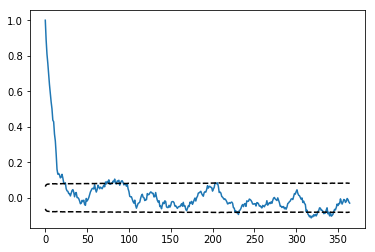

In [8]:
(trash, sigtrash)=nanacf(AnoTable['P_14_day'].values)
plt.plot(trash)
plt.plot(sigtrash, 'k--')
plt.plot(-sigtrash, 'k--')

In [10]:
count = 0
for column in AnoTable:
   # plt.figure()
    (r, sig_thr) = nanacf(AnoTable.loc[:,column].values) 
    #plt.plot(r)
    #plt.plot(sig_thr, 'k--')
    #plt.plot(-sig_thr, 'k--')
    #plt.xlabel('lag')
    #plt.ylabel('autocorrelation')
    #plt.title(table.columns[count])
    count = count + 1
    above_thr = r-sig_thr
    not_corr = np.where(above_thr<0)
    if np.min(np.size(not_corr))>0:
        
        per = not_corr[0][0]
    else:
        per = 999
    #print(np.size(per))
    if per <= 18: #Print out variables that have a period deemed acceptable for avoiding pseudoreplication (albeit subjective)
        print(column)
        print(per)

Rh
R
T_-5cm
T_-10cm
T_-20cm
P
T_-5cm_7_day
T_-10cm_7_day
T_-10cm_14_day
P_7_day


In [273]:
not_corr = np.array([1])
np.min(np.size(not_corr))

1

#### Observations
Reco, NEE, GPP, and Methane flux have distributions where most of the data is near the mean, and there are a few extreme outliers. May want to transform to better emphasize changes near the mean and increase the entropy of the anomaly dataset. This can be done without regard to what the final values of the transformed dataset are, as all that matters is the binning. Do a square root transform that preserves the sign of the original anomaly. 

In [7]:
def HistSqrtTransform(arr, plot_on=0, plot_title=''): #Input is an array, which may contain NaNs and zeros
    transformed = np.zeros(len(arr)) #initialize
    transformed = np.sqrt(np.abs(arr))*np.sign(arr)
   
    if plot_on:
        plt.hist(transformed[~np.isnan(transformed)])
        plt.title(plot_title)
    return transformed;

Now add new entries in the table for transformed values.

C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sign
  This is separate from the ipykernel package so we can avoid doing imports until


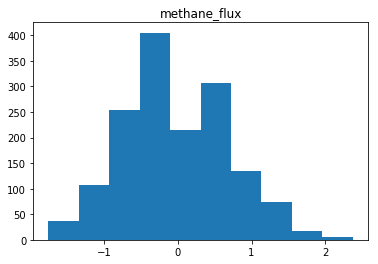

In [124]:
#AnoTable['sqrt_Reco'] = HistSqrtTransform(AnoTable['Reco'], 1, 'Reco')
#plt.figure()
#AnoTable['sqrt_NEE'] = HistSqrtTransform(AnoTable['NEE'], 1, 'NEE')
#plt.figure()
#AnoTable['sqrt_GPP'] = HistSqrtTransform(AnoTable['GPP'], 1, 'GPP')
#plt.figure()
AnoTable['sqrt_methane_flux'] = HistSqrtTransform(AnoTable['methane_flux'], 1, 'methane_flux');

That looks better!

In [125]:
AnoTable.head()

T_air         Rh       R    T_-5cm   T_-10cm   T_-20cm  \
Year_Month_Day                                                            
2005-01-01      2.3970  -0.550000  10.961 -0.533750 -0.375000 -0.548000   
2005-01-02      5.1430   7.110000  -4.196 -0.413750 -0.358000 -0.548000   
2005-01-03      4.5620   7.270000   2.287 -0.372500 -0.343000 -0.525000   
2005-01-04      3.0490   7.240000   2.269 -0.441250 -0.338000 -0.517000   
2005-01-05      4.8175  10.533333  -4.038 -0.388571 -0.306667 -0.487778   

                 T_-35cm   T_-50cm        WT       NEE        ...          \
Year_Month_Day                                                ...           
2005-01-01     -0.731000 -1.276000  8.756000 -0.050000        ...           
2005-01-02     -0.708000 -1.240000  8.790000 -0.067143        ...           
2005-01-03     -0.700000 -1.219000  8.970000 -0.025714        ...           
2005-01-04     -0.675000 -1.202000  9.083000 -0.108333        ...           
2005-01-05     -0.637778 -1.231111  9.377778 -0.106667        ...           

                GPP_91_day  GPP_183_day  GPP_365_day  P_7_day  P_14_day  \
Year_Month_Day                                                            
2005-01-01             NaN          NaN          NaN      NaN       NaN   
2005-01-02             NaN          NaN          NaN      NaN       NaN   
2005-01-03             NaN          NaN          NaN      NaN       NaN   
2005-01-04             NaN          NaN          NaN      NaN       NaN   
2005-01-05             NaN          NaN          NaN      NaN       NaN   

                P_30_day  P_91_day  P_183_day  P_365_day  sqrt_methane_flux  
Year_Month_Day                                                               
2005-01-01           NaN       NaN        NaN        NaN                NaN  
2005-01-02           NaN       NaN        NaN        NaN                NaN  
2005-01-03           NaN       NaN        NaN        NaN                NaN  
2005-01-04           NaN       NaN        NaN        NaN                NaN  
2005-01-05           NaN       NaN        NaN        NaN                NaN  

[5 rows x 75 columns]

### Nontransformed, t-1

In [16]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,13), 14:numVr+1]# ,10)] transformed, np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([13]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['DateTime' 'methane_flux' 'T_air' 'Rh' 'R' 'T_-5cm' 'T_-10cm' 'T_-20cm'
 'T_-35cm' 'T_-50cm' 'WT' 'NEE' 'Reco' 'GPP' 'P' 'H2O' 'T_air_7_day'
 'T_air_14_day' 'T_air_30_day' 'T_air_91_day' 'T_air_183_day'
 'T_air_365_day' 'Rh_7_day' 'Rh_14_day' 'Rh_30_day' 'Rh_91_day'
 'Rh_183_day' 'Rh_365_day' 'R_7_day' 'R_14_day' 'R_30_day' 'R_91_day'
 'R_183_day' 'R_365_day' 'T_-5cm_7_day' 'T_-5cm_14_day' 'T_-5cm_30_day'
 'T_-5cm_91_day' 'T_-5cm_183_day' 'T_-5cm_365_day' 'T_-10cm_7_day'
 'T_-10cm_14_day' 'T_-10cm_30_day' 'T_-10cm_91_day' 'T_-10cm_183_day'
 'T_-10cm_365_day' 'WT_7_day' 'WT_14_day' 'WT_30_day' 'WT_91_day'
 'WT_183_day' 'WT_365_day' 'NEE_7_day' 'NEE_14_day' 'NEE_30_day'
 'NEE_91_day' 'NEE_183_day' 'NEE_365_day' 'Reco_7_day' 'Reco_14_day'
 'Reco_30_day' 'Reco_91_day' 'Reco_183_day' 'Reco_365_day' 'GPP_7_day'
 'GPP_14_day' 'GPP_30_day' 'GPP_91_day' 'GPP_183_day' 'GPP_365_day'
 'P_7_day' 'P_14_day' 'P_30_day' 'P_91_day' 'P_183_day' 'P_365_day'
 'H2O_7_day' 'H2O_14_day' 'H2O_30_day' 'H2O_91

In [15]:
#SCRATCH
def PickSampleInterval(X, maxlag=365, alpha=0.05): #Dynamically selects the appropriate interval for sampling the data, based on the autocorrelation function. Nans are OK. Alpha is the significance level for assessing the significance of the autocorrelation function.
    nX = len(X)
    r = np.zeros(maxlag)
    sig_thr = np.zeros(maxlag)
    for ii in range(maxlag):
        if ii == 0:
            Y = X
            Z = X
        else:
            Y = X[:-ii].copy()
            Z = X[ii:].copy()
        Y[np.isnan(Z)]=np.nan
        Z[np.isnan(Y)]=np.nan
            
        r[ii] = np.corrcoef(Y[~np.isnan(Y)], Z[~np.isnan(Z)])[0,1]
        sig_thr[ii] = norm.ppf(1-alpha/2)/np.sqrt(np.sum(~np.isnan(Y)))
 #   plt.plot(r)
 #   plt.xlabel('Lag')
 #   plt.ylabel('Autocorrelation')
    above_thr = r-sig_thr
    not_corr = np.where(above_thr<0)
    if np.min(np.size(not_corr))>0:
        
        per = not_corr[0][0] # "per" is the period. The data should be sampled once per period.
    else:
        per = maxlag
    return per

In [17]:
# Applying TE on the anomaly data
#importlib.reload(TEpython4)

sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython4.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365,shift=sf, minSamples=10)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  13 methane_flux
Lag  Sink Source
24
0 0 0 40
1 0 0 41
2 0 0 47
3 0 0 42
4 0 0 42
5 0 0 36
6 0 0 36
7 0 0 35
8 0 0 38
9 0 0 39
10 0 0 34
11 0 0 28
12 0 0 35
13 0 0 37
14 0 0 36
15 0 0 40
16 0 0 44
17 0 0 46
18 0 0 37
19 0 0 43
20 0 0 41
21 0 0 41
22 0 0 41
23 0 0 38
24 0 0 37
25 0 0 41
26 0 0 47
27 0 0 43
28 0 0 42
29 0 0 33
30 0 0 34
31 0 0 37
32 0 0 37
33 0 0 39
34 0 0 35
35 0 0 30
36 0 0 38
37 0 0 38
38 0 0 35
39 0 0 39
40 0 0 47
41 0 0 48
42 0 0 36
43 0 0 45
44 0 0 41
45 0 0 41
46 0 0 41
47 0 0 39
48 0 0 36
49 0 0 41
50 0 0 46
51 0 0 41
52 0 0 39
53 0 0 35
54 0 0 35
55 0 0 33
56 0 0 35
57 0 0 37
58 0 0 33
59 0 0 27
60 0 0 33
61 0 0 34
62 0 0 34
63 0 0 38
64 0 0 45
65 0 0 46
66 0 0 35
67 0 0 45
68 0 0 42
69 0 0 43
70 0 0 42
71 0 0 37
72 0 0 36
73 0 0 41
74 0 0 45
75 0 0 39
76 0 0 38
77 0 0 33
78 0 0 35
79 0 0 34
80 0 0 36
81 0 0 38
82 0 0 34
83 0 0 29
84 0 0 33
85 0 0 35
86 0 0 34
87 0 0 39
88 0 0 45
89 0 

13 0 2 144
14 0 2 132
15 0 2 119
16 0 2 122
17 0 2 122
18 0 2 127
19 0 2 132
20 0 2 128
21 0 2 134
22 0 2 144
23 0 2 132
24 0 2 119
25 0 2 122
26 0 2 122
27 0 2 127
28 0 2 132
29 0 2 128
30 0 2 134
31 0 2 144
32 0 2 132
33 0 2 119
34 0 2 122
35 0 2 122
36 0 2 127
37 0 2 132
38 0 2 128
39 0 2 134
40 0 2 144
41 0 2 132
42 0 2 119
43 0 2 122
44 0 2 122
45 0 2 127
46 0 2 132
47 0 2 128
48 0 2 134
49 0 2 144
50 0 2 132
51 0 2 119
52 0 2 122
53 0 2 122
54 0 2 127
55 0 2 132
56 0 2 128
57 0 2 134
58 0 2 144
59 0 2 132
60 0 2 119
61 0 2 122
62 0 2 122
63 0 2 127
64 0 2 132
65 0 2 128
66 0 2 134
67 0 2 144
68 0 2 132
69 0 2 119
70 0 2 122
71 0 2 122
72 0 2 127
73 0 2 132
74 0 2 128
75 0 2 134
76 0 2 144
77 0 2 132
78 0 2 119
79 0 2 122
80 0 2 122
81 0 2 127
82 0 2 132
83 0 2 128
84 0 2 134
85 0 2 144
86 0 2 132
87 0 2 119
88 0 2 122
89 0 2 122
90 0 2 127
91 0 2 132
92 0 2 128
93 0 2 134
94 0 2 144
95 0 2 132
96 0 2 119
97 0 2 122
98 0 2 122
99 0 2 127
100 0 2 132
101 0 2 128
102 0 2 134
103 0 2

2 0 4 68
3 0 4 77
4 0 4 82
5 0 4 74
6 0 4 72
7 0 4 68
8 0 4 69
9 0 4 76
10 0 4 81
11 0 4 75
12 0 4 67
13 0 4 65
14 0 4 69
15 0 4 75
16 0 4 65
17 0 4 74
18 0 4 80
19 0 4 75
20 0 4 73
21 0 4 69
22 0 4 73
23 0 4 78
24 0 4 83
25 0 4 76
26 0 4 66
27 0 4 64
28 0 4 69
29 0 4 73
30 0 4 64
31 0 4 75
32 0 4 80
33 0 4 75
34 0 4 72
35 0 4 69
36 0 4 70
37 0 4 77
38 0 4 82
39 0 4 74
40 0 4 66
41 0 4 63
42 0 4 69
43 0 4 73
44 0 4 62
45 0 4 75
46 0 4 80
47 0 4 74
48 0 4 70
49 0 4 69
50 0 4 72
51 0 4 75
52 0 4 80
53 0 4 72
54 0 4 66
55 0 4 63
56 0 4 69
57 0 4 74
58 0 4 63
59 0 4 75
60 0 4 77
61 0 4 71
62 0 4 70
63 0 4 68
64 0 4 71
65 0 4 75
66 0 4 80
67 0 4 74
68 0 4 66
69 0 4 64
70 0 4 70
71 0 4 76
72 0 4 65
73 0 4 76
74 0 4 79
75 0 4 74
76 0 4 72
77 0 4 69
78 0 4 72
79 0 4 75
80 0 4 81
81 0 4 71
82 0 4 65
83 0 4 66
84 0 4 71
85 0 4 76
86 0 4 63
87 0 4 76
88 0 4 79
89 0 4 74
90 0 4 72
91 0 4 65
92 0 4 70
93 0 4 74
94 0 4 77
95 0 4 70
96 0 4 64
97 0 4 63
98 0 4 71
99 0 4 76
100 0 4 62
101 0 4 75
102 0 

27 0 6 13
28 0 6 16
29 0 6 10
30 0 6 15
31 0 6 16
32 0 6 15
33 0 6 19
34 0 6 18
35 0 6 17
36 0 6 19
37 0 6 19
38 0 6 19
39 0 6 23
40 0 6 21
41 0 6 18
42 0 6 17
43 0 6 18
44 0 6 20
45 0 6 11
46 0 6 11
47 0 6 15
48 0 6 19
49 0 6 23
50 0 6 19
51 0 6 21
52 0 6 18
53 0 6 17
54 0 6 15
55 0 6 15
56 0 6 18
57 0 6 18
58 0 6 16
59 0 6 16
60 0 6 18
61 0 6 20
62 0 6 16
63 0 6 17
64 0 6 24
65 0 6 21
66 0 6 20
67 0 6 18
68 0 6 17
69 0 6 14
70 0 6 16
71 0 6 19
72 0 6 15
73 0 6 18
74 0 6 21
75 0 6 17
76 0 6 19
77 0 6 23
78 0 6 20
79 0 6 16
80 0 6 14
81 0 6 19
82 0 6 17
83 0 6 20
84 0 6 16
85 0 6 18
86 0 6 20
87 0 6 15
88 0 6 15
89 0 6 16
90 0 6 13
91 0 6 13
92 0 6 15
93 0 6 11
94 0 6 15
95 0 6 16
96 0 6 15
97 0 6 18
98 0 6 17
99 0 6 17
100 0 6 19
101 0 6 18
102 0 6 18
103 0 6 22
104 0 6 20
105 0 6 17
106 0 6 16
107 0 6 17
108 0 6 20
109 0 6 12
110 0 6 12
111 0 6 14
112 0 6 18
113 0 6 21
114 0 6 20
115 0 6 22
116 0 6 19
117 0 6 17
118 0 6 15
119 0 6 15
120 0 6 18
121 0 6 18
122 0 6 16
123 0 6 16
124 0 

C:\Users\Laurel Larsen\Dropbox\Fulbright\Research\Code_templates\TEpython4.py:897: RuntimeWarning: invalid value encountered in greater_equal
  TgTcrit = np.argwhere(T >= Tcrit)  # np.argwhere(np.array([5,6,9,18]) > np.array([3,9,2,9]))


Source node  7 T_-50cm :=> Sink node  13 methane_flux
Lag  Sink Source
351
0 0 7 2
1 0 7 2
2 0 7 3
3 0 7 3
4 0 7 5
5 0 7 3
6 0 7 2
7 0 7 3
8 0 7 3
9 0 7 3
10 0 7 3
11 0 7 4
12 0 7 5
13 0 7 5
14 0 7 1
15 0 7 1
16 0 7 1
17 0 7 2
18 0 7 2
19 0 7 3
20 0 7 2
21 0 7 2
22 0 7 2
23 0 7 3
24 0 7 4
25 0 7 3
26 0 7 1
27 0 7 1
28 0 7 3
29 0 7 0
30 0 7 0
31 0 7 2
32 0 7 1
33 0 7 0
34 0 7 1
35 0 7 1
36 0 7 2
37 0 7 1
38 0 7 2
39 0 7 2
40 0 7 1
41 0 7 2
42 0 7 3
43 0 7 5
44 0 7 4
45 0 7 1
46 0 7 0
47 0 7 2
48 0 7 2
49 0 7 2
50 0 7 2
51 0 7 0
52 0 7 1
53 0 7 0
54 0 7 3
55 0 7 2
56 0 7 0
57 0 7 1
58 0 7 2
59 0 7 2
60 0 7 1
61 0 7 1
62 0 7 3
63 0 7 1
64 0 7 1
65 0 7 2
66 0 7 1
67 0 7 1
68 0 7 3
69 0 7 2
70 0 7 2
71 0 7 1
72 0 7 1
73 0 7 0
74 0 7 1
75 0 7 3
76 0 7 3
77 0 7 2
78 0 7 1
79 0 7 2
80 0 7 1
81 0 7 1
82 0 7 1
83 0 7 3
84 0 7 2
85 0 7 1
86 0 7 0
87 0 7 0
88 0 7 0
89 0 7 0
90 0 7 1
91 0 7 0
92 0 7 1
93 0 7 3
94 0 7 4
95 0 7 4
96 0 7 3
97 0 7 3
98 0 7 2
99 0 7 1
100 0 7 2
101 0 7 0
102 0 7 2
103 0

C:\Users\Laurel Larsen\Dropbox\Fulbright\Research\Code_templates\TEpython4.py:422: RuntimeWarning: invalid value encountered in double_scalars
  T = (T1+T2-T3-T4)/Tn # Knuth formulation of transfer entropy


 0 7 1
121 0 7 2
122 0 7 2
123 0 7 2
124 0 7 3
125 0 7 3
126 0 7 3
127 0 7 2
128 0 7 1
129 0 7 2
130 0 7 2
131 0 7 1
132 0 7 1
133 0 7 1
134 0 7 2
135 0 7 2
136 0 7 2
137 0 7 0
138 0 7 0
139 0 7 1
140 0 7 2
141 0 7 2
142 0 7 0
143 0 7 1
144 0 7 1
145 0 7 1
146 0 7 4
147 0 7 2
148 0 7 2
149 0 7 1
150 0 7 1
151 0 7 2
152 0 7 1
153 0 7 2
154 0 7 2
155 0 7 2
156 0 7 0
157 0 7 1
158 0 7 3
159 0 7 2
160 0 7 1
161 0 7 2
162 0 7 3
163 0 7 3
164 0 7 3
165 0 7 4
166 0 7 4
167 0 7 4
168 0 7 4
169 0 7 3
170 0 7 3
171 0 7 2
172 0 7 3
173 0 7 4
174 0 7 5
175 0 7 2
176 0 7 3
177 0 7 3
178 0 7 3
179 0 7 2
180 0 7 3
181 0 7 4
182 0 7 2
183 0 7 2
184 0 7 2
185 0 7 2
186 0 7 1
187 0 7 1
188 0 7 2
189 0 7 1
190 0 7 2
191 0 7 5
192 0 7 5
193 0 7 6
194 0 7 3
195 0 7 5
196 0 7 3
197 0 7 1
198 0 7 3
199 0 7 3
200 0 7 4
201 0 7 5
202 0 7 4
203 0 7 4
204 0 7 6
205 0 7 5
206 0 7 3
207 0 7 3
208 0 7 4
209 0 7 5
210 0 7 3
211 0 7 1
212 0 7 2
213 0 7 2
214 0 7 2
215 0 7 2
216 0 7 5
217 0 7 5
218 0 7 4
219 0 7 5
220

C:\Users\Laurel Larsen\Dropbox\Fulbright\Research\Code_templates\TEpython4.py:422: RuntimeWarning: divide by zero encountered in double_scalars
  T = (T1+T2-T3-T4)/Tn # Knuth formulation of transfer entropy


8 2
176 0 8 3
177 0 8 3
178 0 8 4
179 0 8 3
180 0 8 2
181 0 8 3
182 0 8 2
183 0 8 2
184 0 8 2
185 0 8 1
186 0 8 3
187 0 8 2
188 0 8 1
189 0 8 3
190 0 8 3
191 0 8 3
192 0 8 2
193 0 8 3
194 0 8 3
195 0 8 3
196 0 8 3
197 0 8 3
198 0 8 3
199 0 8 3
200 0 8 2
201 0 8 3
202 0 8 2
203 0 8 4
204 0 8 3
205 0 8 3
206 0 8 1
207 0 8 1
208 0 8 1
209 0 8 2
210 0 8 2
211 0 8 1
212 0 8 0
213 0 8 0
214 0 8 1
215 0 8 1
216 0 8 2
217 0 8 3
218 0 8 4
219 0 8 3
220 0 8 2
221 0 8 2
222 0 8 1
223 0 8 2
224 0 8 3
225 0 8 3
226 0 8 1
227 0 8 2
228 0 8 2
229 0 8 3
230 0 8 2
231 0 8 2
232 0 8 1
233 0 8 1
234 0 8 2
235 0 8 2
236 0 8 3
237 0 8 2
238 0 8 2
239 0 8 2
240 0 8 4
241 0 8 4
242 0 8 4
243 0 8 3
244 0 8 2
245 0 8 2
246 0 8 3
247 0 8 4
248 0 8 3
249 0 8 2
250 0 8 3
251 0 8 1
252 0 8 0
253 0 8 1
254 0 8 0
255 0 8 3
256 0 8 3
257 0 8 3
258 0 8 3
259 0 8 3
260 0 8 2
261 0 8 3
262 0 8 4
263 0 8 3
264 0 8 2
265 0 8 2
266 0 8 2
267 0 8 3
268 0 8 2
269 0 8 3
270 0 8 2
271 0 8 2
272 0 8 2
273 0 8 0
274 0 8 3
275 0 

198 0 10 25
199 0 10 32
200 0 10 26
201 0 10 26
202 0 10 29
203 0 10 23
204 0 10 24
205 0 10 24
206 0 10 24
207 0 10 21
208 0 10 22
209 0 10 28
210 0 10 24
211 0 10 31
212 0 10 24
213 0 10 23
214 0 10 25
215 0 10 19
216 0 10 22
217 0 10 23
218 0 10 22
219 0 10 21
220 0 10 24
221 0 10 24
222 0 10 19
223 0 10 20
224 0 10 26
225 0 10 26
226 0 10 28
227 0 10 26
228 0 10 23
229 0 10 24
230 0 10 26
231 0 10 30
232 0 10 26
233 0 10 26
234 0 10 28
235 0 10 23
236 0 10 24
237 0 10 24
238 0 10 24
239 0 10 20
240 0 10 22
241 0 10 26
242 0 10 22
243 0 10 30
244 0 10 25
245 0 10 23
246 0 10 25
247 0 10 20
248 0 10 24
249 0 10 24
250 0 10 20
251 0 10 21
252 0 10 27
253 0 10 26
254 0 10 20
255 0 10 21
256 0 10 26
257 0 10 27
258 0 10 28
259 0 10 26
260 0 10 25
261 0 10 24
262 0 10 26
263 0 10 32
264 0 10 27
265 0 10 25
266 0 10 26
267 0 10 19
268 0 10 22
269 0 10 23
270 0 10 24
271 0 10 21
272 0 10 21
273 0 10 27
274 0 10 21
275 0 10 31
276 0 10 26
277 0 10 26
278 0 10 25
279 0 10 19
280 0 10 22
281 

150 0 12 359
151 0 12 366
152 0 12 373
153 0 12 390
154 0 12 385
155 0 12 381
156 0 12 380
157 0 12 382
158 0 12 378
159 0 12 391
160 0 12 379
161 0 12 393
162 0 12 385
163 0 12 378
164 0 12 378
165 0 12 378
166 0 12 361
167 0 12 368
168 0 12 361
169 0 12 374
170 0 12 378
171 0 12 389
172 0 12 388
173 0 12 379
174 0 12 373
175 0 12 381
176 0 12 373
177 0 12 373
178 0 12 374
179 0 12 379
180 0 12 375
181 0 12 376
182 0 12 373
183 0 12 388
184 0 12 379
185 0 12 396
186 0 12 375
187 0 12 374
188 0 12 365
189 0 12 383
190 0 12 374
191 0 12 375
192 0 12 358
193 0 12 373
194 0 12 371
195 0 12 366
196 0 12 370
197 0 12 375
198 0 12 365
199 0 12 371
200 0 12 361
201 0 12 385
202 0 12 383
203 0 12 382
204 0 12 366
205 0 12 365
206 0 12 368
207 0 12 373
208 0 12 379
209 0 12 382
210 0 12 378
211 0 12 395
212 0 12 388
213 0 12 373
214 0 12 379
215 0 12 387
216 0 12 384
217 0 12 378
218 0 12 366
219 0 12 367
220 0 12 361
221 0 12 368
222 0 12 369
223 0 12 374
224 0 12 374
225 0 12 383
226 0 12 373

90 0 14 35
91 0 14 33
92 0 14 35
93 0 14 35
94 0 14 31
95 0 14 30
96 0 14 34
97 0 14 25
98 0 14 25
99 0 14 35
100 0 14 41
101 0 14 43
102 0 14 42
103 0 14 42
104 0 14 32
105 0 14 32
106 0 14 33
107 0 14 29
108 0 14 37
109 0 14 33
110 0 14 28
111 0 14 24
112 0 14 23
113 0 14 32
114 0 14 34
115 0 14 44
116 0 14 36
117 0 14 35
118 0 14 34
119 0 14 34
120 0 14 32
121 0 14 32
122 0 14 38
123 0 14 28
124 0 14 28
125 0 14 39
126 0 14 44
127 0 14 43
128 0 14 42
129 0 14 44
130 0 14 33
131 0 14 31
132 0 14 35
133 0 14 30
134 0 14 39
135 0 14 38
136 0 14 32
137 0 14 29
138 0 14 25
139 0 14 32
140 0 14 34
141 0 14 41
142 0 14 35
143 0 14 37
144 0 14 38
145 0 14 35
146 0 14 35
147 0 14 36
148 0 14 40
149 0 14 31
150 0 14 33
151 0 14 44
152 0 14 50
153 0 14 47
154 0 14 42
155 0 14 44
156 0 14 33
157 0 14 31
158 0 14 32
159 0 14 30
160 0 14 39
161 0 14 38
162 0 14 34
163 0 14 30
164 0 14 27
165 0 14 33
166 0 14 36
167 0 14 40
168 0 14 32
169 0 14 34
170 0 14 36
171 0 14 34
172 0 14 34
173 0 14 35
17

44 0 16 22
45 0 16 20
46 0 16 22
47 0 16 21
48 0 16 23
49 0 16 19
50 0 16 24
51 0 16 20
52 0 16 25
53 0 16 28
54 0 16 28
55 0 16 23
56 0 16 26
57 0 16 21
58 0 16 23
59 0 16 26
60 0 16 23
61 0 16 25
62 0 16 23
63 0 16 25
64 0 16 26
65 0 16 26
66 0 16 33
67 0 16 31
68 0 16 22
69 0 16 26
70 0 16 25
71 0 16 30
72 0 16 24
73 0 16 26
74 0 16 22
75 0 16 22
76 0 16 22
77 0 16 23
78 0 16 25
79 0 16 23
80 0 16 23
81 0 16 22
82 0 16 19
83 0 16 24
84 0 16 21
85 0 16 25
86 0 16 22
87 0 16 23
88 0 16 27
89 0 16 26
90 0 16 21
91 0 16 25
92 0 16 21
93 0 16 23
94 0 16 26
95 0 16 25
96 0 16 27
97 0 16 23
98 0 16 25
99 0 16 28
100 0 16 27
101 0 16 32
102 0 16 31
103 0 16 24
104 0 16 24
105 0 16 23
106 0 16 29
107 0 16 24
108 0 16 26
109 0 16 20
110 0 16 20
111 0 16 21
112 0 16 23
113 0 16 23
114 0 16 20
115 0 16 21
116 0 16 23
117 0 16 20
118 0 16 26
119 0 16 23
120 0 16 27
121 0 16 24
122 0 16 26
123 0 16 30
124 0 16 31
125 0 16 27
126 0 16 26
127 0 16 20
128 0 16 25
129 0 16 28
130 0 16 27
131 0 16 28


100 0 18 2
101 0 18 3
102 0 18 4
103 0 18 3
104 0 18 2
105 0 18 4
106 0 18 3
107 0 18 1
108 0 18 2
109 0 18 4
110 0 18 4
111 0 18 4
112 0 18 3
113 0 18 6
114 0 18 6
115 0 18 4
116 0 18 4
117 0 18 3
118 0 18 4
119 0 18 3
120 0 18 4
121 0 18 4
122 0 18 5
123 0 18 5
124 0 18 6
125 0 18 4
126 0 18 4
127 0 18 6
128 0 18 7
129 0 18 4
130 0 18 4
131 0 18 4
132 0 18 5
133 0 18 3
134 0 18 3
135 0 18 4
136 0 18 3
137 0 18 4
138 0 18 3
139 0 18 6
140 0 18 5
141 0 18 4
142 0 18 4
143 0 18 4
144 0 18 4
145 0 18 4
146 0 18 6
147 0 18 6
148 0 18 5
149 0 18 6
150 0 18 7
151 0 18 5
152 0 18 4
153 0 18 5
154 0 18 3
155 0 18 4
156 0 18 6
157 0 18 6
158 0 18 4
159 0 18 6
160 0 18 7
161 0 18 6
162 0 18 5
163 0 18 4
164 0 18 6
165 0 18 6
166 0 18 5
167 0 18 6
168 0 18 5
169 0 18 2
170 0 18 2
171 0 18 3
172 0 18 3
173 0 18 5
174 0 18 6
175 0 18 4
176 0 18 4
177 0 18 3
178 0 18 3
179 0 18 5
180 0 18 3
181 0 18 5
182 0 18 5
183 0 18 5
184 0 18 4
185 0 18 4
186 0 18 4
187 0 18 5
188 0 18 5
189 0 18 4
190 0 18 4

C:\Users\Laurel Larsen\Dropbox\Fulbright\Research\Code_templates\TEpython4.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  I = ( (-sum(p1gt0*np.log2(p1gt0)) - sum(p2gt0*log2p2gt0) ) + (sum(pgt0*np.log2(pgt0)))*np.log2(nbins[0])/np.log2(nbins[1]))/Hy


7 0 19 1
8 0 19 2
9 0 19 2
10 0 19 1
11 0 19 3
12 0 19 1
13 0 19 1
14 0 19 2
15 0 19 2
16 0 19 1
17 0 19 2
18 0 19 0
19 0 19 0
20 0 19 0
21 0 19 0
22 0 19 0
23 0 19 0
24 0 19 0
25 0 19 0
26 0 19 1
27 0 19 2
28 0 19 1
29 0 19 2
30 0 19 1
31 0 19 2
32 0 19 1
33 0 19 0
34 0 19 0
35 0 19 0
36 0 19 0
37 0 19 1
38 0 19 2
39 0 19 0
40 0 19 1
41 0 19 0
42 0 19 0
43 0 19 0
44 0 19 0
45 0 19 0
46 0 19 0
47 0 19 0
48 0 19 1
49 0 19 0
50 0 19 0
51 0 19 0
52 0 19 0
53 0 19 0
54 0 19 0
55 0 19 1
56 0 19 1
57 0 19 1
58 0 19 0
59 0 19 0
60 0 19 0
61 0 19 0
62 0 19 1
63 0 19 2
64 0 19 2
65 0 19 2
66 0 19 3
67 0 19 3
68 0 19 3
69 0 19 2
70 0 19 1
71 0 19 1
72 0 19 2
73 0 19 1
74 0 19 1
75 0 19 1
76 0 19 1
77 0 19 2
78 0 19 1
79 0 19 2
80 0 19 1
81 0 19 2
82 0 19 2
83 0 19 1
84 0 19 1
85 0 19 1
86 0 19 2
87 0 19 0
88 0 19 2
89 0 19 0
90 0 19 0
91 0 19 1
92 0 19 0
93 0 19 0
94 0 19 1
95 0 19 1
96 0 19 1
97 0 19 3
98 0 19 3
99 0 19 2
100 0 19 0
101 0 19 0
102 0 19 1
103 0 19 1
104 0 19 0
105 0 19 0
106 0 1

66 0 21 6
67 0 21 6
68 0 21 4
69 0 21 5
70 0 21 5
71 0 21 6
72 0 21 6
73 0 21 5
74 0 21 3
75 0 21 5
76 0 21 6
77 0 21 7
78 0 21 6
79 0 21 7
80 0 21 6
81 0 21 5
82 0 21 3
83 0 21 4
84 0 21 4
85 0 21 5
86 0 21 6
87 0 21 6
88 0 21 3
89 0 21 6
90 0 21 6
91 0 21 4
92 0 21 4
93 0 21 6
94 0 21 6
95 0 21 5
96 0 21 6
97 0 21 5
98 0 21 4
99 0 21 4
100 0 21 4
101 0 21 4
102 0 21 3
103 0 21 4
104 0 21 3
105 0 21 3
106 0 21 2
107 0 21 2
108 0 21 1
109 0 21 2
110 0 21 3
111 0 21 1
112 0 21 1
113 0 21 1
114 0 21 2
115 0 21 4
116 0 21 4
117 0 21 3
118 0 21 3
119 0 21 3
120 0 21 2
121 0 21 3
122 0 21 2
123 0 21 3
124 0 21 6
125 0 21 2
126 0 21 3
127 0 21 4
128 0 21 4
129 0 21 3
130 0 21 5
131 0 21 5
132 0 21 4
133 0 21 2
134 0 21 3
135 0 21 3
136 0 21 3
137 0 21 3
138 0 21 3
139 0 21 5
140 0 21 5
141 0 21 4
142 0 21 5
143 0 21 7
144 0 21 4
145 0 21 3
146 0 21 3
147 0 21 2
148 0 21 3
149 0 21 2
150 0 21 2
151 0 21 4
152 0 21 5
153 0 21 5
154 0 21 6
155 0 21 5
156 0 21 5
157 0 21 5
158 0 21 5
159 0 21 2


187 0 23 2
188 0 23 1
189 0 23 1
190 0 23 2
191 0 23 1
192 0 23 2
193 0 23 5
194 0 23 4
195 0 23 4
196 0 23 3
197 0 23 4
198 0 23 5
199 0 23 5
200 0 23 6
201 0 23 6
202 0 23 4
203 0 23 4
204 0 23 4
205 0 23 4
206 0 23 2
207 0 23 1
208 0 23 3
209 0 23 4
210 0 23 3
211 0 23 2
212 0 23 4
213 0 23 4
214 0 23 5
215 0 23 4
216 0 23 4
217 0 23 3
218 0 23 3
219 0 23 3
220 0 23 3
221 0 23 3
222 0 23 2
223 0 23 3
224 0 23 2
225 0 23 2
226 0 23 3
227 0 23 2
228 0 23 0
229 0 23 1
230 0 23 3
231 0 23 3
232 0 23 3
233 0 23 2
234 0 23 2
235 0 23 3
236 0 23 2
237 0 23 2
238 0 23 2
239 0 23 3
240 0 23 2
241 0 23 3
242 0 23 4
243 0 23 4
244 0 23 2
245 0 23 2
246 0 23 4
247 0 23 3
248 0 23 1
249 0 23 1
250 0 23 2
251 0 23 2
252 0 23 2
253 0 23 3
254 0 23 4
255 0 23 3
256 0 23 4
257 0 23 4
258 0 23 2
259 0 23 1
260 0 23 2
261 0 23 3
262 0 23 2
263 0 23 2
264 0 23 2
265 0 23 4
266 0 23 4
267 0 23 3
268 0 23 3
269 0 23 2
270 0 23 2
271 0 23 2
272 0 23 3
273 0 23 5
274 0 23 2
275 0 23 2
276 0 23 3
277 0 23 2

245 0 25 3
246 0 25 2
247 0 25 3
248 0 25 3
249 0 25 3
250 0 25 2
251 0 25 2
252 0 25 0
253 0 25 1
254 0 25 1
255 0 25 1
256 0 25 3
257 0 25 2
258 0 25 0
259 0 25 1
260 0 25 2
261 0 25 2
262 0 25 1
263 0 25 2
264 0 25 2
265 0 25 2
266 0 25 3
267 0 25 2
268 0 25 2
269 0 25 2
270 0 25 2
271 0 25 1
272 0 25 1
273 0 25 3
274 0 25 2
275 0 25 2
276 0 25 2
277 0 25 3
278 0 25 1
279 0 25 1
280 0 25 1
281 0 25 2
282 0 25 0
283 0 25 1
284 0 25 1
285 0 25 1
286 0 25 3
287 0 25 5
288 0 25 3
289 0 25 2
290 0 25 3
291 0 25 3
292 0 25 3
293 0 25 3
294 0 25 4
295 0 25 3
296 0 25 3
297 0 25 3
298 0 25 3
299 0 25 2
300 0 25 2
301 0 25 2
302 0 25 3
303 0 25 2
304 0 25 2
305 0 25 2
306 0 25 3
307 0 25 3
308 0 25 3
309 0 25 3
310 0 25 1
311 0 25 1
312 0 25 3
313 0 25 4
314 0 25 2
315 0 25 3
316 0 25 5
317 0 25 5
318 0 25 2
319 0 25 2
320 0 25 3
321 0 25 1
322 0 25 1
323 0 25 2
324 0 25 3
325 0 25 3
326 0 25 3
327 0 25 3
328 0 25 2
329 0 25 2
330 0 25 2
331 0 25 1
332 0 25 1
333 0 25 2
334 0 25 2
335 0 25 1

215 0 27 35
216 0 27 34
217 0 27 34
218 0 27 42
219 0 27 48
220 0 27 46
221 0 27 42
222 0 27 46
223 0 27 41
224 0 27 37
225 0 27 40
226 0 27 41
227 0 27 38
228 0 27 40
229 0 27 41
230 0 27 32
231 0 27 33
232 0 27 38
233 0 27 38
234 0 27 41
235 0 27 40
236 0 27 36
237 0 27 34
238 0 27 33
239 0 27 32
240 0 27 33
241 0 27 41
242 0 27 35
243 0 27 32
244 0 27 35
245 0 27 34
246 0 27 33
247 0 27 41
248 0 27 47
249 0 27 45
250 0 27 41
251 0 27 46
252 0 27 41
253 0 27 37
254 0 27 40
255 0 27 40
256 0 27 37
257 0 27 39
258 0 27 40
259 0 27 31
260 0 27 32
261 0 27 37
262 0 27 37
263 0 27 40
264 0 27 39
265 0 27 35
266 0 27 33
267 0 27 32
268 0 27 31
269 0 27 32
270 0 27 40
271 0 27 34
272 0 27 32
273 0 27 35
274 0 27 33
275 0 27 32
276 0 27 40
277 0 27 46
278 0 27 44
279 0 27 41
280 0 27 46
281 0 27 40
282 0 27 36
283 0 27 39
284 0 27 39
285 0 27 37
286 0 27 39
287 0 27 39
288 0 27 31
289 0 27 32
290 0 27 37
291 0 27 37
292 0 27 40
293 0 27 38
294 0 27 35
295 0 27 33
296 0 27 32
297 0 27 31
298 

229 0 29 4
230 0 29 4
231 0 29 4
232 0 29 4
233 0 29 3
234 0 29 2
235 0 29 2
236 0 29 3
237 0 29 1
238 0 29 1
239 0 29 0
240 0 29 2
241 0 29 4
242 0 29 1
243 0 29 0
244 0 29 2
245 0 29 3
246 0 29 3
247 0 29 2
248 0 29 3
249 0 29 4
250 0 29 3
251 0 29 4
252 0 29 2
253 0 29 2
254 0 29 4
255 0 29 5
256 0 29 3
257 0 29 2
258 0 29 3
259 0 29 3
260 0 29 3
261 0 29 3
262 0 29 2
263 0 29 4
264 0 29 5
265 0 29 4
266 0 29 3
267 0 29 3
268 0 29 1
269 0 29 1
270 0 29 3
271 0 29 3
272 0 29 2
273 0 29 1
274 0 29 2
275 0 29 3
276 0 29 1
277 0 29 2
278 0 29 4
279 0 29 6
280 0 29 4
281 0 29 2
282 0 29 2
283 0 29 3
284 0 29 3
285 0 29 2
286 0 29 3
287 0 29 2
288 0 29 2
289 0 29 2
290 0 29 3
291 0 29 2
292 0 29 1
293 0 29 3
294 0 29 1
295 0 29 0
296 0 29 0
297 0 29 2
298 0 29 2
299 0 29 3
300 0 29 3
301 0 29 3
302 0 29 2
303 0 29 2
304 0 29 4
305 0 29 3
306 0 29 4
307 0 29 4
308 0 29 4
309 0 29 4
310 0 29 1
311 0 29 3
312 0 29 1
313 0 29 2
314 0 29 3
315 0 29 2
316 0 29 2
317 0 29 3
318 0 29 3
319 0 29 2

260 0 31 3
261 0 31 3
262 0 31 2
263 0 31 4
264 0 31 5
265 0 31 4
266 0 31 3
267 0 31 3
268 0 31 1
269 0 31 1
270 0 31 3
271 0 31 3
272 0 31 2
273 0 31 1
274 0 31 2
275 0 31 3
276 0 31 1
277 0 31 2
278 0 31 4
279 0 31 6
280 0 31 4
281 0 31 2
282 0 31 2
283 0 31 3
284 0 31 3
285 0 31 2
286 0 31 3
287 0 31 2
288 0 31 2
289 0 31 2
290 0 31 3
291 0 31 2
292 0 31 1
293 0 31 3
294 0 31 1
295 0 31 0
296 0 31 0
297 0 31 2
298 0 31 2
299 0 31 3
300 0 31 3
301 0 31 3
302 0 31 2
303 0 31 2
304 0 31 4
305 0 31 3
306 0 31 4
307 0 31 4
308 0 31 4
309 0 31 4
310 0 31 1
311 0 31 3
312 0 31 1
313 0 31 2
314 0 31 3
315 0 31 2
316 0 31 2
317 0 31 3
318 0 31 3
319 0 31 2
320 0 31 2
321 0 31 3
322 0 31 4
323 0 31 5
324 0 31 4
325 0 31 3
326 0 31 2
327 0 31 2
328 0 31 4
329 0 31 4
330 0 31 2
331 0 31 2
332 0 31 2
333 0 31 3
334 0 31 3
335 0 31 3
336 0 31 3
337 0 31 3
338 0 31 2
339 0 31 1
340 0 31 1
341 0 31 2
342 0 31 1
343 0 31 2
344 0 31 1
345 0 31 1
346 0 31 2
347 0 31 3
348 0 31 3
349 0 31 1
350 0 31 1

227 0 33 42
228 0 33 48
229 0 33 37
230 0 33 35
231 0 33 38
232 0 33 38
233 0 33 38
234 0 33 31
235 0 33 36
236 0 33 50
237 0 33 46
238 0 33 42
239 0 33 44
240 0 33 38
241 0 33 41
242 0 33 42
243 0 33 40
244 0 33 36
245 0 33 37
246 0 33 39
247 0 33 40
248 0 33 48
249 0 33 38
250 0 33 34
251 0 33 38
252 0 33 37
253 0 33 37
254 0 33 31
255 0 33 34
256 0 33 48
257 0 33 44
258 0 33 40
259 0 33 43
260 0 33 37
261 0 33 41
262 0 33 41
263 0 33 40
264 0 33 37
265 0 33 38
266 0 33 39
267 0 33 41
268 0 33 50
269 0 33 40
270 0 33 35
271 0 33 40
272 0 33 41
273 0 33 41
274 0 33 34
275 0 33 37
276 0 33 51
277 0 33 46
278 0 33 41
279 0 33 43
280 0 33 36
281 0 33 37
282 0 33 41
283 0 33 41
284 0 33 37
285 0 33 40
286 0 33 42
287 0 33 43
288 0 33 51
289 0 33 42
290 0 33 38
291 0 33 42
292 0 33 43
293 0 33 40
294 0 33 34
295 0 33 37
296 0 33 50
297 0 33 46
298 0 33 43
299 0 33 44
300 0 33 37
301 0 33 38
302 0 33 42
303 0 33 41
304 0 33 35
305 0 33 39
306 0 33 41
307 0 33 41
308 0 33 51
309 0 33 42
310 

213 0 35 10
214 0 35 8
215 0 35 9
216 0 35 10
217 0 35 7
218 0 35 7
219 0 35 7
220 0 35 7
221 0 35 9
222 0 35 8
223 0 35 6
224 0 35 5
225 0 35 4
226 0 35 5
227 0 35 7
228 0 35 8
229 0 35 3
230 0 35 4
231 0 35 4
232 0 35 6
233 0 35 5
234 0 35 3
235 0 35 4
236 0 35 5
237 0 35 8
238 0 35 7
239 0 35 5
240 0 35 7
241 0 35 9
242 0 35 7
243 0 35 4
244 0 35 8
245 0 35 5
246 0 35 3
247 0 35 6
248 0 35 5
249 0 35 6
250 0 35 8
251 0 35 6
252 0 35 6
253 0 35 8
254 0 35 9
255 0 35 8
256 0 35 5
257 0 35 4
258 0 35 3
259 0 35 8
260 0 35 7
261 0 35 7
262 0 35 7
263 0 35 8
264 0 35 7
265 0 35 8
266 0 35 9
267 0 35 8
268 0 35 8
269 0 35 8
270 0 35 9
271 0 35 8
272 0 35 4
273 0 35 7
274 0 35 6
275 0 35 8
276 0 35 8
277 0 35 9
278 0 35 10
279 0 35 7
280 0 35 3
281 0 35 6
282 0 35 6
283 0 35 4
284 0 35 4
285 0 35 9
286 0 35 8
287 0 35 7
288 0 35 6
289 0 35 8
290 0 35 8
291 0 35 6
292 0 35 5
293 0 35 5
294 0 35 7
295 0 35 7
296 0 35 6
297 0 35 5
298 0 35 8
299 0 35 6
300 0 35 4
301 0 35 6
302 0 35 6
303 0 3

292 0 37 3
293 0 37 3
294 0 37 2
295 0 37 3
296 0 37 5
297 0 37 4
298 0 37 4
299 0 37 4
300 0 37 4
301 0 37 3
302 0 37 4
303 0 37 4
304 0 37 4
305 0 37 4
306 0 37 2
307 0 37 3
308 0 37 4
309 0 37 2
310 0 37 2
311 0 37 3
312 0 37 4
313 0 37 4
314 0 37 3
315 0 37 3
316 0 37 3
317 0 37 2
318 0 37 3
319 0 37 3
320 0 37 2
321 0 37 1
322 0 37 1
323 0 37 2
324 0 37 2
325 0 37 2
326 0 37 1
327 0 37 1
328 0 37 2
329 0 37 2
330 0 37 2
331 0 37 3
332 0 37 2
333 0 37 1
334 0 37 3
335 0 37 3
336 0 37 3
337 0 37 2
338 0 37 0
339 0 37 0
340 0 37 2
341 0 37 4
342 0 37 4
343 0 37 3
344 0 37 3
345 0 37 3
346 0 37 2
347 0 37 2
348 0 37 3
349 0 37 3
350 0 37 3
351 0 37 2
352 0 37 2
353 0 37 2
354 0 37 1
355 0 37 2
356 0 37 2
357 0 37 2
358 0 37 2
359 0 37 3
360 0 37 4
361 0 37 4
362 0 37 4
363 0 37 4
364 0 37 2
Source node  39 T_-10cm_7_day :=> Sink node  13 methane_flux
Lag  Sink Source
15
0 0 38 85
1 0 38 83
2 0 38 75
3 0 38 73
4 0 38 66
5 0 38 57
6 0 38 60
7 0 38 63
8 0 38 63
9 0 38 63
10 0 38 63
11 0 

257 0 39 53
258 0 39 45
259 0 39 44
260 0 39 50
261 0 39 57
262 0 39 52
263 0 39 51
264 0 39 49
265 0 39 56
266 0 39 54
267 0 39 48
268 0 39 52
269 0 39 49
270 0 39 50
271 0 39 56
272 0 39 55
273 0 39 62
274 0 39 63
275 0 39 54
276 0 39 47
277 0 39 46
278 0 39 51
279 0 39 58
280 0 39 55
281 0 39 51
282 0 39 50
283 0 39 56
284 0 39 54
285 0 39 48
286 0 39 51
287 0 39 48
288 0 39 49
289 0 39 55
290 0 39 55
291 0 39 62
292 0 39 64
293 0 39 52
294 0 39 44
295 0 39 44
296 0 39 51
297 0 39 57
298 0 39 55
299 0 39 51
300 0 39 47
301 0 39 55
302 0 39 54
303 0 39 47
304 0 39 49
305 0 39 47
306 0 39 50
307 0 39 54
308 0 39 52
309 0 39 59
310 0 39 62
311 0 39 53
312 0 39 45
313 0 39 45
314 0 39 50
315 0 39 56
316 0 39 53
317 0 39 50
318 0 39 47
319 0 39 56
320 0 39 54
321 0 39 47
322 0 39 49
323 0 39 48
324 0 39 52
325 0 39 56
326 0 39 53
327 0 39 57
328 0 39 61
329 0 39 51
330 0 39 45
331 0 39 45
332 0 39 50
333 0 39 57
334 0 39 53
335 0 39 51
336 0 39 49
337 0 39 56
338 0 39 54
339 0 39 47
340 

235 0 41 10
236 0 41 10
237 0 41 9
238 0 41 8
239 0 41 5
240 0 41 6
241 0 41 9
242 0 41 7
243 0 41 8
244 0 41 10
245 0 41 8
246 0 41 7
247 0 41 13
248 0 41 15
249 0 41 15
250 0 41 11
251 0 41 11
252 0 41 11
253 0 41 11
254 0 41 8
255 0 41 9
256 0 41 10
257 0 41 11
258 0 41 10
259 0 41 7
260 0 41 9
261 0 41 9
262 0 41 9
263 0 41 9
264 0 41 9
265 0 41 10
266 0 41 11
267 0 41 8
268 0 41 7
269 0 41 8
270 0 41 9
271 0 41 7
272 0 41 8
273 0 41 7
274 0 41 9
275 0 41 9
276 0 41 8
277 0 41 10
278 0 41 8
279 0 41 6
280 0 41 10
281 0 41 8
282 0 41 8
283 0 41 12
284 0 41 9
285 0 41 6
286 0 41 7
287 0 41 9
288 0 41 7
289 0 41 6
290 0 41 5
291 0 41 5
292 0 41 8
293 0 41 8
294 0 41 4
295 0 41 4
296 0 41 7
297 0 41 8
298 0 41 9
299 0 41 11
300 0 41 10
301 0 41 8
302 0 41 8
303 0 41 5
304 0 41 3
305 0 41 3
306 0 41 5
307 0 41 7
308 0 41 9
309 0 41 8
310 0 41 7
311 0 41 5
312 0 41 6
313 0 41 8
314 0 41 8
315 0 41 9
316 0 41 8
317 0 41 5
318 0 41 5
319 0 41 11
320 0 41 11
321 0 41 12
322 0 41 7
323 0 41 

337 0 43 3
338 0 43 2
339 0 43 1
340 0 43 1
341 0 43 2
342 0 43 1
343 0 43 2
344 0 43 1
345 0 43 1
346 0 43 2
347 0 43 3
348 0 43 3
349 0 43 1
350 0 43 1
351 0 43 2
352 0 43 3
353 0 43 3
354 0 43 3
355 0 43 2
356 0 43 2
357 0 43 2
358 0 43 1
359 0 43 1
360 0 43 2
361 0 43 2
362 0 43 2
363 0 43 2
364 0 43 3
Source node  45 WT_7_day :=> Sink node  13 methane_flux
Lag  Sink Source
314
0 0 44 5
1 0 44 5
2 0 44 3
3 0 44 3
4 0 44 2
5 0 44 3
6 0 44 4
7 0 44 3
8 0 44 4
9 0 44 1
10 0 44 1
11 0 44 3
12 0 44 5
13 0 44 4
14 0 44 4
15 0 44 4
16 0 44 4
17 0 44 4
18 0 44 3
19 0 44 3
20 0 44 3
21 0 44 3
22 0 44 2
23 0 44 2
24 0 44 2
25 0 44 4
26 0 44 2
27 0 44 1
28 0 44 1
29 0 44 1
30 0 44 1
31 0 44 1
32 0 44 3
33 0 44 2
34 0 44 2
35 0 44 2
36 0 44 2
37 0 44 2
38 0 44 2
39 0 44 2
40 0 44 2
41 0 44 3
42 0 44 3
43 0 44 3
44 0 44 1
45 0 44 1
46 0 44 1
47 0 44 0
48 0 44 2
49 0 44 2
50 0 44 1
51 0 44 2
52 0 44 2
53 0 44 1
54 0 44 3
55 0 44 3
56 0 44 3
57 0 44 2
58 0 44 3
59 0 44 4
60 0 44 3
61 0 44 2
62 0 

363 0 45 3
364 0 45 3
Source node  47 WT_30_day :=> Sink node  13 methane_flux
Lag  Sink Source
312
0 0 46 3
1 0 46 3
2 0 46 3
3 0 46 3
4 0 46 4
5 0 46 4
6 0 46 4
7 0 46 3
8 0 46 2
9 0 46 2
10 0 46 2
11 0 46 1
12 0 46 1
13 0 46 3
14 0 46 5
15 0 46 4
16 0 46 4
17 0 46 4
18 0 46 3
19 0 46 1
20 0 46 3
21 0 46 4
22 0 46 5
23 0 46 3
24 0 46 3
25 0 46 3
26 0 46 2
27 0 46 2
28 0 46 1
29 0 46 2
30 0 46 3
31 0 46 1
32 0 46 1
33 0 46 2
34 0 46 2
35 0 46 3
36 0 46 3
37 0 46 4
38 0 46 2
39 0 46 2
40 0 46 1
41 0 46 1
42 0 46 1
43 0 46 3
44 0 46 2
45 0 46 2
46 0 46 4
47 0 46 3
48 0 46 3
49 0 46 2
50 0 46 2
51 0 46 2
52 0 46 3
53 0 46 2
54 0 46 0
55 0 46 1
56 0 46 3
57 0 46 1
58 0 46 0
59 0 46 0
60 0 46 1
61 0 46 1
62 0 46 3
63 0 46 5
64 0 46 5
65 0 46 3
66 0 46 2
67 0 46 3
68 0 46 4
69 0 46 3
70 0 46 3
71 0 46 2
72 0 46 2
73 0 46 4
74 0 46 3
75 0 46 3
76 0 46 4
77 0 46 2
78 0 46 2
79 0 46 3
80 0 46 4
81 0 46 3
82 0 46 4
83 0 46 3
84 0 46 2
85 0 46 2
86 0 46 1
87 0 46 2
88 0 46 3
89 0 46 4
90 0 46 3


59 0 48 0
60 0 48 1
61 0 48 5
62 0 48 3
63 0 48 2
64 0 48 2
65 0 48 5
66 0 48 4
67 0 48 2
68 0 48 2
69 0 48 3
70 0 48 2
71 0 48 2
72 0 48 1
73 0 48 2
74 0 48 2
75 0 48 2
76 0 48 1
77 0 48 2
78 0 48 1
79 0 48 0
80 0 48 3
81 0 48 2
82 0 48 2
83 0 48 2
84 0 48 1
85 0 48 2
86 0 48 3
87 0 48 4
88 0 48 3
89 0 48 3
90 0 48 4
91 0 48 5
92 0 48 1
93 0 48 0
94 0 48 1
95 0 48 4
96 0 48 2
97 0 48 1
98 0 48 3
99 0 48 3
100 0 48 3
101 0 48 2
102 0 48 4
103 0 48 3
104 0 48 3
105 0 48 2
106 0 48 3
107 0 48 2
108 0 48 2
109 0 48 3
110 0 48 2
111 0 48 1
112 0 48 1
113 0 48 2
114 0 48 3
115 0 48 3
116 0 48 2
117 0 48 1
118 0 48 0
119 0 48 0
120 0 48 3
121 0 48 4
122 0 48 4
123 0 48 2
124 0 48 2
125 0 48 3
126 0 48 4
127 0 48 4
128 0 48 3
129 0 48 3
130 0 48 2
131 0 48 2
132 0 48 2
133 0 48 1
134 0 48 1
135 0 48 0
136 0 48 0
137 0 48 0
138 0 48 1
139 0 48 1
140 0 48 0
141 0 48 1
142 0 48 2
143 0 48 1
144 0 48 2
145 0 48 2
146 0 48 1
147 0 48 1
148 0 48 2
149 0 48 1
150 0 48 1
151 0 48 1
152 0 48 1
153 0 4

76 0 50 14
77 0 50 9
78 0 50 10
79 0 50 16
80 0 50 15
81 0 50 16
82 0 50 16
83 0 50 10
84 0 50 12
85 0 50 17
86 0 50 13
87 0 50 13
88 0 50 15
89 0 50 17
90 0 50 10
91 0 50 5
92 0 50 10
93 0 50 11
94 0 50 12
95 0 50 15
96 0 50 11
97 0 50 13
98 0 50 15
99 0 50 16
100 0 50 15
101 0 50 13
102 0 50 15
103 0 50 15
104 0 50 13
105 0 50 12
106 0 50 12
107 0 50 12
108 0 50 12
109 0 50 15
110 0 50 13
111 0 50 13
112 0 50 17
113 0 50 13
114 0 50 12
115 0 50 8
116 0 50 12
117 0 50 12
118 0 50 12
119 0 50 10
120 0 50 11
121 0 50 9
122 0 50 7
123 0 50 11
124 0 50 11
125 0 50 10
126 0 50 7
127 0 50 10
128 0 50 13
129 0 50 14
130 0 50 13
131 0 50 9
132 0 50 10
133 0 50 11
134 0 50 12
135 0 50 13
136 0 50 11
137 0 50 10
138 0 50 12
139 0 50 15
140 0 50 11
141 0 50 10
142 0 50 12
143 0 50 11
144 0 50 12
145 0 50 15
146 0 50 13
147 0 50 14
148 0 50 14
149 0 50 9
150 0 50 11
151 0 50 12
152 0 50 14
153 0 50 15
154 0 50 15
155 0 50 12
156 0 50 7
157 0 50 5
158 0 50 6
159 0 50 10
160 0 50 12
161 0 50 14
162

41 0 52 15
42 0 52 16
43 0 52 14
44 0 52 13
45 0 52 12
46 0 52 10
47 0 52 10
48 0 52 9
49 0 52 10
50 0 52 8
51 0 52 5
52 0 52 9
53 0 52 14
54 0 52 17
55 0 52 14
56 0 52 12
57 0 52 12
58 0 52 13
59 0 52 11
60 0 52 12
61 0 52 18
62 0 52 17
63 0 52 10
64 0 52 7
65 0 52 11
66 0 52 10
67 0 52 13
68 0 52 10
69 0 52 12
70 0 52 15
71 0 52 20
72 0 52 16
73 0 52 13
74 0 52 12
75 0 52 9
76 0 52 11
77 0 52 11
78 0 52 11
79 0 52 11
80 0 52 6
81 0 52 14
82 0 52 12
83 0 52 12
84 0 52 14
85 0 52 13
86 0 52 15
87 0 52 13
88 0 52 13
89 0 52 13
90 0 52 12
91 0 52 13
92 0 52 16
93 0 52 16
94 0 52 14
95 0 52 13
96 0 52 12
97 0 52 12
98 0 52 13
99 0 52 10
100 0 52 11
101 0 52 12
102 0 52 13
103 0 52 9
104 0 52 10
105 0 52 10
106 0 52 13
107 0 52 15
108 0 52 9
109 0 52 9
110 0 52 14
111 0 52 12
112 0 52 14
113 0 52 13
114 0 52 12
115 0 52 14
116 0 52 14
117 0 52 12
118 0 52 10
119 0 52 9
120 0 52 9
121 0 52 10
122 0 52 10
123 0 52 8
124 0 52 6
125 0 52 5
126 0 52 10
127 0 52 15
128 0 52 15
129 0 52 14
130 0 

135 0 54 3
136 0 54 3
137 0 54 2
138 0 54 2
139 0 54 2
140 0 54 2
141 0 54 2
142 0 54 2
143 0 54 3
144 0 54 5
145 0 54 3
146 0 54 3
147 0 54 3
148 0 54 4
149 0 54 3
150 0 54 2
151 0 54 2
152 0 54 3
153 0 54 4
154 0 54 3
155 0 54 2
156 0 54 2
157 0 54 2
158 0 54 1
159 0 54 0
160 0 54 2
161 0 54 0
162 0 54 0
163 0 54 0
164 0 54 0
165 0 54 2
166 0 54 3
167 0 54 2
168 0 54 2
169 0 54 2
170 0 54 2
171 0 54 2
172 0 54 2
173 0 54 3
174 0 54 2
175 0 54 2
176 0 54 2
177 0 54 2
178 0 54 3
179 0 54 2
180 0 54 3
181 0 54 2
182 0 54 1
183 0 54 2
184 0 54 2
185 0 54 3
186 0 54 4
187 0 54 3
188 0 54 2
189 0 54 1
190 0 54 2
191 0 54 1
192 0 54 1
193 0 54 2
194 0 54 2
195 0 54 2
196 0 54 1
197 0 54 2
198 0 54 2
199 0 54 3
200 0 54 2
201 0 54 2
202 0 54 2
203 0 54 1
204 0 54 1
205 0 54 0
206 0 54 0
207 0 54 0
208 0 54 1
209 0 54 1
210 0 54 3
211 0 54 4
212 0 54 4
213 0 54 3
214 0 54 1
215 0 54 0
216 0 54 0
217 0 54 1
218 0 54 3
219 0 54 1
220 0 54 1
221 0 54 0
222 0 54 0
223 0 54 2
224 0 54 2
225 0 54 1

201 0 56 11
202 0 56 8
203 0 56 7
204 0 56 9
205 0 56 9
206 0 56 8
207 0 56 6
208 0 56 9
209 0 56 9
210 0 56 10
211 0 56 6
212 0 56 5
213 0 56 5
214 0 56 6
215 0 56 6
216 0 56 7
217 0 56 7
218 0 56 6
219 0 56 8
220 0 56 8
221 0 56 8
222 0 56 9
223 0 56 8
224 0 56 6
225 0 56 5
226 0 56 5
227 0 56 7
228 0 56 6
229 0 56 2
230 0 56 3
231 0 56 8
232 0 56 8
233 0 56 10
234 0 56 10
235 0 56 9
236 0 56 9
237 0 56 6
238 0 56 8
239 0 56 7
240 0 56 8
241 0 56 8
242 0 56 10
243 0 56 8
244 0 56 5
245 0 56 6
246 0 56 9
247 0 56 11
248 0 56 6
249 0 56 7
250 0 56 6
251 0 56 9
252 0 56 8
253 0 56 7
254 0 56 8
255 0 56 7
256 0 56 7
257 0 56 4
258 0 56 6
259 0 56 6
260 0 56 7
261 0 56 8
262 0 56 8
263 0 56 9
264 0 56 9
265 0 56 8
266 0 56 5
267 0 56 6
268 0 56 7
269 0 56 7
270 0 56 8
271 0 56 6
272 0 56 6
273 0 56 5
274 0 56 6
275 0 56 8
276 0 56 5
277 0 56 7
278 0 56 6
279 0 56 5
280 0 56 7
281 0 56 7
282 0 56 6
283 0 56 6
284 0 56 6
285 0 56 4
286 0 56 3
287 0 56 3
288 0 56 4
289 0 56 5
290 0 56 6
291 

221 0 58 7
222 0 58 7
223 0 58 4
224 0 58 4
225 0 58 4
226 0 58 4
227 0 58 7
228 0 58 9
229 0 58 5
230 0 58 4
231 0 58 3
232 0 58 7
233 0 58 5
234 0 58 4
235 0 58 5
236 0 58 5
237 0 58 5
238 0 58 6
239 0 58 4
240 0 58 5
241 0 58 9
242 0 58 8
243 0 58 5
244 0 58 7
245 0 58 5
246 0 58 5
247 0 58 8
248 0 58 7
249 0 58 8
250 0 58 6
251 0 58 6
252 0 58 6
253 0 58 8
254 0 58 7
255 0 58 9
256 0 58 7
257 0 58 7
258 0 58 4
259 0 58 8
260 0 58 8
261 0 58 8
262 0 58 8
263 0 58 7
264 0 58 6
265 0 58 8
266 0 58 8
267 0 58 7
268 0 58 6
269 0 58 6
270 0 58 7
271 0 58 6
272 0 58 4
273 0 58 7
274 0 58 4
275 0 58 6
276 0 58 8
277 0 58 8
278 0 58 8
279 0 58 6
280 0 58 5
281 0 58 6
282 0 58 5
283 0 58 6
284 0 58 5
285 0 58 9
286 0 58 7
287 0 58 6
288 0 58 4
289 0 58 5
290 0 58 6
291 0 58 5
292 0 58 5
293 0 58 5
294 0 58 8
295 0 58 8
296 0 58 7
297 0 58 6
298 0 58 7
299 0 58 5
300 0 58 3
301 0 58 5
302 0 58 6
303 0 58 6
304 0 58 6
305 0 58 7
306 0 58 4
307 0 58 5
308 0 58 6
309 0 58 4
310 0 58 4
311 0 58 7

323 0 60 3
324 0 60 3
325 0 60 5
326 0 60 6
327 0 60 5
328 0 60 4
329 0 60 5
330 0 60 5
331 0 60 2
332 0 60 3
333 0 60 3
334 0 60 5
335 0 60 3
336 0 60 4
337 0 60 5
338 0 60 4
339 0 60 3
340 0 60 3
341 0 60 3
342 0 60 4
343 0 60 3
344 0 60 2
345 0 60 3
346 0 60 3
347 0 60 4
348 0 60 4
349 0 60 4
350 0 60 1
351 0 60 2
352 0 60 2
353 0 60 2
354 0 60 3
355 0 60 5
356 0 60 4
357 0 60 2
358 0 60 5
359 0 60 5
360 0 60 5
361 0 60 4
362 0 60 3
363 0 60 4
364 0 60 5
Source node  62 Reco_365_day :=> Sink node  13 methane_flux
Lag  Sink Source
357
0 0 61 1
1 0 61 1
2 0 61 0
3 0 61 1
4 0 61 1
5 0 61 3
6 0 61 3
7 0 61 2
8 0 61 2
9 0 61 0
10 0 61 1
11 0 61 3
12 0 61 3
13 0 61 1
14 0 61 2
15 0 61 2
16 0 61 1
17 0 61 1
18 0 61 1
19 0 61 3
20 0 61 2
21 0 61 1
22 0 61 1
23 0 61 3
24 0 61 3
25 0 61 2
26 0 61 1
27 0 61 1
28 0 61 1
29 0 61 1
30 0 61 1
31 0 61 1
32 0 61 2
33 0 61 2
34 0 61 1
35 0 61 1
36 0 61 0
37 0 61 0
38 0 61 0
39 0 61 0
40 0 61 0
41 0 61 0
42 0 61 1
43 0 61 1
44 0 61 0
45 0 61 0
46 0 61

327 0 62 12
328 0 62 16
329 0 62 14
330 0 62 10
331 0 62 8
332 0 62 8
333 0 62 11
334 0 62 6
335 0 62 8
336 0 62 5
337 0 62 8
338 0 62 10
339 0 62 8
340 0 62 8
341 0 62 11
342 0 62 11
343 0 62 13
344 0 62 10
345 0 62 11
346 0 62 14
347 0 62 13
348 0 62 11
349 0 62 10
350 0 62 8
351 0 62 8
352 0 62 11
353 0 62 9
354 0 62 10
355 0 62 10
356 0 62 11
357 0 62 10
358 0 62 10
359 0 62 8
360 0 62 10
361 0 62 14
362 0 62 12
363 0 62 11
364 0 62 8
Source node  64 GPP_14_day :=> Sink node  13 methane_flux
Lag  Sink Source
93
0 0 63 10
1 0 63 10
2 0 63 8
3 0 63 7
4 0 63 8
5 0 63 10
6 0 63 8
7 0 63 9
8 0 63 13
9 0 63 16
10 0 63 13
11 0 63 11
12 0 63 11
13 0 63 10
14 0 63 7
15 0 63 9
16 0 63 8
17 0 63 12
18 0 63 13
19 0 63 15
20 0 63 14
21 0 63 11
22 0 63 10
23 0 63 13
24 0 63 12
25 0 63 14
26 0 63 10
27 0 63 10
28 0 63 11
29 0 63 11
30 0 63 14
31 0 63 14
32 0 63 10
33 0 63 7
34 0 63 12
35 0 63 15
36 0 63 13
37 0 63 13
38 0 63 13
39 0 63 16
40 0 63 12
41 0 63 10
42 0 63 10
43 0 63 14
44 0 63 11
45 

320 0 64 12
321 0 64 12
322 0 64 11
323 0 64 8
324 0 64 7
325 0 64 10
326 0 64 11
327 0 64 15
328 0 64 12
329 0 64 12
330 0 64 8
331 0 64 6
332 0 64 7
333 0 64 9
334 0 64 8
335 0 64 8
336 0 64 9
337 0 64 10
338 0 64 11
339 0 64 13
340 0 64 13
341 0 64 10
342 0 64 8
343 0 64 6
344 0 64 8
345 0 64 9
346 0 64 6
347 0 64 9
348 0 64 11
349 0 64 10
350 0 64 6
351 0 64 5
352 0 64 9
353 0 64 9
354 0 64 9
355 0 64 12
356 0 64 11
357 0 64 10
358 0 64 9
359 0 64 8
360 0 64 9
361 0 64 10
362 0 64 14
363 0 64 12
364 0 64 10
Source node  66 GPP_91_day :=> Sink node  13 methane_flux
Lag  Sink Source
115
0 0 65 11
1 0 65 12
2 0 65 13
3 0 65 13
4 0 65 12
5 0 65 7
6 0 65 7
7 0 65 7
8 0 65 9
9 0 65 8
10 0 65 9
11 0 65 7
12 0 65 10
13 0 65 11
14 0 65 11
15 0 65 11
16 0 65 14
17 0 65 7
18 0 65 7
19 0 65 12
20 0 65 13
21 0 65 12
22 0 65 10
23 0 65 12
24 0 65 13
25 0 65 9
26 0 65 8
27 0 65 5
28 0 65 9
29 0 65 9
30 0 65 7
31 0 65 7
32 0 65 5
33 0 65 10
34 0 65 9
35 0 65 9
36 0 65 9
37 0 65 11
38 0 65 11
39 0 

352 0 66 2
353 0 66 2
354 0 66 3
355 0 66 2
356 0 66 2
357 0 66 2
358 0 66 1
359 0 66 1
360 0 66 2
361 0 66 2
362 0 66 2
363 0 66 2
364 0 66 2
Source node  68 GPP_365_day :=> Sink node  13 methane_flux
Lag  Sink Source
365
0 0 67 1
1 0 67 1
2 0 67 0
3 0 67 1
4 0 67 1
5 0 67 0
6 0 67 0
7 0 67 1
8 0 67 2
9 0 67 2
10 0 67 1
11 0 67 3
12 0 67 1
13 0 67 1
14 0 67 2
15 0 67 2
16 0 67 1
17 0 67 2
18 0 67 0
19 0 67 0
20 0 67 0
21 0 67 0
22 0 67 0
23 0 67 0
24 0 67 0
25 0 67 0
26 0 67 1
27 0 67 2
28 0 67 1
29 0 67 2
30 0 67 1
31 0 67 2
32 0 67 1
33 0 67 0
34 0 67 0
35 0 67 0
36 0 67 0
37 0 67 1
38 0 67 2
39 0 67 0
40 0 67 1
41 0 67 0
42 0 67 0
43 0 67 0
44 0 67 0
45 0 67 0
46 0 67 0
47 0 67 0
48 0 67 1
49 0 67 0
50 0 67 0
51 0 67 0
52 0 67 0
53 0 67 0
54 0 67 0
55 0 67 1
56 0 67 1
57 0 67 1
58 0 67 0
59 0 67 0
60 0 67 0
61 0 67 0
62 0 67 1
63 0 67 2
64 0 67 2
65 0 67 2
66 0 67 3
67 0 67 3
68 0 67 3
69 0 67 3
70 0 67 2
71 0 67 2
72 0 67 3
73 0 67 2
74 0 67 2
75 0 67 1
76 0 67 1
77 0 67 2
78 0 67

343 0 68 47
344 0 68 44
345 0 68 47
346 0 68 56
347 0 68 52
348 0 68 48
349 0 68 44
350 0 68 39
351 0 68 39
352 0 68 39
353 0 68 43
354 0 68 40
355 0 68 43
356 0 68 49
357 0 68 41
358 0 68 43
359 0 68 43
360 0 68 42
361 0 68 50
362 0 68 42
363 0 68 45
364 0 68 41
Source node  70 P_14_day :=> Sink node  13 methane_flux
Lag  Sink Source
25
0 0 69 29
1 0 69 33
2 0 69 27
3 0 69 24
4 0 69 24
5 0 69 28
6 0 69 31
7 0 69 28
8 0 69 29
9 0 69 32
10 0 69 25
11 0 69 28
12 0 69 24
13 0 69 26
14 0 69 25
15 0 69 25
16 0 69 29
17 0 69 37
18 0 69 34
19 0 69 31
20 0 69 26
21 0 69 26
22 0 69 26
23 0 69 27
24 0 69 29
25 0 69 30
26 0 69 33
27 0 69 27
28 0 69 27
29 0 69 27
30 0 69 29
31 0 69 30
32 0 69 31
33 0 69 34
34 0 69 33
35 0 69 23
36 0 69 25
37 0 69 21
38 0 69 22
39 0 69 24
40 0 69 23
41 0 69 26
42 0 69 31
43 0 69 31
44 0 69 24
45 0 69 24
46 0 69 25
47 0 69 23
48 0 69 24
49 0 69 25
50 0 69 26
51 0 69 24
52 0 69 19
53 0 69 26
54 0 69 26
55 0 69 28
56 0 69 31
57 0 69 30
58 0 69 29
59 0 69 34
60 0 69 27

302 0 70 17
303 0 70 17
304 0 70 17
305 0 70 15
306 0 70 20
307 0 70 23
308 0 70 25
309 0 70 23
310 0 70 18
311 0 70 20
312 0 70 18
313 0 70 23
314 0 70 17
315 0 70 15
316 0 70 17
317 0 70 17
318 0 70 19
319 0 70 21
320 0 70 18
321 0 70 19
322 0 70 16
323 0 70 12
324 0 70 12
325 0 70 11
326 0 70 12
327 0 70 15
328 0 70 18
329 0 70 15
330 0 70 13
331 0 70 17
332 0 70 16
333 0 70 16
334 0 70 14
335 0 70 13
336 0 70 18
337 0 70 16
338 0 70 16
339 0 70 17
340 0 70 15
341 0 70 15
342 0 70 15
343 0 70 14
344 0 70 15
345 0 70 15
346 0 70 18
347 0 70 21
348 0 70 22
349 0 70 19
350 0 70 17
351 0 70 19
352 0 70 17
353 0 70 18
354 0 70 15
355 0 70 16
356 0 70 17
357 0 70 13
358 0 70 16
359 0 70 23
360 0 70 20
361 0 70 23
362 0 70 18
363 0 70 15
364 0 70 13
Source node  72 P_91_day :=> Sink node  13 methane_flux
Lag  Sink Source
130
0 0 71 6
1 0 71 6
2 0 71 6
3 0 71 7
4 0 71 7
5 0 71 4
6 0 71 4
7 0 71 2
8 0 71 3
9 0 71 4
10 0 71 4
11 0 71 6
12 0 71 5
13 0 71 5
14 0 71 4
15 0 71 4
16 0 71 4
17 0 71

348 0 72 4
349 0 72 4
350 0 72 3
351 0 72 5
352 0 72 5
353 0 72 4
354 0 72 6
355 0 72 4
356 0 72 5
357 0 72 3
358 0 72 4
359 0 72 1
360 0 72 3
361 0 72 5
362 0 72 6
363 0 72 6
364 0 72 4
Source node  74 P_365_day :=> Sink node  13 methane_flux
Lag  Sink Source
270
0 0 73 2
1 0 73 1
2 0 73 1
3 0 73 1
4 0 73 1
5 0 73 0
6 0 73 1
7 0 73 0
8 0 73 1
9 0 73 2
10 0 73 1
11 0 73 1
12 0 73 1
13 0 73 2
14 0 73 2
15 0 73 2
16 0 73 2
17 0 73 2
18 0 73 3
19 0 73 1
20 0 73 0
21 0 73 2
22 0 73 1
23 0 73 2
24 0 73 1
25 0 73 1
26 0 73 2
27 0 73 2
28 0 73 1
29 0 73 1
30 0 73 2
31 0 73 3
32 0 73 2
33 0 73 1
34 0 73 2
35 0 73 3
36 0 73 2
37 0 73 2
38 0 73 4
39 0 73 3
40 0 73 2
41 0 73 2
42 0 73 2
43 0 73 3
44 0 73 3
45 0 73 3
46 0 73 3
47 0 73 1
48 0 73 3
49 0 73 2
50 0 73 1
51 0 73 2
52 0 73 1
53 0 73 1
54 0 73 1
55 0 73 0
56 0 73 1
57 0 73 3
58 0 73 3
59 0 73 2
60 0 73 1
61 0 73 1
62 0 73 1
63 0 73 2
64 0 73 1
65 0 73 2
66 0 73 1
67 0 73 2
68 0 73 2
69 0 73 2
70 0 73 3
71 0 73 3
72 0 73 3
73 0 73 3
74 0 

340 0 74 15
341 0 74 19
342 0 74 18
343 0 74 14
344 0 74 18
345 0 74 19
346 0 74 21
347 0 74 18
348 0 74 13
349 0 74 14
350 0 74 19
351 0 74 17
352 0 74 15
353 0 74 20
354 0 74 20
355 0 74 22
356 0 74 16
357 0 74 14
358 0 74 16
359 0 74 20
360 0 74 19
361 0 74 20
362 0 74 17
363 0 74 16
364 0 74 22
Source node  76 H2O_14_day :=> Sink node  13 methane_flux
Lag  Sink Source
55
0 0 75 18
1 0 75 16
2 0 75 19
3 0 75 22
4 0 75 19
5 0 75 13
6 0 75 17
7 0 75 19
8 0 75 21
9 0 75 15
10 0 75 17
11 0 75 18
12 0 75 20
13 0 75 19
14 0 75 15
15 0 75 16
16 0 75 18
17 0 75 17
18 0 75 21
19 0 75 18
20 0 75 19
21 0 75 19
22 0 75 18
23 0 75 23
24 0 75 18
25 0 75 12
26 0 75 19
27 0 75 16
28 0 75 18
29 0 75 19
30 0 75 20
31 0 75 20
32 0 75 20
33 0 75 15
34 0 75 15
35 0 75 15
36 0 75 21
37 0 75 17
38 0 75 17
39 0 75 16
40 0 75 17
41 0 75 15
42 0 75 14
43 0 75 14
44 0 75 15
45 0 75 16
46 0 75 19
47 0 75 18
48 0 75 15
49 0 75 14
50 0 75 16
51 0 75 18
52 0 75 14
53 0 75 12
54 0 75 18
55 0 75 14
56 0 75 13
57 0 

303 0 76 13
304 0 76 16
305 0 76 12
306 0 76 13
307 0 76 10
308 0 76 14
309 0 76 17
310 0 76 19
311 0 76 20
312 0 76 13
313 0 76 9
314 0 76 13
315 0 76 9
316 0 76 8
317 0 76 13
318 0 76 13
319 0 76 9
320 0 76 9
321 0 76 12
322 0 76 17
323 0 76 16
324 0 76 13
325 0 76 13
326 0 76 12
327 0 76 11
328 0 76 13
329 0 76 12
330 0 76 10
331 0 76 8
332 0 76 8
333 0 76 11
334 0 76 12
335 0 76 11
336 0 76 13
337 0 76 12
338 0 76 10
339 0 76 12
340 0 76 10
341 0 76 8
342 0 76 9
343 0 76 11
344 0 76 7
345 0 76 7
346 0 76 15
347 0 76 17
348 0 76 13
349 0 76 12
350 0 76 14
351 0 76 15
352 0 76 13
353 0 76 17
354 0 76 13
355 0 76 15
356 0 76 14
357 0 76 12
358 0 76 12
359 0 76 8
360 0 76 10
361 0 76 13
362 0 76 14
363 0 76 12
364 0 76 9
Source node  78 H2O_91_day :=> Sink node  13 methane_flux
Lag  Sink Source
120
0 0 77 11
1 0 77 11
2 0 77 11
3 0 77 7
4 0 77 5
5 0 77 3
6 0 77 4
7 0 77 2
8 0 77 7
9 0 77 6
10 0 77 6
11 0 77 7
12 0 77 7
13 0 77 7
14 0 77 6
15 0 77 6
16 0 77 10
17 0 77 10
18 0 77 11
19 0

322 0 78 2
323 0 78 2
324 0 78 2
325 0 78 3
326 0 78 4
327 0 78 1
328 0 78 1
329 0 78 3
330 0 78 4
331 0 78 5
332 0 78 4
333 0 78 5
334 0 78 3
335 0 78 2
336 0 78 4
337 0 78 2
338 0 78 2
339 0 78 2
340 0 78 3
341 0 78 3
342 0 78 3
343 0 78 5
344 0 78 4
345 0 78 4
346 0 78 4
347 0 78 4
348 0 78 2
349 0 78 1
350 0 78 3
351 0 78 2
352 0 78 1
353 0 78 1
354 0 78 2
355 0 78 2
356 0 78 3
357 0 78 1
358 0 78 2
359 0 78 2
360 0 78 4
361 0 78 4
362 0 78 4
363 0 78 2
364 0 78 2
Source node  80 H2O_365_day :=> Sink node  13 methane_flux
Lag  Sink Source
252
0 0 79 5
1 0 79 5
2 0 79 4
3 0 79 6
4 0 79 7
5 0 79 5
6 0 79 4
7 0 79 5
8 0 79 5
9 0 79 5
10 0 79 4
11 0 79 3
12 0 79 3
13 0 79 4
14 0 79 3
15 0 79 3
16 0 79 2
17 0 79 3
18 0 79 3
19 0 79 4
20 0 79 3
21 0 79 4
22 0 79 3
23 0 79 3
24 0 79 3
25 0 79 3
26 0 79 3
27 0 79 4
28 0 79 4
29 0 79 4
30 0 79 2
31 0 79 3
32 0 79 4
33 0 79 3
34 0 79 3
35 0 79 4
36 0 79 4
37 0 79 3
38 0 79 3
39 0 79 4
40 0 79 5
41 0 79 3
42 0 79 2
43 0 79 4
44 0 79 4
45 0 79

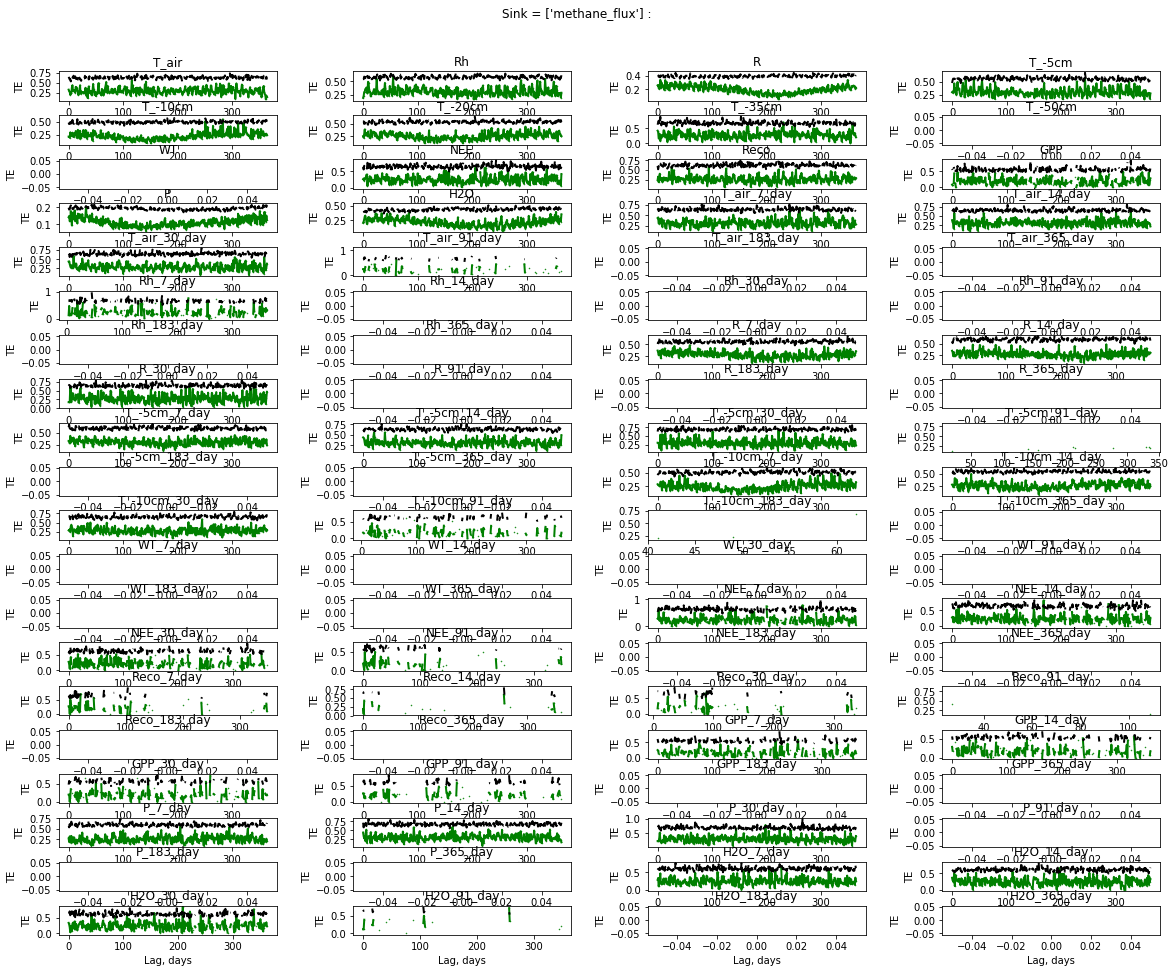

In [19]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[SourN[i]]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    if np.sum(~np.isnan(AboveCritic[i,:])):
        LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### Transformed, t-1

In [ ]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,10), np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([18]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

In [ ]:
# Applying TE on the anomaly data
#importlib.reload(TEpython3)

sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365,shift=sf)

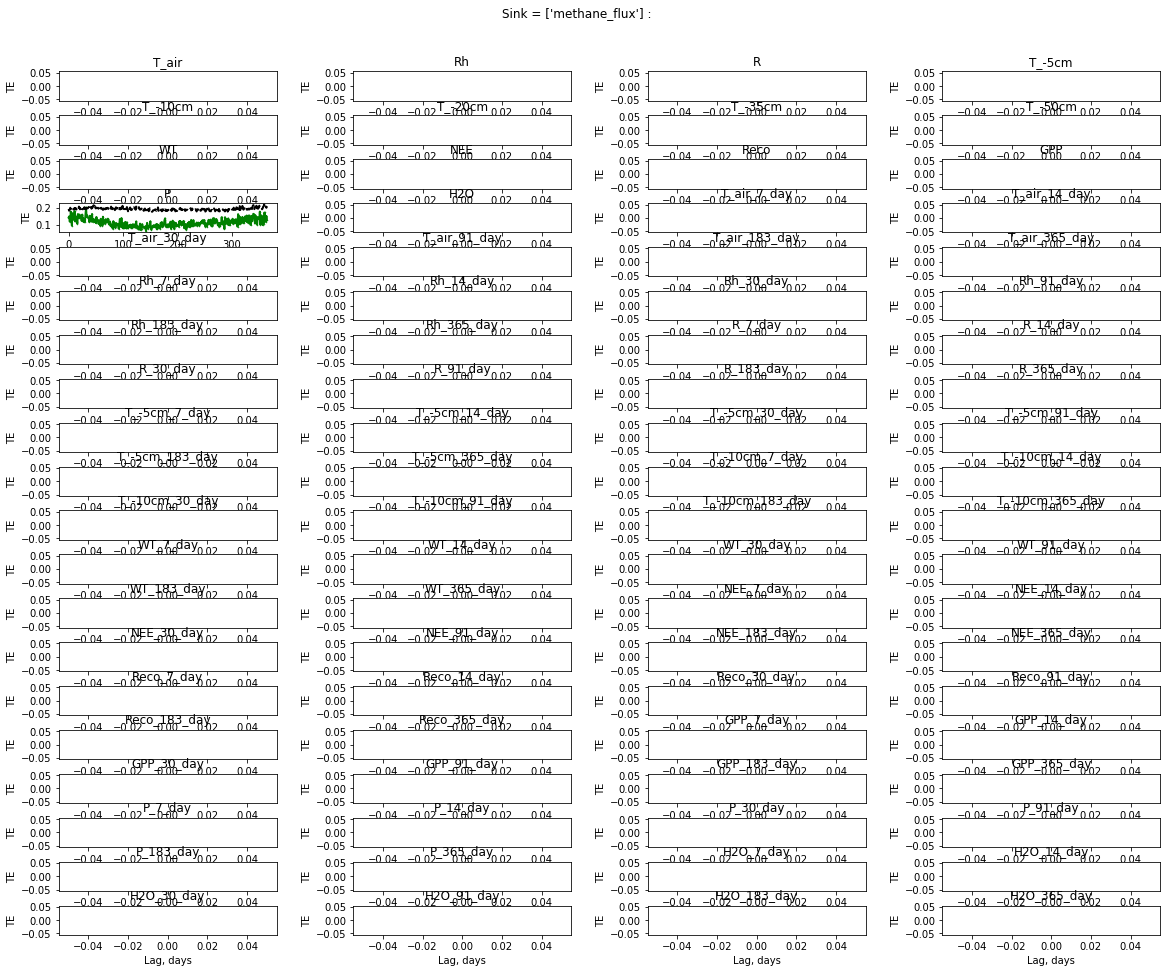

In [89]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[SourN[i]]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    if np.sum(~np.isnan(AboveCritic[i,:])):
        LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### Transformed, t-tau

In [ ]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,10), np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([18]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

In [ ]:
# Applying TE on the anomaly data
importlib.reload(TEpython3)

#sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365)

In [ ]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[SourN[i]]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### Non transformed, t-tau

In [129]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,13), 14:numVr]
SinN = np.array([13]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['DateTime' 'methane_flux' 'T_air' 'Rh' 'R' 'T_-5cm' 'T_-10cm' 'T_-20cm'
 'T_-35cm' 'T_-50cm' 'WT' 'NEE' 'Reco' 'GPP' 'P' 'T_air_7_day'
 'T_air_14_day' 'T_air_30_day' 'T_air_91_day' 'T_air_183_day'
 'T_air_365_day' 'Rh_7_day' 'Rh_14_day' 'Rh_30_day' 'Rh_91_day'
 'Rh_183_day' 'Rh_365_day' 'R_7_day' 'R_14_day' 'R_30_day' 'R_91_day'
 'R_183_day' 'R_365_day' 'T_-5cm_7_day' 'T_-5cm_14_day' 'T_-5cm_30_day'
 'T_-5cm_91_day' 'T_-5cm_183_day' 'T_-5cm_365_day' 'T_-10cm_7_day'
 'T_-10cm_14_day' 'T_-10cm_30_day' 'T_-10cm_91_day' 'T_-10cm_183_day'
 'T_-10cm_365_day' 'WT_7_day' 'WT_14_day' 'WT_30_day' 'WT_91_day'
 'WT_183_day' 'WT_365_day' 'NEE_7_day' 'NEE_14_day' 'NEE_30_day'
 'NEE_91_day' 'NEE_183_day' 'NEE_365_day' 'Reco_7_day' 'Reco_14_day'
 'Reco_30_day' 'Reco_91_day' 'Reco_183_day' 'Reco_365_day' 'GPP_7_day'
 'GPP_14_day' 'GPP_30_day' 'GPP_91_day' 'GPP_183_day' 'GPP_365_day'
 'P_7_day' 'P_14_day' 'P_30_day' 'P_91_day' 'P_183_day' 'P_365_day']


In [130]:
# Applying TE on the anomaly data
importlib.reload(TEpython3)

#sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
60 0 0
61 0 0
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 0 0
69 0 0
70 0 0
71 0 0
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 0 0
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 0 0
85 0 0
86 0 0
87 0 0
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 0 0
95 0 0
96 0 0
97 0 0
98 0 0
99 0 0
100 0 0
101 0 0
102 0 0
103 0 0
104 0 0
105 0 0
106 0 0
107 0 0
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 0 0
114 0 0
115 0 0
116 0 0
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
124 0 

305 0 2
306 0 2
307 0 2
308 0 2
309 0 2
310 0 2
311 0 2
312 0 2
313 0 2
314 0 2
315 0 2
316 0 2
317 0 2
318 0 2
319 0 2
320 0 2
321 0 2
322 0 2
323 0 2
324 0 2
325 0 2
326 0 2
327 0 2
328 0 2
329 0 2
330 0 2
331 0 2
332 0 2
333 0 2
334 0 2
335 0 2
336 0 2
337 0 2
338 0 2
339 0 2
340 0 2
341 0 2
342 0 2
343 0 2
344 0 2
345 0 2
346 0 2
347 0 2
348 0 2
349 0 2
350 0 2
351 0 2
352 0 2
353 0 2
354 0 2
355 0 2
356 0 2
357 0 2
358 0 2
359 0 2
360 0 2
361 0 2
362 0 2
363 0 2
364 0 2
Source node  3 T_-5cm :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
12 0 3
13 0 3
14 0 3
15 0 3
16 0 3
17 0 3
18 0 3
19 0 3
20 0 3
21 0 3
22 0 3
23 0 3
24 0 3
25 0 3
26 0 3
27 0 3
28 0 3
29 0 3
30 0 3
31 0 3
32 0 3
33 0 3
34 0 3
35 0 3
36 0 3
37 0 3
38 0 3
39 0 3
40 0 3
41 0 3
42 0 3
43 0 3
44 0 3
45 0 3
46 0 3
47 0 3
48 0 3
49 0 3
50 0 3
51 0 3
52 0 3
53 0 3
54 0 3
55 0 3
56 0 3
57 0 3
58 0 3
59 0 3
60 0 3
61 0 3
62 0 3
63 0 3
64 0 3
65 0 

250 0 5
251 0 5
252 0 5
253 0 5
254 0 5
255 0 5
256 0 5
257 0 5
258 0 5
259 0 5
260 0 5
261 0 5
262 0 5
263 0 5
264 0 5
265 0 5
266 0 5
267 0 5
268 0 5
269 0 5
270 0 5
271 0 5
272 0 5
273 0 5
274 0 5
275 0 5
276 0 5
277 0 5
278 0 5
279 0 5
280 0 5
281 0 5
282 0 5
283 0 5
284 0 5
285 0 5
286 0 5
287 0 5
288 0 5
289 0 5
290 0 5
291 0 5
292 0 5
293 0 5
294 0 5
295 0 5
296 0 5
297 0 5
298 0 5
299 0 5
300 0 5
301 0 5
302 0 5
303 0 5
304 0 5
305 0 5
306 0 5
307 0 5
308 0 5
309 0 5
310 0 5
311 0 5
312 0 5
313 0 5
314 0 5
315 0 5
316 0 5
317 0 5
318 0 5
319 0 5
320 0 5
321 0 5
322 0 5
323 0 5
324 0 5
325 0 5
326 0 5
327 0 5
328 0 5
329 0 5
330 0 5
331 0 5
332 0 5
333 0 5
334 0 5
335 0 5
336 0 5
337 0 5
338 0 5
339 0 5
340 0 5
341 0 5
342 0 5
343 0 5
344 0 5
345 0 5
346 0 5
347 0 5
348 0 5
349 0 5
350 0 5
351 0 5
352 0 5
353 0 5
354 0 5
355 0 5
356 0 5
357 0 5
358 0 5
359 0 5
360 0 5
361 0 5
362 0 5
363 0 5
364 0 5
Source node  6 T_-35cm :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 6
1 0

196 0 8
197 0 8
198 0 8
199 0 8
200 0 8
201 0 8
202 0 8
203 0 8
204 0 8
205 0 8
206 0 8
207 0 8
208 0 8
209 0 8
210 0 8
211 0 8
212 0 8
213 0 8
214 0 8
215 0 8
216 0 8
217 0 8
218 0 8
219 0 8
220 0 8
221 0 8
222 0 8
223 0 8
224 0 8
225 0 8
226 0 8
227 0 8
228 0 8
229 0 8
230 0 8
231 0 8
232 0 8
233 0 8
234 0 8
235 0 8
236 0 8
237 0 8
238 0 8
239 0 8
240 0 8
241 0 8
242 0 8
243 0 8
244 0 8
245 0 8
246 0 8
247 0 8
248 0 8
249 0 8
250 0 8
251 0 8
252 0 8
253 0 8
254 0 8
255 0 8
256 0 8
257 0 8
258 0 8
259 0 8
260 0 8
261 0 8
262 0 8
263 0 8
264 0 8
265 0 8
266 0 8
267 0 8
268 0 8
269 0 8
270 0 8
271 0 8
272 0 8
273 0 8
274 0 8
275 0 8
276 0 8
277 0 8
278 0 8
279 0 8
280 0 8
281 0 8
282 0 8
283 0 8
284 0 8
285 0 8
286 0 8
287 0 8
288 0 8
289 0 8
290 0 8
291 0 8
292 0 8
293 0 8
294 0 8
295 0 8
296 0 8
297 0 8
298 0 8
299 0 8
300 0 8
301 0 8
302 0 8
303 0 8
304 0 8
305 0 8
306 0 8
307 0 8
308 0 8
309 0 8
310 0 8
311 0 8
312 0 8
313 0 8
314 0 8
315 0 8
316 0 8
317 0 8
318 0 8
319 0 8
320 0 8


83 0 11
84 0 11
85 0 11
86 0 11
87 0 11
88 0 11
89 0 11
90 0 11
91 0 11
92 0 11
93 0 11
94 0 11
95 0 11
96 0 11
97 0 11
98 0 11
99 0 11
100 0 11
101 0 11
102 0 11
103 0 11
104 0 11
105 0 11
106 0 11
107 0 11
108 0 11
109 0 11
110 0 11
111 0 11
112 0 11
113 0 11
114 0 11
115 0 11
116 0 11
117 0 11
118 0 11
119 0 11
120 0 11
121 0 11
122 0 11
123 0 11
124 0 11
125 0 11
126 0 11
127 0 11
128 0 11
129 0 11
130 0 11
131 0 11
132 0 11
133 0 11
134 0 11
135 0 11
136 0 11
137 0 11
138 0 11
139 0 11
140 0 11
141 0 11
142 0 11
143 0 11
144 0 11
145 0 11
146 0 11
147 0 11
148 0 11
149 0 11
150 0 11
151 0 11
152 0 11
153 0 11
154 0 11
155 0 11
156 0 11
157 0 11
158 0 11
159 0 11
160 0 11
161 0 11
162 0 11
163 0 11
164 0 11
165 0 11
166 0 11
167 0 11
168 0 11
169 0 11
170 0 11
171 0 11
172 0 11
173 0 11
174 0 11
175 0 11
176 0 11
177 0 11
178 0 11
179 0 11
180 0 11
181 0 11
182 0 11
183 0 11
184 0 11
185 0 11
186 0 11
187 0 11
188 0 11
189 0 11
190 0 11
191 0 11
192 0 11
193 0 11
194 0 11
195 0 11


274 0 13
275 0 13
276 0 13
277 0 13
278 0 13
279 0 13
280 0 13
281 0 13
282 0 13
283 0 13
284 0 13
285 0 13
286 0 13
287 0 13
288 0 13
289 0 13
290 0 13
291 0 13
292 0 13
293 0 13
294 0 13
295 0 13
296 0 13
297 0 13
298 0 13
299 0 13
300 0 13
301 0 13
302 0 13
303 0 13
304 0 13
305 0 13
306 0 13
307 0 13
308 0 13
309 0 13
310 0 13
311 0 13
312 0 13
313 0 13
314 0 13
315 0 13
316 0 13
317 0 13
318 0 13
319 0 13
320 0 13
321 0 13
322 0 13
323 0 13
324 0 13
325 0 13
326 0 13
327 0 13
328 0 13
329 0 13
330 0 13
331 0 13
332 0 13
333 0 13
334 0 13
335 0 13
336 0 13
337 0 13
338 0 13
339 0 13
340 0 13
341 0 13
342 0 13
343 0 13
344 0 13
345 0 13
346 0 13
347 0 13
348 0 13
349 0 13
350 0 13
351 0 13
352 0 13
353 0 13
354 0 13
355 0 13
356 0 13
357 0 13
358 0 13
359 0 13
360 0 13
361 0 13
362 0 13
363 0 13
364 0 13
Source node  15 T_air_14_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 14
1 0 14
2 0 14
3 0 14
4 0 14
5 0 14
6 0 14
7 0 14
8 0 14
9 0 14
10 0 14
11 0 14
12 0 14
13 0 14
14

102 0 16
103 0 16
104 0 16
105 0 16
106 0 16
107 0 16
108 0 16
109 0 16
110 0 16
111 0 16
112 0 16
113 0 16
114 0 16
115 0 16
116 0 16
117 0 16
118 0 16
119 0 16
120 0 16
121 0 16
122 0 16
123 0 16
124 0 16
125 0 16
126 0 16
127 0 16
128 0 16
129 0 16
130 0 16
131 0 16
132 0 16
133 0 16
134 0 16
135 0 16
136 0 16
137 0 16
138 0 16
139 0 16
140 0 16
141 0 16
142 0 16
143 0 16
144 0 16
145 0 16
146 0 16
147 0 16
148 0 16
149 0 16
150 0 16
151 0 16
152 0 16
153 0 16
154 0 16
155 0 16
156 0 16
157 0 16
158 0 16
159 0 16
160 0 16
161 0 16
162 0 16
163 0 16
164 0 16
165 0 16
166 0 16
167 0 16
168 0 16
169 0 16
170 0 16
171 0 16
172 0 16
173 0 16
174 0 16
175 0 16
176 0 16
177 0 16
178 0 16
179 0 16
180 0 16
181 0 16
182 0 16
183 0 16
184 0 16
185 0 16
186 0 16
187 0 16
188 0 16
189 0 16
190 0 16
191 0 16
192 0 16
193 0 16
194 0 16
195 0 16
196 0 16
197 0 16
198 0 16
199 0 16
200 0 16
201 0 16
202 0 16
203 0 16
204 0 16
205 0 16
206 0 16
207 0 16
208 0 16
209 0 16
210 0 16
211 0 16
212 0 16
2

291 0 18
292 0 18
293 0 18
294 0 18
295 0 18
296 0 18
297 0 18
298 0 18
299 0 18
300 0 18
301 0 18
302 0 18
303 0 18
304 0 18
305 0 18
306 0 18
307 0 18
308 0 18
309 0 18
310 0 18
311 0 18
312 0 18
313 0 18
314 0 18
315 0 18
316 0 18
317 0 18
318 0 18
319 0 18
320 0 18
321 0 18
322 0 18
323 0 18
324 0 18
325 0 18
326 0 18
327 0 18
328 0 18
329 0 18
330 0 18
331 0 18
332 0 18
333 0 18
334 0 18
335 0 18
336 0 18
337 0 18
338 0 18
339 0 18
340 0 18
341 0 18
342 0 18
343 0 18
344 0 18
345 0 18
346 0 18
347 0 18
348 0 18
349 0 18
350 0 18
351 0 18
352 0 18
353 0 18
354 0 18
355 0 18
356 0 18
357 0 18
358 0 18
359 0 18
360 0 18
361 0 18
362 0 18
363 0 18
364 0 18
Source node  20 Rh_7_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 19
1 0 19
2 0 19
3 0 19
4 0 19
5 0 19
6 0 19
7 0 19
8 0 19
9 0 19
10 0 19
11 0 19
12 0 19
13 0 19
14 0 19
15 0 19
16 0 19
17 0 19
18 0 19
19 0 19
20 0 19
21 0 19
22 0 19
23 0 19
24 0 19
25 0 19
26 0 19
27 0 19
28 0 19
29 0 19
30 0 19
31 0 19
32 0 19
33 0 19

119 0 21
120 0 21
121 0 21
122 0 21
123 0 21
124 0 21
125 0 21
126 0 21
127 0 21
128 0 21
129 0 21
130 0 21
131 0 21
132 0 21
133 0 21
134 0 21
135 0 21
136 0 21
137 0 21
138 0 21
139 0 21
140 0 21
141 0 21
142 0 21
143 0 21
144 0 21
145 0 21
146 0 21
147 0 21
148 0 21
149 0 21
150 0 21
151 0 21
152 0 21
153 0 21
154 0 21
155 0 21
156 0 21
157 0 21
158 0 21
159 0 21
160 0 21
161 0 21
162 0 21
163 0 21
164 0 21
165 0 21
166 0 21
167 0 21
168 0 21
169 0 21
170 0 21
171 0 21
172 0 21
173 0 21
174 0 21
175 0 21
176 0 21
177 0 21
178 0 21
179 0 21
180 0 21
181 0 21
182 0 21
183 0 21
184 0 21
185 0 21
186 0 21
187 0 21
188 0 21
189 0 21
190 0 21
191 0 21
192 0 21
193 0 21
194 0 21
195 0 21
196 0 21
197 0 21
198 0 21
199 0 21
200 0 21
201 0 21
202 0 21
203 0 21
204 0 21
205 0 21
206 0 21
207 0 21
208 0 21
209 0 21
210 0 21
211 0 21
212 0 21
213 0 21
214 0 21
215 0 21
216 0 21
217 0 21
218 0 21
219 0 21
220 0 21
221 0 21
222 0 21
223 0 21
224 0 21
225 0 21
226 0 21
227 0 21
228 0 21
229 0 21
2

309 0 23
310 0 23
311 0 23
312 0 23
313 0 23
314 0 23
315 0 23
316 0 23
317 0 23
318 0 23
319 0 23
320 0 23
321 0 23
322 0 23
323 0 23
324 0 23
325 0 23
326 0 23
327 0 23
328 0 23
329 0 23
330 0 23
331 0 23
332 0 23
333 0 23
334 0 23
335 0 23
336 0 23
337 0 23
338 0 23
339 0 23
340 0 23
341 0 23
342 0 23
343 0 23
344 0 23
345 0 23
346 0 23
347 0 23
348 0 23
349 0 23
350 0 23
351 0 23
352 0 23
353 0 23
354 0 23
355 0 23
356 0 23
357 0 23
358 0 23
359 0 23
360 0 23
361 0 23
362 0 23
363 0 23
364 0 23
Source node  25 Rh_365_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 24
1 0 24
2 0 24
3 0 24
4 0 24
5 0 24
6 0 24
7 0 24
8 0 24
9 0 24
10 0 24
11 0 24
12 0 24
13 0 24
14 0 24
15 0 24
16 0 24
17 0 24
18 0 24
19 0 24
20 0 24
21 0 24
22 0 24
23 0 24
24 0 24
25 0 24
26 0 24
27 0 24
28 0 24
29 0 24
30 0 24
31 0 24
32 0 24
33 0 24
34 0 24
35 0 24
36 0 24
37 0 24
38 0 24
39 0 24
40 0 24
41 0 24
42 0 24
43 0 24
44 0 24
45 0 24
46 0 24
47 0 24
48 0 24
49 0 24
50 0 24
51 0 24
52 0 24
53 0 24

137 0 26
138 0 26
139 0 26
140 0 26
141 0 26
142 0 26
143 0 26
144 0 26
145 0 26
146 0 26
147 0 26
148 0 26
149 0 26
150 0 26
151 0 26
152 0 26
153 0 26
154 0 26
155 0 26
156 0 26
157 0 26
158 0 26
159 0 26
160 0 26
161 0 26
162 0 26
163 0 26
164 0 26
165 0 26
166 0 26
167 0 26
168 0 26
169 0 26
170 0 26
171 0 26
172 0 26
173 0 26
174 0 26
175 0 26
176 0 26
177 0 26
178 0 26
179 0 26
180 0 26
181 0 26
182 0 26
183 0 26
184 0 26
185 0 26
186 0 26
187 0 26
188 0 26
189 0 26
190 0 26
191 0 26
192 0 26
193 0 26
194 0 26
195 0 26
196 0 26
197 0 26
198 0 26
199 0 26
200 0 26
201 0 26
202 0 26
203 0 26
204 0 26
205 0 26
206 0 26
207 0 26
208 0 26
209 0 26
210 0 26
211 0 26
212 0 26
213 0 26
214 0 26
215 0 26
216 0 26
217 0 26
218 0 26
219 0 26
220 0 26
221 0 26
222 0 26
223 0 26
224 0 26
225 0 26
226 0 26
227 0 26
228 0 26
229 0 26
230 0 26
231 0 26
232 0 26
233 0 26
234 0 26
235 0 26
236 0 26
237 0 26
238 0 26
239 0 26
240 0 26
241 0 26
242 0 26
243 0 26
244 0 26
245 0 26
246 0 26
247 0 26
2

327 0 28
328 0 28
329 0 28
330 0 28
331 0 28
332 0 28
333 0 28
334 0 28
335 0 28
336 0 28
337 0 28
338 0 28
339 0 28
340 0 28
341 0 28
342 0 28
343 0 28
344 0 28
345 0 28
346 0 28
347 0 28
348 0 28
349 0 28
350 0 28
351 0 28
352 0 28
353 0 28
354 0 28
355 0 28
356 0 28
357 0 28
358 0 28
359 0 28
360 0 28
361 0 28
362 0 28
363 0 28
364 0 28
Source node  30 R_183_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 29
1 0 29
2 0 29
3 0 29
4 0 29
5 0 29
6 0 29
7 0 29
8 0 29
9 0 29
10 0 29
11 0 29
12 0 29
13 0 29
14 0 29
15 0 29
16 0 29
17 0 29
18 0 29
19 0 29
20 0 29
21 0 29
22 0 29
23 0 29
24 0 29
25 0 29
26 0 29
27 0 29
28 0 29
29 0 29
30 0 29
31 0 29
32 0 29
33 0 29
34 0 29
35 0 29
36 0 29
37 0 29
38 0 29
39 0 29
40 0 29
41 0 29
42 0 29
43 0 29
44 0 29
45 0 29
46 0 29
47 0 29
48 0 29
49 0 29
50 0 29
51 0 29
52 0 29
53 0 29
54 0 29
55 0 29
56 0 29
57 0 29
58 0 29
59 0 29
60 0 29
61 0 29
62 0 29
63 0 29
64 0 29
65 0 29
66 0 29
67 0 29
68 0 29
69 0 29
70 0 29
71 0 29
72 0 29
73 0 29
74

154 0 31
155 0 31
156 0 31
157 0 31
158 0 31
159 0 31
160 0 31
161 0 31
162 0 31
163 0 31
164 0 31
165 0 31
166 0 31
167 0 31
168 0 31
169 0 31
170 0 31
171 0 31
172 0 31
173 0 31
174 0 31
175 0 31
176 0 31
177 0 31
178 0 31
179 0 31
180 0 31
181 0 31
182 0 31
183 0 31
184 0 31
185 0 31
186 0 31
187 0 31
188 0 31
189 0 31
190 0 31
191 0 31
192 0 31
193 0 31
194 0 31
195 0 31
196 0 31
197 0 31
198 0 31
199 0 31
200 0 31
201 0 31
202 0 31
203 0 31
204 0 31
205 0 31
206 0 31
207 0 31
208 0 31
209 0 31
210 0 31
211 0 31
212 0 31
213 0 31
214 0 31
215 0 31
216 0 31
217 0 31
218 0 31
219 0 31
220 0 31
221 0 31
222 0 31
223 0 31
224 0 31
225 0 31
226 0 31
227 0 31
228 0 31
229 0 31
230 0 31
231 0 31
232 0 31
233 0 31
234 0 31
235 0 31
236 0 31
237 0 31
238 0 31
239 0 31
240 0 31
241 0 31
242 0 31
243 0 31
244 0 31
245 0 31
246 0 31
247 0 31
248 0 31
249 0 31
250 0 31
251 0 31
252 0 31
253 0 31
254 0 31
255 0 31
256 0 31
257 0 31
258 0 31
259 0 31
260 0 31
261 0 31
262 0 31
263 0 31
264 0 31
2

342 0 33
343 0 33
344 0 33
345 0 33
346 0 33
347 0 33
348 0 33
349 0 33
350 0 33
351 0 33
352 0 33
353 0 33
354 0 33
355 0 33
356 0 33
357 0 33
358 0 33
359 0 33
360 0 33
361 0 33
362 0 33
363 0 33
364 0 33
Source node  35 T_-5cm_91_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 34
1 0 34
2 0 34
3 0 34
4 0 34
5 0 34
6 0 34
7 0 34
8 0 34
9 0 34
10 0 34
11 0 34
12 0 34
13 0 34
14 0 34
15 0 34
16 0 34
17 0 34
18 0 34
19 0 34
20 0 34
21 0 34
22 0 34
23 0 34
24 0 34
25 0 34
26 0 34
27 0 34
28 0 34
29 0 34
30 0 34
31 0 34
32 0 34
33 0 34
34 0 34
35 0 34
36 0 34
37 0 34
38 0 34
39 0 34
40 0 34
41 0 34
42 0 34
43 0 34
44 0 34
45 0 34
46 0 34
47 0 34
48 0 34
49 0 34
50 0 34
51 0 34
52 0 34
53 0 34
54 0 34
55 0 34
56 0 34
57 0 34
58 0 34
59 0 34
60 0 34
61 0 34
62 0 34
63 0 34
64 0 34
65 0 34
66 0 34
67 0 34
68 0 34
69 0 34
70 0 34
71 0 34
72 0 34
73 0 34
74 0 34
75 0 34
76 0 34
77 0 34
78 0 34
79 0 34
80 0 34
81 0 34
82 0 34
83 0 34
84 0 34
85 0 34
86 0 34
87 0 34
88 0 34
89 0 34
90 0 

169 0 36
170 0 36
171 0 36
172 0 36
173 0 36
174 0 36
175 0 36
176 0 36
177 0 36
178 0 36
179 0 36
180 0 36
181 0 36
182 0 36
183 0 36
184 0 36
185 0 36
186 0 36
187 0 36
188 0 36
189 0 36
190 0 36
191 0 36
192 0 36
193 0 36
194 0 36
195 0 36
196 0 36
197 0 36
198 0 36
199 0 36
200 0 36
201 0 36
202 0 36
203 0 36
204 0 36
205 0 36
206 0 36
207 0 36
208 0 36
209 0 36
210 0 36
211 0 36
212 0 36
213 0 36
214 0 36
215 0 36
216 0 36
217 0 36
218 0 36
219 0 36
220 0 36
221 0 36
222 0 36
223 0 36
224 0 36
225 0 36
226 0 36
227 0 36
228 0 36
229 0 36
230 0 36
231 0 36
232 0 36
233 0 36
234 0 36
235 0 36
236 0 36
237 0 36
238 0 36
239 0 36
240 0 36
241 0 36
242 0 36
243 0 36
244 0 36
245 0 36
246 0 36
247 0 36
248 0 36
249 0 36
250 0 36
251 0 36
252 0 36
253 0 36
254 0 36
255 0 36
256 0 36
257 0 36
258 0 36
259 0 36
260 0 36
261 0 36
262 0 36
263 0 36
264 0 36
265 0 36
266 0 36
267 0 36
268 0 36
269 0 36
270 0 36
271 0 36
272 0 36
273 0 36
274 0 36
275 0 36
276 0 36
277 0 36
278 0 36
279 0 36
2

358 0 38
359 0 38
360 0 38
361 0 38
362 0 38
363 0 38
364 0 38
Source node  40 T_-10cm_30_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 39
1 0 39
2 0 39
3 0 39
4 0 39
5 0 39
6 0 39
7 0 39
8 0 39
9 0 39
10 0 39
11 0 39
12 0 39
13 0 39
14 0 39
15 0 39
16 0 39
17 0 39
18 0 39
19 0 39
20 0 39
21 0 39
22 0 39
23 0 39
24 0 39
25 0 39
26 0 39
27 0 39
28 0 39
29 0 39
30 0 39
31 0 39
32 0 39
33 0 39
34 0 39
35 0 39
36 0 39
37 0 39
38 0 39
39 0 39
40 0 39
41 0 39
42 0 39
43 0 39
44 0 39
45 0 39
46 0 39
47 0 39
48 0 39
49 0 39
50 0 39
51 0 39
52 0 39
53 0 39
54 0 39
55 0 39
56 0 39
57 0 39
58 0 39
59 0 39
60 0 39
61 0 39
62 0 39
63 0 39
64 0 39
65 0 39
66 0 39
67 0 39
68 0 39
69 0 39
70 0 39
71 0 39
72 0 39
73 0 39
74 0 39
75 0 39
76 0 39
77 0 39
78 0 39
79 0 39
80 0 39
81 0 39
82 0 39
83 0 39
84 0 39
85 0 39
86 0 39
87 0 39
88 0 39
89 0 39
90 0 39
91 0 39
92 0 39
93 0 39
94 0 39
95 0 39
96 0 39
97 0 39
98 0 39
99 0 39
100 0 39
101 0 39
102 0 39
103 0 39
104 0 39
105 0 39
106 0 39
107 0

185 0 41
186 0 41
187 0 41
188 0 41
189 0 41
190 0 41
191 0 41
192 0 41
193 0 41
194 0 41
195 0 41
196 0 41
197 0 41
198 0 41
199 0 41
200 0 41
201 0 41
202 0 41
203 0 41
204 0 41
205 0 41
206 0 41
207 0 41
208 0 41
209 0 41
210 0 41
211 0 41
212 0 41
213 0 41
214 0 41
215 0 41
216 0 41
217 0 41
218 0 41
219 0 41
220 0 41
221 0 41
222 0 41
223 0 41
224 0 41
225 0 41
226 0 41
227 0 41
228 0 41
229 0 41
230 0 41
231 0 41
232 0 41
233 0 41
234 0 41
235 0 41
236 0 41
237 0 41
238 0 41
239 0 41
240 0 41
241 0 41
242 0 41
243 0 41
244 0 41
245 0 41
246 0 41
247 0 41
248 0 41
249 0 41
250 0 41
251 0 41
252 0 41
253 0 41
254 0 41
255 0 41
256 0 41
257 0 41
258 0 41
259 0 41
260 0 41
261 0 41
262 0 41
263 0 41
264 0 41
265 0 41
266 0 41
267 0 41
268 0 41
269 0 41
270 0 41
271 0 41
272 0 41
273 0 41
274 0 41
275 0 41
276 0 41
277 0 41
278 0 41
279 0 41
280 0 41
281 0 41
282 0 41
283 0 41
284 0 41
285 0 41
286 0 41
287 0 41
288 0 41
289 0 41
290 0 41
291 0 41
292 0 41
293 0 41
294 0 41
295 0 41
2

0 0 44
1 0 44
2 0 44
3 0 44
4 0 44
5 0 44
6 0 44
7 0 44
8 0 44
9 0 44
10 0 44
11 0 44
12 0 44
13 0 44
14 0 44
15 0 44
16 0 44
17 0 44
18 0 44
19 0 44
20 0 44
21 0 44
22 0 44
23 0 44
24 0 44
25 0 44
26 0 44
27 0 44
28 0 44
29 0 44
30 0 44
31 0 44
32 0 44
33 0 44
34 0 44
35 0 44
36 0 44
37 0 44
38 0 44
39 0 44
40 0 44
41 0 44
42 0 44
43 0 44
44 0 44
45 0 44
46 0 44
47 0 44
48 0 44
49 0 44
50 0 44
51 0 44
52 0 44
53 0 44
54 0 44
55 0 44
56 0 44
57 0 44
58 0 44
59 0 44
60 0 44
61 0 44
62 0 44
63 0 44
64 0 44
65 0 44
66 0 44
67 0 44
68 0 44
69 0 44
70 0 44
71 0 44
72 0 44
73 0 44
74 0 44
75 0 44
76 0 44
77 0 44
78 0 44
79 0 44
80 0 44
81 0 44
82 0 44
83 0 44
84 0 44
85 0 44
86 0 44
87 0 44
88 0 44
89 0 44
90 0 44
91 0 44
92 0 44
93 0 44
94 0 44
95 0 44
96 0 44
97 0 44
98 0 44
99 0 44
100 0 44
101 0 44
102 0 44
103 0 44
104 0 44
105 0 44
106 0 44
107 0 44
108 0 44
109 0 44
110 0 44
111 0 44
112 0 44
113 0 44
114 0 44
115 0 44
116 0 44
117 0 44
118 0 44
119 0 44
120 0 44
121 0 44
122 0 44
123

202 0 46
203 0 46
204 0 46
205 0 46
206 0 46
207 0 46
208 0 46
209 0 46
210 0 46
211 0 46
212 0 46
213 0 46
214 0 46
215 0 46
216 0 46
217 0 46
218 0 46
219 0 46
220 0 46
221 0 46
222 0 46
223 0 46
224 0 46
225 0 46
226 0 46
227 0 46
228 0 46
229 0 46
230 0 46
231 0 46
232 0 46
233 0 46
234 0 46
235 0 46
236 0 46
237 0 46
238 0 46
239 0 46
240 0 46
241 0 46
242 0 46
243 0 46
244 0 46
245 0 46
246 0 46
247 0 46
248 0 46
249 0 46
250 0 46
251 0 46
252 0 46
253 0 46
254 0 46
255 0 46
256 0 46
257 0 46
258 0 46
259 0 46
260 0 46
261 0 46
262 0 46
263 0 46
264 0 46
265 0 46
266 0 46
267 0 46
268 0 46
269 0 46
270 0 46
271 0 46
272 0 46
273 0 46
274 0 46
275 0 46
276 0 46
277 0 46
278 0 46
279 0 46
280 0 46
281 0 46
282 0 46
283 0 46
284 0 46
285 0 46
286 0 46
287 0 46
288 0 46
289 0 46
290 0 46
291 0 46
292 0 46
293 0 46
294 0 46
295 0 46
296 0 46
297 0 46
298 0 46
299 0 46
300 0 46
301 0 46
302 0 46
303 0 46
304 0 46
305 0 46
306 0 46
307 0 46
308 0 46
309 0 46
310 0 46
311 0 46
312 0 46
3

22 0 49
23 0 49
24 0 49
25 0 49
26 0 49
27 0 49
28 0 49
29 0 49
30 0 49
31 0 49
32 0 49
33 0 49
34 0 49
35 0 49
36 0 49
37 0 49
38 0 49
39 0 49
40 0 49
41 0 49
42 0 49
43 0 49
44 0 49
45 0 49
46 0 49
47 0 49
48 0 49
49 0 49
50 0 49
51 0 49
52 0 49
53 0 49
54 0 49
55 0 49
56 0 49
57 0 49
58 0 49
59 0 49
60 0 49
61 0 49
62 0 49
63 0 49
64 0 49
65 0 49
66 0 49
67 0 49
68 0 49
69 0 49
70 0 49
71 0 49
72 0 49
73 0 49
74 0 49
75 0 49
76 0 49
77 0 49
78 0 49
79 0 49
80 0 49
81 0 49
82 0 49
83 0 49
84 0 49
85 0 49
86 0 49
87 0 49
88 0 49
89 0 49
90 0 49
91 0 49
92 0 49
93 0 49
94 0 49
95 0 49
96 0 49
97 0 49
98 0 49
99 0 49
100 0 49
101 0 49
102 0 49
103 0 49
104 0 49
105 0 49
106 0 49
107 0 49
108 0 49
109 0 49
110 0 49
111 0 49
112 0 49
113 0 49
114 0 49
115 0 49
116 0 49
117 0 49
118 0 49
119 0 49
120 0 49
121 0 49
122 0 49
123 0 49
124 0 49
125 0 49
126 0 49
127 0 49
128 0 49
129 0 49
130 0 49
131 0 49
132 0 49
133 0 49
134 0 49
135 0 49
136 0 49
137 0 49
138 0 49
139 0 49
140 0 49
141 0 4

219 0 51
220 0 51
221 0 51
222 0 51
223 0 51
224 0 51
225 0 51
226 0 51
227 0 51
228 0 51
229 0 51
230 0 51
231 0 51
232 0 51
233 0 51
234 0 51
235 0 51
236 0 51
237 0 51
238 0 51
239 0 51
240 0 51
241 0 51
242 0 51
243 0 51
244 0 51
245 0 51
246 0 51
247 0 51
248 0 51
249 0 51
250 0 51
251 0 51
252 0 51
253 0 51
254 0 51
255 0 51
256 0 51
257 0 51
258 0 51
259 0 51
260 0 51
261 0 51
262 0 51
263 0 51
264 0 51
265 0 51
266 0 51
267 0 51
268 0 51
269 0 51
270 0 51
271 0 51
272 0 51
273 0 51
274 0 51
275 0 51
276 0 51
277 0 51
278 0 51
279 0 51
280 0 51
281 0 51
282 0 51
283 0 51
284 0 51
285 0 51
286 0 51
287 0 51
288 0 51
289 0 51
290 0 51
291 0 51
292 0 51
293 0 51
294 0 51
295 0 51
296 0 51
297 0 51
298 0 51
299 0 51
300 0 51
301 0 51
302 0 51
303 0 51
304 0 51
305 0 51
306 0 51
307 0 51
308 0 51
309 0 51
310 0 51
311 0 51
312 0 51
313 0 51
314 0 51
315 0 51
316 0 51
317 0 51
318 0 51
319 0 51
320 0 51
321 0 51
322 0 51
323 0 51
324 0 51
325 0 51
326 0 51
327 0 51
328 0 51
329 0 51
3

40 0 54
41 0 54
42 0 54
43 0 54
44 0 54
45 0 54
46 0 54
47 0 54
48 0 54
49 0 54
50 0 54
51 0 54
52 0 54
53 0 54
54 0 54
55 0 54
56 0 54
57 0 54
58 0 54
59 0 54
60 0 54
61 0 54
62 0 54
63 0 54
64 0 54
65 0 54
66 0 54
67 0 54
68 0 54
69 0 54
70 0 54
71 0 54
72 0 54
73 0 54
74 0 54
75 0 54
76 0 54
77 0 54
78 0 54
79 0 54
80 0 54
81 0 54
82 0 54
83 0 54
84 0 54
85 0 54
86 0 54
87 0 54
88 0 54
89 0 54
90 0 54
91 0 54
92 0 54
93 0 54
94 0 54
95 0 54
96 0 54
97 0 54
98 0 54
99 0 54
100 0 54
101 0 54
102 0 54
103 0 54
104 0 54
105 0 54
106 0 54
107 0 54
108 0 54
109 0 54
110 0 54
111 0 54
112 0 54
113 0 54
114 0 54
115 0 54
116 0 54
117 0 54
118 0 54
119 0 54
120 0 54
121 0 54
122 0 54
123 0 54
124 0 54
125 0 54
126 0 54
127 0 54
128 0 54
129 0 54
130 0 54
131 0 54
132 0 54
133 0 54
134 0 54
135 0 54
136 0 54
137 0 54
138 0 54
139 0 54
140 0 54
141 0 54
142 0 54
143 0 54
144 0 54
145 0 54
146 0 54
147 0 54
148 0 54
149 0 54
150 0 54
151 0 54
152 0 54
153 0 54
154 0 54
155 0 54
156 0 54
157 0 5

235 0 56
236 0 56
237 0 56
238 0 56
239 0 56
240 0 56
241 0 56
242 0 56
243 0 56
244 0 56
245 0 56
246 0 56
247 0 56
248 0 56
249 0 56
250 0 56
251 0 56
252 0 56
253 0 56
254 0 56
255 0 56
256 0 56
257 0 56
258 0 56
259 0 56
260 0 56
261 0 56
262 0 56
263 0 56
264 0 56
265 0 56
266 0 56
267 0 56
268 0 56
269 0 56
270 0 56
271 0 56
272 0 56
273 0 56
274 0 56
275 0 56
276 0 56
277 0 56
278 0 56
279 0 56
280 0 56
281 0 56
282 0 56
283 0 56
284 0 56
285 0 56
286 0 56
287 0 56
288 0 56
289 0 56
290 0 56
291 0 56
292 0 56
293 0 56
294 0 56
295 0 56
296 0 56
297 0 56
298 0 56
299 0 56
300 0 56
301 0 56
302 0 56
303 0 56
304 0 56
305 0 56
306 0 56
307 0 56
308 0 56
309 0 56
310 0 56
311 0 56
312 0 56
313 0 56
314 0 56
315 0 56
316 0 56
317 0 56
318 0 56
319 0 56
320 0 56
321 0 56
322 0 56
323 0 56
324 0 56
325 0 56
326 0 56
327 0 56
328 0 56
329 0 56
330 0 56
331 0 56
332 0 56
333 0 56
334 0 56
335 0 56
336 0 56
337 0 56
338 0 56
339 0 56
340 0 56
341 0 56
342 0 56
343 0 56
344 0 56
345 0 56
3

57 0 59
58 0 59
59 0 59
60 0 59
61 0 59
62 0 59
63 0 59
64 0 59
65 0 59
66 0 59
67 0 59
68 0 59
69 0 59
70 0 59
71 0 59
72 0 59
73 0 59
74 0 59
75 0 59
76 0 59
77 0 59
78 0 59
79 0 59
80 0 59
81 0 59
82 0 59
83 0 59
84 0 59
85 0 59
86 0 59
87 0 59
88 0 59
89 0 59
90 0 59
91 0 59
92 0 59
93 0 59
94 0 59
95 0 59
96 0 59
97 0 59
98 0 59
99 0 59
100 0 59
101 0 59
102 0 59
103 0 59
104 0 59
105 0 59
106 0 59
107 0 59
108 0 59
109 0 59
110 0 59
111 0 59
112 0 59
113 0 59
114 0 59
115 0 59
116 0 59
117 0 59
118 0 59
119 0 59
120 0 59
121 0 59
122 0 59
123 0 59
124 0 59
125 0 59
126 0 59
127 0 59
128 0 59
129 0 59
130 0 59
131 0 59
132 0 59
133 0 59
134 0 59
135 0 59
136 0 59
137 0 59
138 0 59
139 0 59
140 0 59
141 0 59
142 0 59
143 0 59
144 0 59
145 0 59
146 0 59
147 0 59
148 0 59
149 0 59
150 0 59
151 0 59
152 0 59
153 0 59
154 0 59
155 0 59
156 0 59
157 0 59
158 0 59
159 0 59
160 0 59
161 0 59
162 0 59
163 0 59
164 0 59
165 0 59
166 0 59
167 0 59
168 0 59
169 0 59
170 0 59
171 0 59
172 0 59

251 0 61
252 0 61
253 0 61
254 0 61
255 0 61
256 0 61
257 0 61
258 0 61
259 0 61
260 0 61
261 0 61
262 0 61
263 0 61
264 0 61
265 0 61
266 0 61
267 0 61
268 0 61
269 0 61
270 0 61
271 0 61
272 0 61
273 0 61
274 0 61
275 0 61
276 0 61
277 0 61
278 0 61
279 0 61
280 0 61
281 0 61
282 0 61
283 0 61
284 0 61
285 0 61
286 0 61
287 0 61
288 0 61
289 0 61
290 0 61
291 0 61
292 0 61
293 0 61
294 0 61
295 0 61
296 0 61
297 0 61
298 0 61
299 0 61
300 0 61
301 0 61
302 0 61
303 0 61
304 0 61
305 0 61
306 0 61
307 0 61
308 0 61
309 0 61
310 0 61
311 0 61
312 0 61
313 0 61
314 0 61
315 0 61
316 0 61
317 0 61
318 0 61
319 0 61
320 0 61
321 0 61
322 0 61
323 0 61
324 0 61
325 0 61
326 0 61
327 0 61
328 0 61
329 0 61
330 0 61
331 0 61
332 0 61
333 0 61
334 0 61
335 0 61
336 0 61
337 0 61
338 0 61
339 0 61
340 0 61
341 0 61
342 0 61
343 0 61
344 0 61
345 0 61
346 0 61
347 0 61
348 0 61
349 0 61
350 0 61
351 0 61
352 0 61
353 0 61
354 0 61
355 0 61
356 0 61
357 0 61
358 0 61
359 0 61
360 0 61
361 0 61
3

76 0 64
77 0 64
78 0 64
79 0 64
80 0 64
81 0 64
82 0 64
83 0 64
84 0 64
85 0 64
86 0 64
87 0 64
88 0 64
89 0 64
90 0 64
91 0 64
92 0 64
93 0 64
94 0 64
95 0 64
96 0 64
97 0 64
98 0 64
99 0 64
100 0 64
101 0 64
102 0 64
103 0 64
104 0 64
105 0 64
106 0 64
107 0 64
108 0 64
109 0 64
110 0 64
111 0 64
112 0 64
113 0 64
114 0 64
115 0 64
116 0 64
117 0 64
118 0 64
119 0 64
120 0 64
121 0 64
122 0 64
123 0 64
124 0 64
125 0 64
126 0 64
127 0 64
128 0 64
129 0 64
130 0 64
131 0 64
132 0 64
133 0 64
134 0 64
135 0 64
136 0 64
137 0 64
138 0 64
139 0 64
140 0 64
141 0 64
142 0 64
143 0 64
144 0 64
145 0 64
146 0 64
147 0 64
148 0 64
149 0 64
150 0 64
151 0 64
152 0 64
153 0 64
154 0 64
155 0 64
156 0 64
157 0 64
158 0 64
159 0 64
160 0 64
161 0 64
162 0 64
163 0 64
164 0 64
165 0 64
166 0 64
167 0 64
168 0 64
169 0 64
170 0 64
171 0 64
172 0 64
173 0 64
174 0 64
175 0 64
176 0 64
177 0 64
178 0 64
179 0 64
180 0 64
181 0 64
182 0 64
183 0 64
184 0 64
185 0 64
186 0 64
187 0 64
188 0 64
189 0 6

267 0 66
268 0 66
269 0 66
270 0 66
271 0 66
272 0 66
273 0 66
274 0 66
275 0 66
276 0 66
277 0 66
278 0 66
279 0 66
280 0 66
281 0 66
282 0 66
283 0 66
284 0 66
285 0 66
286 0 66
287 0 66
288 0 66
289 0 66
290 0 66
291 0 66
292 0 66
293 0 66
294 0 66
295 0 66
296 0 66
297 0 66
298 0 66
299 0 66
300 0 66
301 0 66
302 0 66
303 0 66
304 0 66
305 0 66
306 0 66
307 0 66
308 0 66
309 0 66
310 0 66
311 0 66
312 0 66
313 0 66
314 0 66
315 0 66
316 0 66
317 0 66
318 0 66
319 0 66
320 0 66
321 0 66
322 0 66
323 0 66
324 0 66
325 0 66
326 0 66
327 0 66
328 0 66
329 0 66
330 0 66
331 0 66
332 0 66
333 0 66
334 0 66
335 0 66
336 0 66
337 0 66
338 0 66
339 0 66
340 0 66
341 0 66
342 0 66
343 0 66
344 0 66
345 0 66
346 0 66
347 0 66
348 0 66
349 0 66
350 0 66
351 0 66
352 0 66
353 0 66
354 0 66
355 0 66
356 0 66
357 0 66
358 0 66
359 0 66
360 0 66
361 0 66
362 0 66
363 0 66
364 0 66
Source node  68 P_7_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 67
1 0 67
2 0 67
3 0 67
4 0 67
5 0 67
6 0 

95 0 69
96 0 69
97 0 69
98 0 69
99 0 69
100 0 69
101 0 69
102 0 69
103 0 69
104 0 69
105 0 69
106 0 69
107 0 69
108 0 69
109 0 69
110 0 69
111 0 69
112 0 69
113 0 69
114 0 69
115 0 69
116 0 69
117 0 69
118 0 69
119 0 69
120 0 69
121 0 69
122 0 69
123 0 69
124 0 69
125 0 69
126 0 69
127 0 69
128 0 69
129 0 69
130 0 69
131 0 69
132 0 69
133 0 69
134 0 69
135 0 69
136 0 69
137 0 69
138 0 69
139 0 69
140 0 69
141 0 69
142 0 69
143 0 69
144 0 69
145 0 69
146 0 69
147 0 69
148 0 69
149 0 69
150 0 69
151 0 69
152 0 69
153 0 69
154 0 69
155 0 69
156 0 69
157 0 69
158 0 69
159 0 69
160 0 69
161 0 69
162 0 69
163 0 69
164 0 69
165 0 69
166 0 69
167 0 69
168 0 69
169 0 69
170 0 69
171 0 69
172 0 69
173 0 69
174 0 69
175 0 69
176 0 69
177 0 69
178 0 69
179 0 69
180 0 69
181 0 69
182 0 69
183 0 69
184 0 69
185 0 69
186 0 69
187 0 69
188 0 69
189 0 69
190 0 69
191 0 69
192 0 69
193 0 69
194 0 69
195 0 69
196 0 69
197 0 69
198 0 69
199 0 69
200 0 69
201 0 69
202 0 69
203 0 69
204 0 69
205 0 69
206 0 

284 0 71
285 0 71
286 0 71
287 0 71
288 0 71
289 0 71
290 0 71
291 0 71
292 0 71
293 0 71
294 0 71
295 0 71
296 0 71
297 0 71
298 0 71
299 0 71
300 0 71
301 0 71
302 0 71
303 0 71
304 0 71
305 0 71
306 0 71
307 0 71
308 0 71
309 0 71
310 0 71
311 0 71
312 0 71
313 0 71
314 0 71
315 0 71
316 0 71
317 0 71
318 0 71
319 0 71
320 0 71
321 0 71
322 0 71
323 0 71
324 0 71
325 0 71
326 0 71
327 0 71
328 0 71
329 0 71
330 0 71
331 0 71
332 0 71
333 0 71
334 0 71
335 0 71
336 0 71
337 0 71
338 0 71
339 0 71
340 0 71
341 0 71
342 0 71
343 0 71
344 0 71
345 0 71
346 0 71
347 0 71
348 0 71
349 0 71
350 0 71
351 0 71
352 0 71
353 0 71
354 0 71
355 0 71
356 0 71
357 0 71
358 0 71
359 0 71
360 0 71
361 0 71
362 0 71
363 0 71
364 0 71
Source node  73 P_365_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 72
1 0 72
2 0 72
3 0 72
4 0 72
5 0 72
6 0 72
7 0 72
8 0 72
9 0 72
10 0 72
11 0 72
12 0 72
13 0 72
14 0 72
15 0 72
16 0 72
17 0 72
18 0 72
19 0 72
20 0 72
21 0 72
22 0 72
23 0 72
24 0 72
25 0 72

In [ ]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
ACLabels = [] #Initialize an empty list that will contain the source variables for each row of AboveCritic
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    
    ACLabels.append(LabelC[SourN[i]])
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title(ACLabels[i])
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

## Observations and Notes

 - I have now run this in four different ways (1) Untransformed inputs, t-lag; (2) Transformed inputs, t-lag; (3) Untransformed inputs, t-1; and (4) Transformed inputs, t-1. These computations were run out to a lag of 365 days, and the Monte Carlo shuffling has only been done 100 times (change to 1000 for "final" runs). 
 
 - Conditioning on t-1 instead of t-lag results in no patterns of significance differentiable from chance. This makes sense, as the slow, low-frequency deviation from DOY average is not likely to be explained by other variables more than simply knowing the daily variable's anomaly at the last time step.
 - When you condition on t-tau, many variables become significant, up to time lags of about 60 days. Surprisingly, water table seemed particularly important here. 
 - Patterns of significance are stronger for untransformed data than transformed data. That is, large fluctuations away from the norm are more readily explainable by looking at other variables than small fluctuations. 
 
#### To do
 - Plot WT vs methane flux at lag of 5-50 or so days. Maybe also T at 50 cm depth. 

### Plots for non-transformed data (which emphasize extreme behavior)

In [ ]:
# Plot WT vs methane flux
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['WT'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('WT')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1


Very high methane fluxes only tend to occur when water table is average to above average (but not hugely above average), with a delay of 20-45 or so days. Very low fluxes tend to occur when water table is below average, with similar lag. 

In [ ]:
# Plot WT vs T_-50cm
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['T_-50cm'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('T_-50cm')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

For temperature at -50 cm, very high values only when temperature near average around 20 days ago. Very low values only when temparature is well above or below average.  Does this reflect water table dynamics?

In [ ]:
# Plot WT vs NEE
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['NEE'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('NEE')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

With a 20-day lag or so, as NEE becomes more positive, methane flux declines. Maybe this is because more aerobic respiration means less methanogenesis, combined with less GPP resulting in less substrate for methanogenesis.

In [ ]:
# Plot WT vs GPP
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['GPP'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('GPP')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

This shows a positive relationship between GPP and methane flux, strongest around a lag of 10-15 days.

In [ ]:
# Plot WT vs Reco
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['Reco'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('Reco')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

I don't see much of anything here. CH4 flux anomalies may be driven more by GPP anomalies than respiration.

In [ ]:
# Plot WT vs Rh
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['Rh'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('Rh')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

It seems that only variables consistently above the threshold (rather than above/below in a noisy fashion) have intelligible relationships (with the exception of GPP, which is flirting with the threshold but shows a relationship apparent in the scatterplots for the lags plotted).

### Plots for transformed variables

In [ ]:
# Plot WT vs methane flux
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['sqrt_methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['WT'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('WT')
    axs[count1, count2].set_ylabel('Lagged sqrt methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

The dynamic of higher WT, higher methane flux really seems to pop here, in almost a threshold fashion. Strongest at lag of 20-25 days.

In [ ]:
# Plot R vs methane flux
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['sqrt_methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['R'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('R')
    axs[count1, count2].set_ylabel('Lagged sqrt methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

In [ ]:
plt.plot(AnoTable['WT'], AnoTable['T_-50cm'], '.')
plt.xlabel('WT')
plt.ylabel('T_-50cm')

In [ ]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[SourN]
minV = np.nanmin(AboveCritic)
maxV = np.nanmax(AboveCritic)

fig = plt.figure(1,figsize = (20,50)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='viridis', aspect=10) #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,15)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(ticksX)
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of anomaly series at Lag (days)',y=1.1)
plt.xlabel('TE at Lag (days)')

In [ ]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[7,5])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr)," ")
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### 3. Moving average

In [2]:
# Read data table

table2 = pd.read_csv('Aggregated_Daily_for_MA.csv',header = 0,index_col = 'Year_Month_Day',parse_dates = True, infer_datetime_format = True,low_memory=False)

print(table2.shape)
table2.head(5)

(3652, 81)


T_air     Rh      R  T_-5cm  T_-10cm  T_-20cm  T_-35cm  \
Year_Month_Day                                                           
2005-01-01      -1.39   89.8  18.60   -0.04     -0.4     -0.2      0.5   
2005-01-02      -0.30   98.4   4.74    0.06     -0.4     -0.2      0.5   
2005-01-03      -0.84   98.2  11.70    0.06     -0.4     -0.2      0.5   
2005-01-04      -2.58   99.9  11.20    0.04     -0.4     -0.2      0.5   
2005-01-05      -2.76  100.0   7.75    0.02     -0.4     -0.2      0.5   

                T_-50cm    WT   NEE    ...      P_4_day  P_5_day  P_6_day  \
Year_Month_Day                         ...                                  
2005-01-01         1.30  9.16  0.21    ...          NaN      NaN      NaN   
2005-01-02         1.30  9.07  0.21    ...          NaN      NaN      NaN   
2005-01-03         1.30  9.03  0.27    ...          NaN      NaN      NaN   
2005-01-04         1.30  8.66  0.26    ...         2.25      NaN      NaN   
2005-01-05         1.28  8.81  0.23    ...         3.90      3.2      NaN   

                P_7_day  H2O_2_day  H2O_3_day  H2O_4_day  H2O_5_day  \
Year_Month_Day                                                        
2005-01-01          NaN        NaN        NaN        NaN        NaN   
2005-01-02          NaN        NaN        NaN        NaN        NaN   
2005-01-03          NaN        NaN        NaN        NaN        NaN   
2005-01-04          NaN        NaN        NaN        NaN        NaN   
2005-01-05          NaN        NaN        NaN        NaN        NaN   

                H2O_6_day  H2O_7_day  
Year_Month_Day                        
2005-01-01            NaN        NaN  
2005-01-02            NaN        NaN  
2005-01-03            NaN        NaN  
2005-01-04            NaN        NaN  
2005-01-05            NaN        NaN  

[5 rows x 81 columns]

In [3]:
def fastshift(arr, num, fill_value=np.nan): #Fast shift of elements within array (from https://stackoverflow.com/questions/30399534/shift-elements-in-a-numpy-array)
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [4]:
def nanMA(df, win, ploton): #df = input dataframe, win = window of rolling mean (centered on datapoint). Win should be an odd number
    valid_entries = ~np.isnan(df.copy(deep=True))
    not_valid = np.isnan(df.copy(deep=True))
    if ploton:
        plt.figure(figsize = [20,5])
        plt.plot(df.values)
    df = df.fillna(0) #Replace nans with zeros
    rolling_mean = df.rolling(window=win).sum()/valid_entries.rolling(window=win).sum() #This is currently backwards-looking
    rolling_mean[~np.isfinite(rolling_mean)] = np.nan #Replace divide-by-zeros with nan
    shifted = fastshift(rolling_mean, -int(np.floor(win/2)))#shift the window to centered on the datapoint
    result = df - shifted
    result[not_valid] = np.nan
    if ploton:
        plt.plot(shifted)
        plt.figure(figsize=[20,5])
        plt.plot(result, 'r-')
    return result

#### Test with methane flux
By running the box below with different window sizes, it appears that a monthly (31-day) window is reasonable

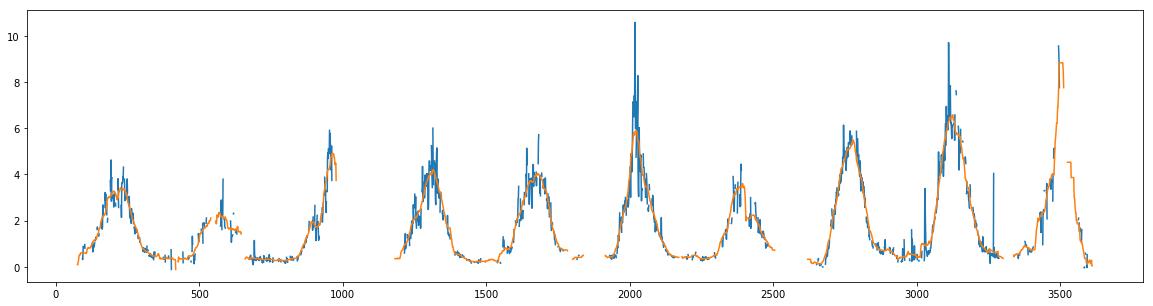

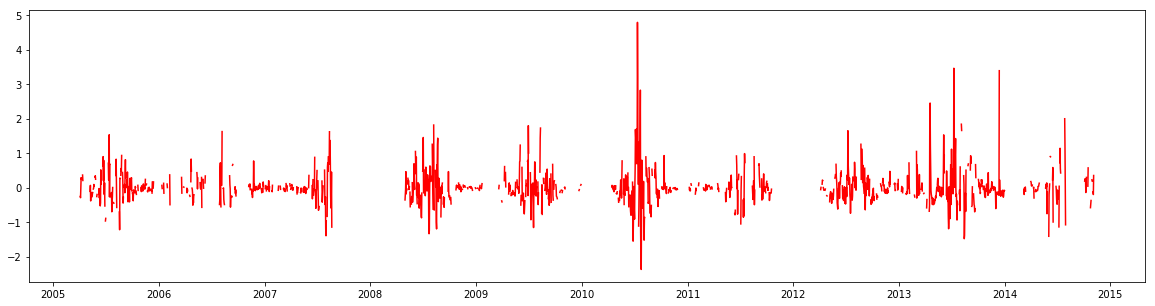

In [7]:
nanMA(table2['methane_flux'].copy(deep=True), 31, 1);

In [5]:
# Apply the moving window function
win = 31 
data = table2.copy(deep=True)
newData = data.apply(nanMA, axis=0, win=win, ploton=0) # 
newData.head(5)

T_air  Rh   R  T_-5cm  T_-10cm  T_-20cm  T_-35cm  T_-50cm  WT  \
Year_Month_Day                                                                  
2005-01-01        NaN NaN NaN     NaN      NaN      NaN      NaN      NaN NaN   
2005-01-02        NaN NaN NaN     NaN      NaN      NaN      NaN      NaN NaN   
2005-01-03        NaN NaN NaN     NaN      NaN      NaN      NaN      NaN NaN   
2005-01-04        NaN NaN NaN     NaN      NaN      NaN      NaN      NaN NaN   
2005-01-05        NaN NaN NaN     NaN      NaN      NaN      NaN      NaN NaN   

                NEE    ...      P_4_day  P_5_day  P_6_day  P_7_day  H2O_2_day  \
Year_Month_Day         ...                                                      
2005-01-01      NaN    ...          NaN      NaN      NaN      NaN        NaN   
2005-01-02      NaN    ...          NaN      NaN      NaN      NaN        NaN   
2005-01-03      NaN    ...          NaN      NaN      NaN      NaN        NaN   
2005-01-04      NaN    ...          NaN      NaN      NaN      NaN        NaN   
2005-01-05      NaN    ...          NaN      NaN      NaN      NaN        NaN   

                H2O_3_day  H2O_4_day  H2O_5_day  H2O_6_day  H2O_7_day  
Year_Month_Day                                                         
2005-01-01            NaN        NaN        NaN        NaN        NaN  
2005-01-02            NaN        NaN        NaN        NaN        NaN  
2005-01-03            NaN        NaN        NaN        NaN        NaN  
2005-01-04            NaN        NaN        NaN        NaN        NaN  
2005-01-05            NaN        NaN        NaN        NaN        NaN  

[5 rows x 81 columns]

### Evaluate autocorrelation functions.

In [11]:
count = 0
for column in newData:
    (r, sig_thr) = nanacf(newData.loc[:,column].values)
    #plt.figure()
    #plt.plot(r)
    #plt.plot(sig_thr, 'k--')
    #plt.plot(-sig_thr, 'k--')
    #plt.xlabel('lag')
    #plt.ylabel('autocorrelation')
    #plt.title(newData.columns[count])
    count = count + 1
    above_thr = r-sig_thr
    not_corr = np.where(above_thr<0)
    if np.min(np.size(not_corr))>0:
        
        per = not_corr[0][0]
    else:
        per = 999
    #print(np.size(per))
    if per <= 18: #Print out variables that have a period deemed acceptable for avoiding pseudoreplication (albeit subjective)
        print(column)
        print(per)

T_air
5
Rh
4
R
3
T_-5cm
6
T_-10cm
6
T_-20cm
7
T_-35cm
8
T_-50cm
9
WT
6
NEE
3
Reco
5
GPP
4
methane_flux
3
P
1
H2O
4
T_air_2_day
5
T_air_3_day
5
T_air_4_day
5
T_air_5_day
5
T_air_6_day
6
T_air_7_day
6
Rh_2_day
4
Rh_3_day
4
Rh_4_day
5
Rh_5_day
5
Rh_6_day
6
Rh_7_day
6
R_2_day
4
R_3_day
4
R_4_day
4
R_5_day
5
R_6_day
5
R_7_day
6
T_-5cm_2_day
6
T_-5cm_3_day
6
T_-5cm_4_day
6
T_-5cm_5_day
6
T_-5cm_6_day
7
T_-5cm_7_day
7
T_-10cm_2_day
6
T_-10cm_3_day
6
T_-10cm_4_day
7
T_-10cm_5_day
7
T_-10cm_6_day
7
T_-10cm_7_day
7
WT_2_day
7
WT_3_day
7
WT_4_day
7
WT_5_day
7
WT_6_day
7
WT_7_day
7
NEE_2_day
4
NEE_3_day
4
NEE_4_day
4
NEE_5_day
5
NEE_6_day
5
NEE_7_day
6
Reco_2_day
5
Reco_3_day
5
Reco_4_day
5
Reco_5_day
6
Reco_6_day
6
Reco_7_day
6
GPP_2_day
5
GPP_3_day
5
GPP_4_day
5
GPP_5_day
5
GPP_6_day
6
GPP_7_day
6
P_2_day
2
P_3_day
3
P_4_day
4
P_5_day
4
P_6_day
5
P_7_day
5
H2O_2_day
4
H2O_3_day
4
H2O_4_day
4
H2O_5_day
5
H2O_6_day
5
H2O_7_day
6


### Evaluate histograms

In [ ]:
count = 0
for column in newData:
    pylab.figure()
    pylab.hist((newData.loc[~np.isnan(newData[column]), column]))
    pylab.title(newData.columns[count])
    count = count + 1

## TE, Nontransformed, t-1

In [7]:
# Adjust input for TE 
Table = copy.deepcopy(newData)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,10), np.arange(11, 52), 58:numVr+1]# ,10)] transformed, np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([10]) #CO2 flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['DateTime' 'NEE' 'T_air' 'Rh' 'R' 'T_-5cm' 'T_-10cm' 'T_-20cm' 'T_-35cm'
 'T_-50cm' 'WT' 'Reco' 'GPP' 'methane_flux' 'P' 'H2O' 'T_air_2_day'
 'T_air_3_day' 'T_air_4_day' 'T_air_5_day' 'T_air_6_day' 'T_air_7_day'
 'Rh_2_day' 'Rh_3_day' 'Rh_4_day' 'Rh_5_day' 'Rh_6_day' 'Rh_7_day'
 'R_2_day' 'R_3_day' 'R_4_day' 'R_5_day' 'R_6_day' 'R_7_day' 'T_-5cm_2_day'
 'T_-5cm_3_day' 'T_-5cm_4_day' 'T_-5cm_5_day' 'T_-5cm_6_day' 'T_-5cm_7_day'
 'T_-10cm_2_day' 'T_-10cm_3_day' 'T_-10cm_4_day' 'T_-10cm_5_day'
 'T_-10cm_6_day' 'T_-10cm_7_day' 'WT_2_day' 'WT_3_day' 'WT_4_day'
 'WT_5_day' 'WT_6_day' 'WT_7_day' 'Reco_2_day' 'Reco_3_day' 'Reco_4_day'
 'Reco_5_day' 'Reco_6_day' 'Reco_7_day' 'GPP_2_day' 'GPP_3_day' 'GPP_4_day'
 'GPP_5_day' 'GPP_6_day' 'GPP_7_day' 'P_2_day' 'P_3_day' 'P_4_day'
 'P_5_day' 'P_6_day' 'P_7_day' 'H2O_2_day' 'H2O_3_day' 'H2O_4_day'
 'H2O_5_day' 'H2O_6_day' 'H2O_7_day']


In [8]:

#importlib.reload(TEpython3)

sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=60,shift=sf)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  10 NEE
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
Source node  1 Rh :=> Sink node  10 NEE
Lag  Sink Source
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
12 0 1
13 0 1
14 0 1
15 0 1
16 0 1
17 0 1
18 0 1
19 0 1
20 0 1
21 0 1
22 0 1
23 0 1
24 0 1
25 0 1
26 0 1
27 0 1
28 0 1
29 0 1
30 0 1
31 0 1
32 0 1
33 0 1
34 0 1
35 0 1
36 0 1
37 0 1
38 0 1
39 0 1
40 0 1
41 0 1
42 0 1
43 0 1
44 0 1
45 0 1
46 0 1
47 0 1
48 0 1
49 0 1
50 0 1
51 0 1
52 0 1
53 0 1
54 0 1
55 0 1
56 0 1
57 0 1
58 0 1
59 0 1
Source node  2 R :=>

25 0 16
26 0 16
27 0 16
28 0 16
29 0 16
30 0 16
31 0 16
32 0 16
33 0 16
34 0 16
35 0 16
36 0 16
37 0 16
38 0 16
39 0 16
40 0 16
41 0 16
42 0 16
43 0 16
44 0 16
45 0 16
46 0 16
47 0 16
48 0 16
49 0 16
50 0 16
51 0 16
52 0 16
53 0 16
54 0 16
55 0 16
56 0 16
57 0 16
58 0 16
59 0 16
Source node  18 T_air_5_day :=> Sink node  10 NEE
Lag  Sink Source
0 0 17
1 0 17
2 0 17
3 0 17
4 0 17
5 0 17
6 0 17
7 0 17
8 0 17
9 0 17
10 0 17
11 0 17
12 0 17
13 0 17
14 0 17
15 0 17
16 0 17
17 0 17
18 0 17
19 0 17
20 0 17
21 0 17
22 0 17
23 0 17
24 0 17
25 0 17
26 0 17
27 0 17
28 0 17
29 0 17
30 0 17
31 0 17
32 0 17
33 0 17
34 0 17
35 0 17
36 0 17
37 0 17
38 0 17
39 0 17
40 0 17
41 0 17
42 0 17
43 0 17
44 0 17
45 0 17
46 0 17
47 0 17
48 0 17
49 0 17
50 0 17
51 0 17
52 0 17
53 0 17
54 0 17
55 0 17
56 0 17
57 0 17
58 0 17
59 0 17
Source node  19 T_air_6_day :=> Sink node  10 NEE
Lag  Sink Source
0 0 18
1 0 18
2 0 18
3 0 18
4 0 18
5 0 18
6 0 18
7 0 18
8 0 18
9 0 18
10 0 18
11 0 18
12 0 18
13 0 18
14 0 18
15 0 1

48 0 31
49 0 31
50 0 31
51 0 31
52 0 31
53 0 31
54 0 31
55 0 31
56 0 31
57 0 31
58 0 31
59 0 31
Source node  33 T_-5cm_2_day :=> Sink node  10 NEE
Lag  Sink Source
0 0 32
1 0 32
2 0 32
3 0 32
4 0 32
5 0 32
6 0 32
7 0 32
8 0 32
9 0 32
10 0 32
11 0 32
12 0 32
13 0 32
14 0 32
15 0 32
16 0 32
17 0 32
18 0 32
19 0 32
20 0 32
21 0 32
22 0 32
23 0 32
24 0 32
25 0 32
26 0 32
27 0 32
28 0 32
29 0 32
30 0 32
31 0 32
32 0 32
33 0 32
34 0 32
35 0 32
36 0 32
37 0 32
38 0 32
39 0 32
40 0 32
41 0 32
42 0 32
43 0 32
44 0 32
45 0 32
46 0 32
47 0 32
48 0 32
49 0 32
50 0 32
51 0 32
52 0 32
53 0 32
54 0 32
55 0 32
56 0 32
57 0 32
58 0 32
59 0 32
Source node  34 T_-5cm_3_day :=> Sink node  10 NEE
Lag  Sink Source
0 0 33
1 0 33
2 0 33
3 0 33
4 0 33
5 0 33
6 0 33
7 0 33
8 0 33
9 0 33
10 0 33
11 0 33
12 0 33
13 0 33
14 0 33
15 0 33
16 0 33
17 0 33
18 0 33
19 0 33
20 0 33
21 0 33
22 0 33
23 0 33
24 0 33
25 0 33
26 0 33
27 0 33
28 0 33
29 0 33
30 0 33
31 0 33
32 0 33
33 0 33
34 0 33
35 0 33
36 0 33
37 0 33
38 0

0 0 47
1 0 47
2 0 47
3 0 47
4 0 47
5 0 47
6 0 47
7 0 47
8 0 47
9 0 47
10 0 47
11 0 47
12 0 47
13 0 47
14 0 47
15 0 47
16 0 47
17 0 47
18 0 47
19 0 47
20 0 47
21 0 47
22 0 47
23 0 47
24 0 47
25 0 47
26 0 47
27 0 47
28 0 47
29 0 47
30 0 47
31 0 47
32 0 47
33 0 47
34 0 47
35 0 47
36 0 47
37 0 47
38 0 47
39 0 47
40 0 47
41 0 47
42 0 47
43 0 47
44 0 47
45 0 47
46 0 47
47 0 47
48 0 47
49 0 47
50 0 47
51 0 47
52 0 47
53 0 47
54 0 47
55 0 47
56 0 47
57 0 47
58 0 47
59 0 47
Source node  49 WT_6_day :=> Sink node  10 NEE
Lag  Sink Source
0 0 48
1 0 48
2 0 48
3 0 48
4 0 48
5 0 48
6 0 48
7 0 48
8 0 48
9 0 48
10 0 48
11 0 48
12 0 48
13 0 48
14 0 48
15 0 48
16 0 48
17 0 48
18 0 48
19 0 48
20 0 48
21 0 48
22 0 48
23 0 48
24 0 48
25 0 48
26 0 48
27 0 48
28 0 48
29 0 48
30 0 48
31 0 48
32 0 48
33 0 48
34 0 48
35 0 48
36 0 48
37 0 48
38 0 48
39 0 48
40 0 48
41 0 48
42 0 48
43 0 48
44 0 48
45 0 48
46 0 48
47 0 48
48 0 48
49 0 48
50 0 48
51 0 48
52 0 48
53 0 48
54 0 48
55 0 48
56 0 48
57 0 48
58 0 48
59 0

22 0 62
23 0 62
24 0 62
25 0 62
26 0 62
27 0 62
28 0 62
29 0 62
30 0 62
31 0 62
32 0 62
33 0 62
34 0 62
35 0 62
36 0 62
37 0 62
38 0 62
39 0 62
40 0 62
41 0 62
42 0 62
43 0 62
44 0 62
45 0 62
46 0 62
47 0 62
48 0 62
49 0 62
50 0 62
51 0 62
52 0 62
53 0 62
54 0 62
55 0 62
56 0 62
57 0 62
58 0 62
59 0 62
Source node  70 P_3_day :=> Sink node  10 NEE
Lag  Sink Source
0 0 63
1 0 63
2 0 63
3 0 63
4 0 63
5 0 63
6 0 63
7 0 63
8 0 63
9 0 63
10 0 63
11 0 63
12 0 63
13 0 63
14 0 63
15 0 63
16 0 63
17 0 63
18 0 63
19 0 63
20 0 63
21 0 63
22 0 63
23 0 63
24 0 63
25 0 63
26 0 63
27 0 63
28 0 63
29 0 63
30 0 63
31 0 63
32 0 63
33 0 63
34 0 63
35 0 63
36 0 63
37 0 63
38 0 63
39 0 63
40 0 63
41 0 63
42 0 63
43 0 63
44 0 63
45 0 63
46 0 63
47 0 63
48 0 63
49 0 63
50 0 63
51 0 63
52 0 63
53 0 63
54 0 63
55 0 63
56 0 63
57 0 63
58 0 63
59 0 63
Source node  71 P_4_day :=> Sink node  10 NEE
Lag  Sink Source
0 0 64
1 0 64
2 0 64
3 0 64
4 0 64
5 0 64
6 0 64
7 0 64
8 0 64
9 0 64
10 0 64
11 0 64
12 0 64
13 0 6

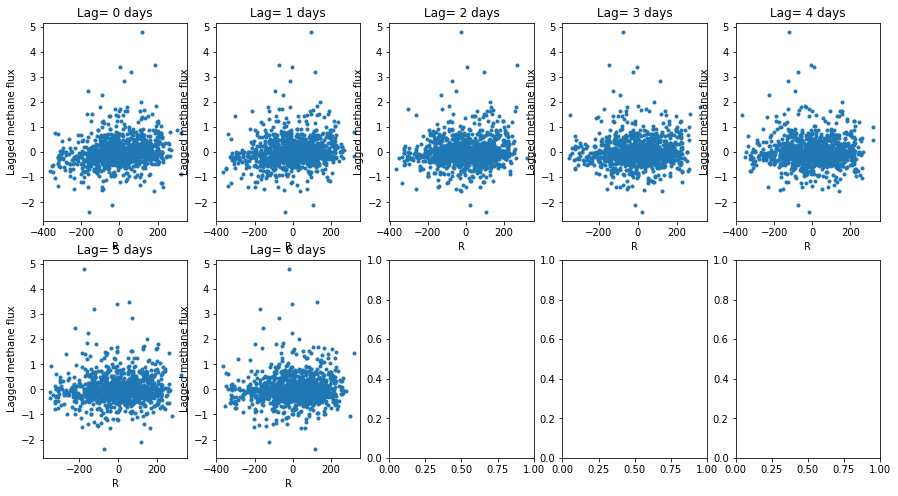

In [29]:
# Plot R vs methane flux
lag = np.arange(0, 7)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    if n==0:
        y = np.array(Table.iloc[:]['methane_flux'])
        x = np.array(Table.iloc[:]['R'])
    else:
        y = np.array(Table.iloc[n:]['methane_flux'])
        x = np.array(Table.iloc[:-n]['R'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('R')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

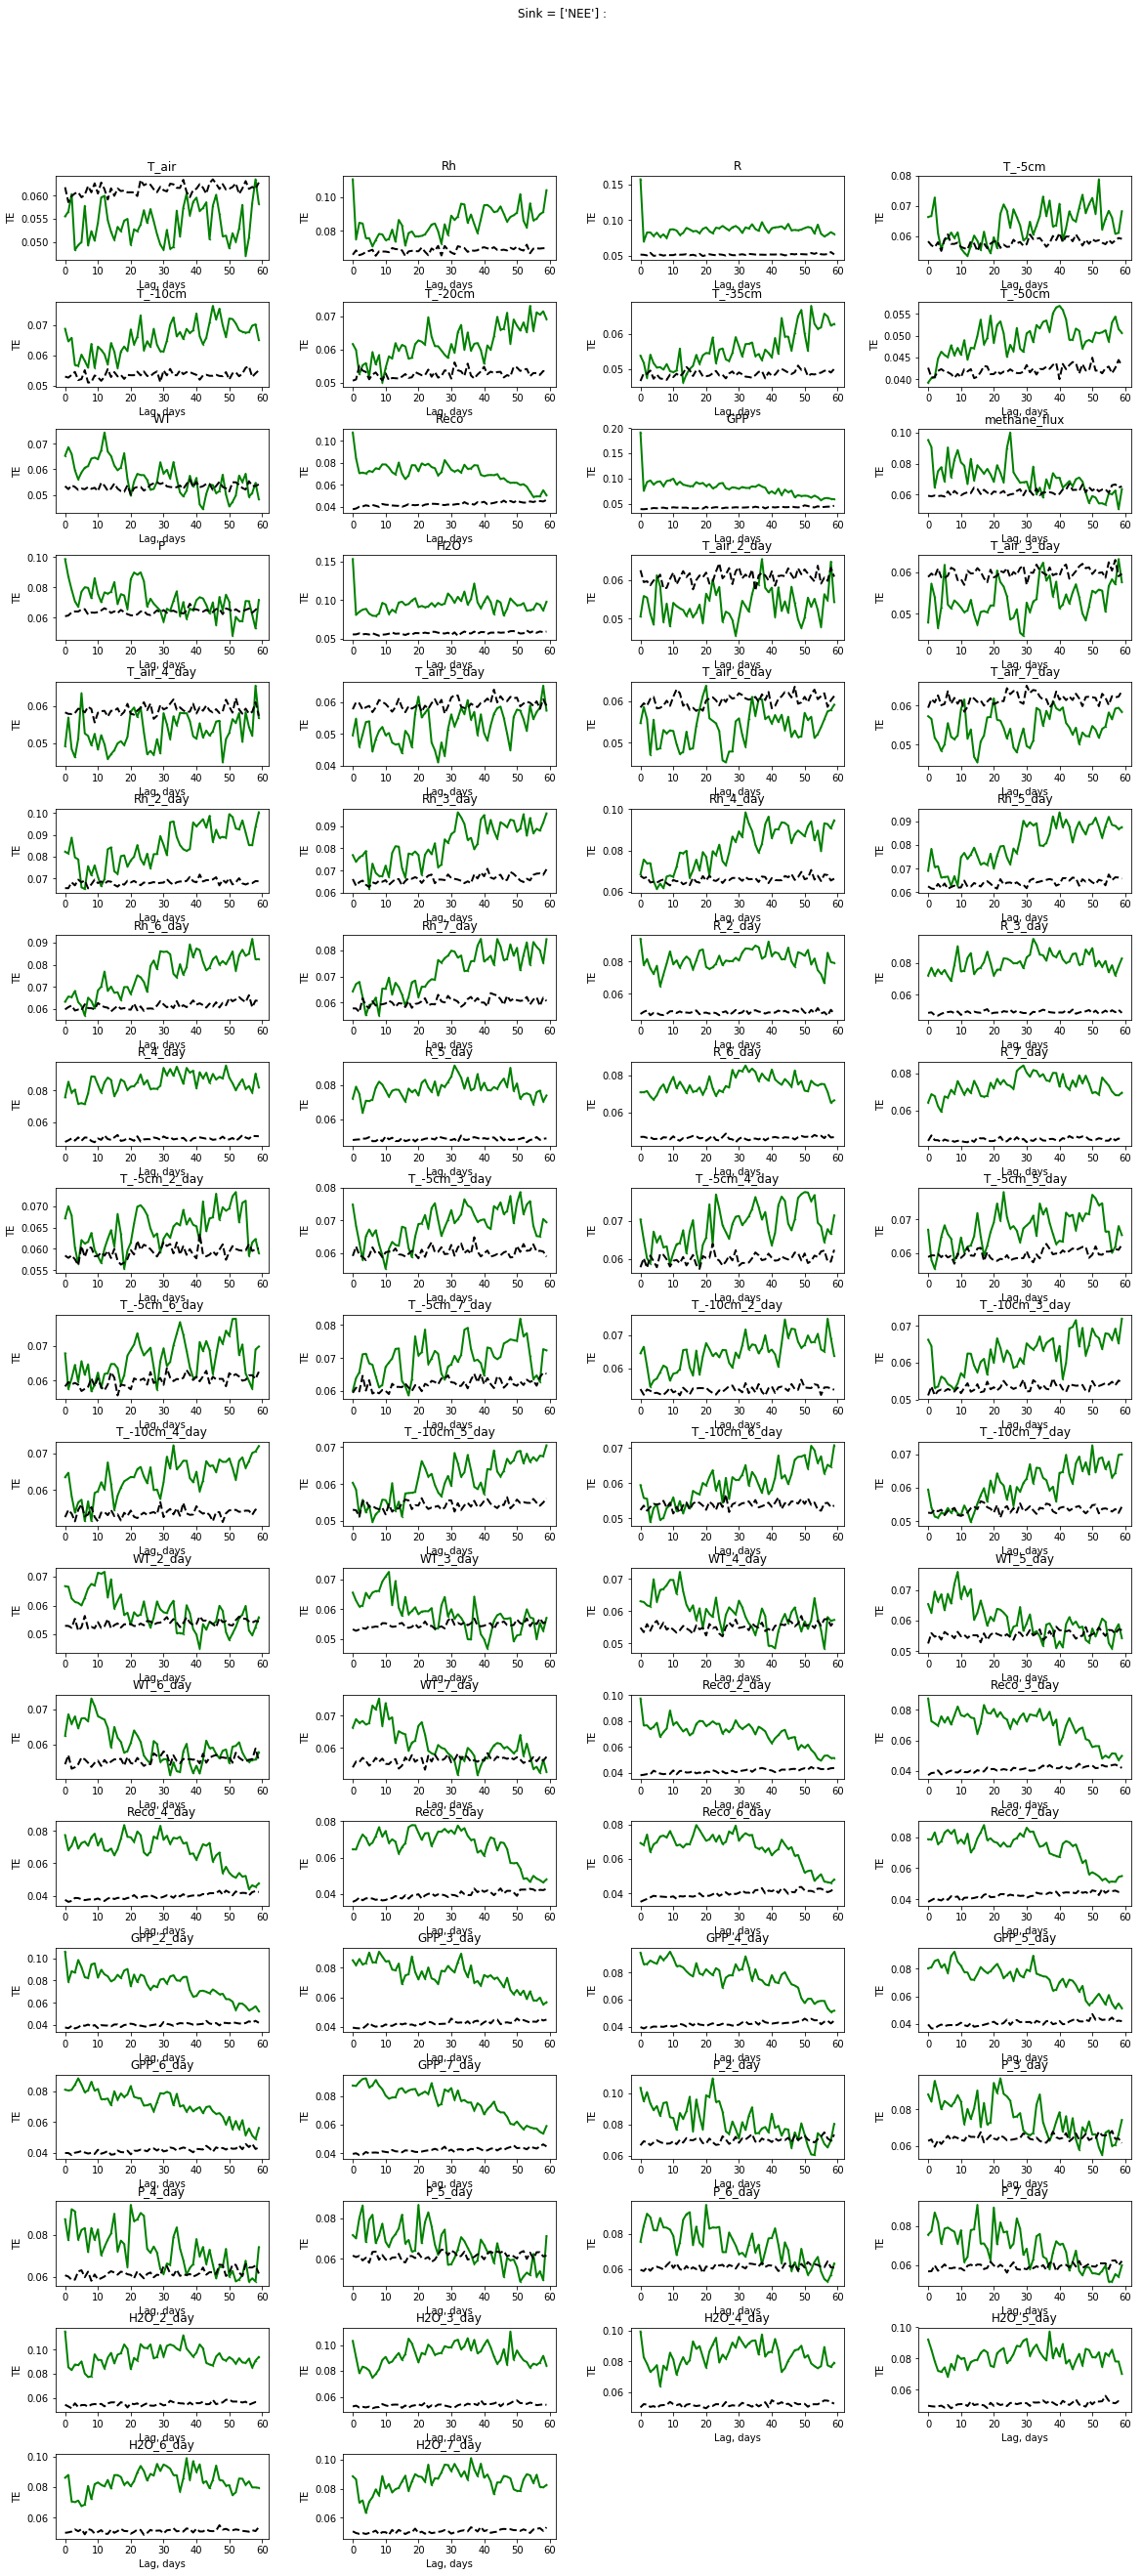

In [9]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 60

n = Tcube_store.shape[1]
plt.figure(figsize=[18,40])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
ACLabels = [] #Initialize an empty list that will contain the source variables for each row of AboveCritic
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    
    ACLabels.append(LabelC[SourN[i]])
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title(ACLabels[i])
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    if np.sum(~np.isnan(AboveCritic[i,:])):
        LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

Text(0.5,0,'TE at Lag (days)')

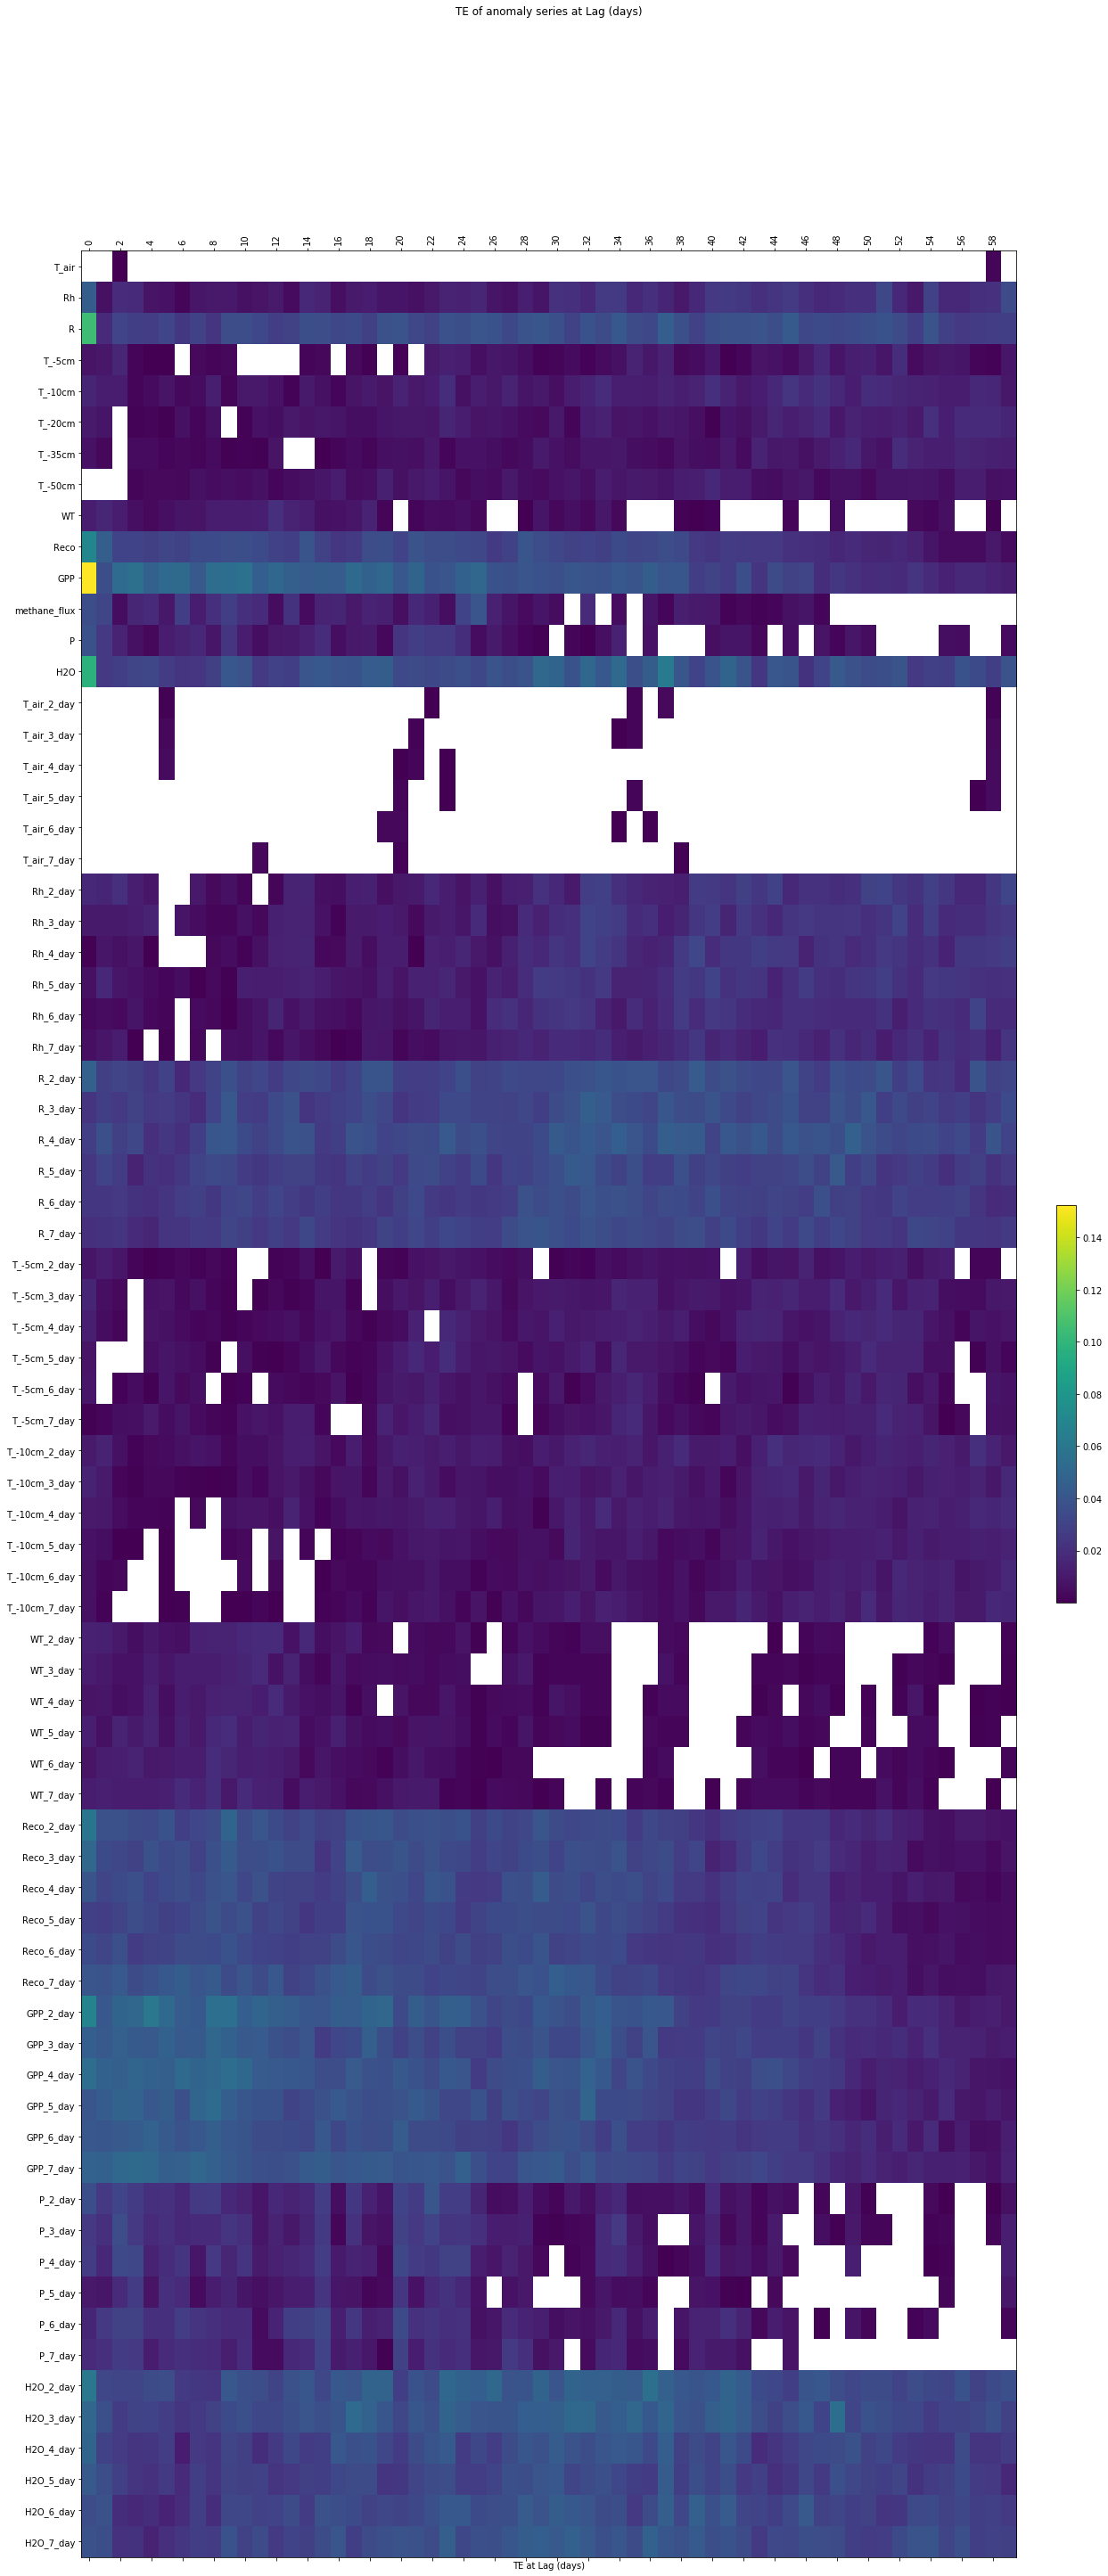

In [10]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[SourN]
minV = np.nanmin(AboveCritic)
maxV = np.nanmax(AboveCritic)

fig = plt.figure(1,figsize = (20,50)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='viridis', aspect=2) #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,2)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(ticksX)
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of anomaly series at Lag (days)',y=1.1)
plt.xlabel('TE at Lag (days)')

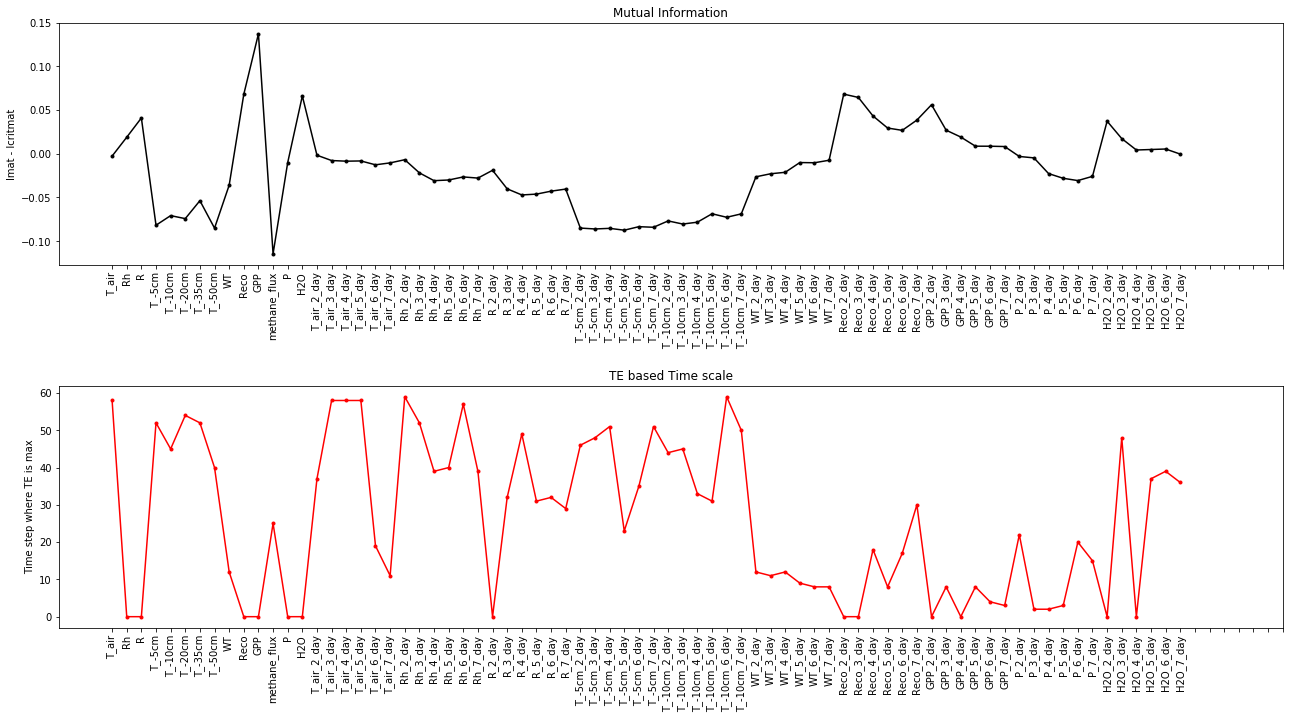

In [11]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[20,10])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

## TE, resampled, t-1

In [13]:
sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython4.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=60,shift=sf)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  10 NEE
Lag  Sink Source
5
0 0 0 409
1 0 0 410
2 0 0 411
3 0 0 410
4 0 0 400
5 0 0 410
6 0 0 407
7 0 0 410
8 0 0 409
9 0 0 400
10 0 0 412
11 0 0 409
12 0 0 411
13 0 0 410
14 0 0 401
15 0 0 410
16 0 0 406
17 0 0 408
18 0 0 407
19 0 0 397
20 0 0 407
21 0 0 406
22 0 0 408
23 0 0 404
24 0 0 394
25 0 0 403
26 0 0 403
27 0 0 405
28 0 0 404
29 0 0 396
30 0 0 403
31 0 0 402
32 0 0 404
33 0 0 401
34 0 0 394
35 0 0 404
36 0 0 400
37 0 0 400
38 0 0 399
39 0 0 390
40 0 0 399
41 0 0 398
42 0 0 401
43 0 0 400
44 0 0 391
45 0 0 401
46 0 0 399
47 0 0 402
48 0 0 400
49 0 0 392
50 0 0 401
51 0 0 398
52 0 0 400
53 0 0 399
54 0 0 391
55 0 0 400
56 0 0 396
57 0 0 400
58 0 0 399
59 0 0 390
Source node  1 Rh :=> Sink node  10 NEE
Lag  Sink Source
4
0 0 1 520
1 0 1 516
2 0 1 516
3 0 1 517
4 0 1 513
5 0 1 514
6 0 1 515
7 0 1 515
8 0 1 512
9 0 1 513
10 0 1 515
11 0 1 515
12 0 1 513
13 0 1 514
14 0 1 513
15 0 1 512
16 0 1 510
17 0 1 51

17 0 11 415
18 0 11 414
19 0 11 417
20 0 11 415
21 0 11 419
22 0 11 411
23 0 11 410
24 0 11 412
25 0 11 412
26 0 11 411
27 0 11 410
28 0 11 408
29 0 11 407
30 0 11 410
31 0 11 406
32 0 11 405
33 0 11 407
34 0 11 404
35 0 11 407
36 0 11 411
37 0 11 410
38 0 11 406
39 0 11 401
40 0 11 401
41 0 11 400
42 0 11 401
43 0 11 403
44 0 11 401
45 0 11 399
46 0 11 398
47 0 11 398
48 0 11 400
49 0 11 395
50 0 11 393
51 0 11 397
52 0 11 394
53 0 11 392
54 0 11 396
55 0 11 394
56 0 11 390
57 0 11 389
58 0 11 390
59 0 11 387
Source node  13 P :=> Sink node  10 NEE
Lag  Sink Source
1
0 0 12 1564
1 0 12 1562
2 0 12 1554
3 0 12 1555
4 0 12 1548
5 0 12 1544
6 0 12 1550
7 0 12 1555
8 0 12 1550
9 0 12 1546
10 0 12 1543
11 0 12 1536
12 0 12 1540
13 0 12 1542
14 0 12 1532
15 0 12 1534
16 0 12 1534
17 0 12 1537
18 0 12 1541
19 0 12 1539
20 0 12 1541
21 0 12 1550
22 0 12 1547
23 0 12 1540
24 0 12 1536
25 0 12 1532
26 0 12 1527
27 0 12 1528
28 0 12 1530
29 0 12 1529
30 0 12 1522
31 0 12 1524
32 0 12 1524
33 0 1

48 0 21 498
49 0 21 495
50 0 21 499
51 0 21 499
52 0 21 497
53 0 21 493
54 0 21 499
55 0 21 499
56 0 21 497
57 0 21 492
58 0 21 496
59 0 21 497
Source node  23 Rh_4_day :=> Sink node  10 NEE
Lag  Sink Source
5
0 0 22 419
1 0 22 420
2 0 22 421
3 0 22 421
4 0 22 412
5 0 22 421
6 0 22 417
7 0 22 420
8 0 22 419
9 0 22 410
10 0 22 421
11 0 22 418
12 0 22 421
13 0 22 419
14 0 22 410
15 0 22 419
16 0 22 415
17 0 22 418
18 0 22 417
19 0 22 407
20 0 22 416
21 0 22 414
22 0 22 417
23 0 22 414
24 0 22 404
25 0 22 413
26 0 22 411
27 0 22 414
28 0 22 412
29 0 22 402
30 0 22 410
31 0 22 409
32 0 22 412
33 0 22 410
34 0 22 400
35 0 22 410
36 0 22 408
37 0 22 410
38 0 22 409
39 0 22 398
40 0 22 407
41 0 22 407
42 0 22 410
43 0 22 409
44 0 22 397
45 0 22 407
46 0 22 406
47 0 22 409
48 0 22 406
49 0 22 396
50 0 22 406
51 0 22 404
52 0 22 407
53 0 22 406
54 0 22 396
55 0 22 405
56 0 22 403
57 0 22 407
58 0 22 406
59 0 22 395
Source node  24 Rh_5_day :=> Sink node  10 NEE
Lag  Sink Source
5
0 0 23 419
1 0

20 0 32 291
21 0 32 302
22 0 32 300
23 0 32 292
24 0 32 291
25 0 32 291
26 0 32 289
27 0 32 300
28 0 32 299
29 0 32 291
30 0 32 290
31 0 32 289
32 0 32 288
33 0 32 299
34 0 32 298
35 0 32 290
36 0 32 289
37 0 32 288
38 0 32 287
39 0 32 297
40 0 32 296
41 0 32 289
42 0 32 288
43 0 32 287
44 0 32 287
45 0 32 296
46 0 32 295
47 0 32 289
48 0 32 289
49 0 32 287
50 0 32 286
51 0 32 295
52 0 32 295
53 0 32 289
54 0 32 290
55 0 32 288
56 0 32 287
57 0 32 295
58 0 32 294
59 0 32 288
Source node  34 T_-5cm_3_day :=> Sink node  10 NEE
Lag  Sink Source
6
0 0 33 298
1 0 33 296
2 0 33 294
3 0 33 306
4 0 33 305
5 0 33 297
6 0 33 296
7 0 33 295
8 0 33 293
9 0 33 305
10 0 33 305
11 0 33 297
12 0 33 296
13 0 33 295
14 0 33 292
15 0 33 303
16 0 33 302
17 0 33 294
18 0 33 293
19 0 33 293
20 0 33 291
21 0 33 302
22 0 33 300
23 0 33 292
24 0 33 291
25 0 33 291
26 0 33 289
27 0 33 300
28 0 33 299
29 0 33 291
30 0 33 290
31 0 33 289
32 0 33 288
33 0 33 299
34 0 33 298
35 0 33 290
36 0 33 289
37 0 33 288
38 0

53 0 42 320
54 0 42 318
55 0 42 321
56 0 42 321
57 0 42 322
58 0 42 321
59 0 42 324
Source node  44 T_-10cm_7_day :=> Sink node  10 NEE
Lag  Sink Source
7
0 0 43 327
1 0 43 329
2 0 43 327
3 0 43 332
4 0 43 328
5 0 43 328
6 0 43 331
7 0 43 330
8 0 43 329
9 0 43 326
10 0 43 330
11 0 43 329
12 0 43 329
13 0 43 331
14 0 43 331
15 0 43 331
16 0 43 325
17 0 43 327
18 0 43 325
19 0 43 325
20 0 43 329
21 0 43 329
22 0 43 329
23 0 43 324
24 0 43 326
25 0 43 322
26 0 43 322
27 0 43 326
28 0 43 325
29 0 43 325
30 0 43 321
31 0 43 324
32 0 43 321
33 0 43 322
34 0 43 325
35 0 43 324
36 0 43 324
37 0 43 320
38 0 43 323
39 0 43 319
40 0 43 320
41 0 43 324
42 0 43 322
43 0 43 322
44 0 43 321
45 0 43 326
46 0 43 320
47 0 43 319
48 0 43 322
49 0 43 320
50 0 43 320
51 0 43 319
52 0 43 324
53 0 43 320
54 0 43 318
55 0 43 321
56 0 43 321
57 0 43 322
58 0 43 321
59 0 43 324
Source node  45 WT_2_day :=> Sink node  10 NEE
Lag  Sink Source
7
0 0 44 319
1 0 44 321
2 0 44 318
3 0 44 323
4 0 44 319
5 0 44 319
6 0

24 0 53 391
25 0 53 389
26 0 53 390
27 0 53 393
28 0 53 389
29 0 53 383
30 0 53 386
31 0 53 383
32 0 53 384
33 0 53 384
34 0 53 379
35 0 53 374
36 0 53 377
37 0 53 376
38 0 53 378
39 0 53 381
40 0 53 377
41 0 53 369
42 0 53 375
43 0 53 374
44 0 53 375
45 0 53 377
46 0 53 372
47 0 53 365
48 0 53 370
49 0 53 367
50 0 53 368
51 0 53 372
52 0 53 368
53 0 53 361
54 0 53 365
55 0 53 362
56 0 53 366
57 0 53 369
58 0 53 364
59 0 53 359
Source node  61 Reco_6_day :=> Sink node  10 NEE
Lag  Sink Source
6
0 0 54 430
1 0 54 430
2 0 54 419
3 0 54 420
4 0 54 414
5 0 54 408
6 0 54 407
7 0 54 406
8 0 54 406
9 0 54 413
10 0 54 405
11 0 54 398
12 0 54 398
13 0 54 397
14 0 54 400
15 0 54 407
16 0 54 402
17 0 54 394
18 0 54 395
19 0 54 393
20 0 54 396
21 0 54 401
22 0 54 394
23 0 54 387
24 0 54 391
25 0 54 389
26 0 54 390
27 0 54 393
28 0 54 389
29 0 54 383
30 0 54 386
31 0 54 383
32 0 54 384
33 0 54 384
34 0 54 379
35 0 54 374
36 0 54 377
37 0 54 376
38 0 54 378
39 0 54 381
40 0 54 377
41 0 54 369
42 0 5

0 0 64 381
1 0 64 390
2 0 64 387
3 0 64 385
4 0 64 381
5 0 64 381
6 0 64 382
7 0 64 384
8 0 64 386
9 0 64 385
10 0 64 382
11 0 64 378
12 0 64 380
13 0 64 384
14 0 64 380
15 0 64 380
16 0 64 382
17 0 64 385
18 0 64 388
19 0 64 385
20 0 64 382
21 0 64 384
22 0 64 390
23 0 64 389
24 0 64 386
25 0 64 385
26 0 64 384
27 0 64 382
28 0 64 382
29 0 64 381
30 0 64 378
31 0 64 381
32 0 64 383
33 0 64 379
34 0 64 377
35 0 64 378
36 0 64 376
37 0 64 377
38 0 64 383
39 0 64 377
40 0 64 378
41 0 64 376
42 0 64 373
43 0 64 376
44 0 64 380
45 0 64 376
46 0 64 371
47 0 64 373
48 0 64 377
49 0 64 375
50 0 64 375
51 0 64 374
52 0 64 375
53 0 64 369
54 0 64 370
55 0 64 369
56 0 64 369
57 0 64 371
58 0 64 372
59 0 64 372
Source node  72 P_5_day :=> Sink node  10 NEE
Lag  Sink Source
4
0 0 65 381
1 0 65 390
2 0 65 387
3 0 65 385
4 0 65 381
5 0 65 381
6 0 65 382
7 0 65 384
8 0 65 386
9 0 65 385
10 0 65 382
11 0 65 378
12 0 65 380
13 0 65 384
14 0 65 380
15 0 65 380
16 0 65 382
17 0 65 385
18 0 65 388
19 0 65

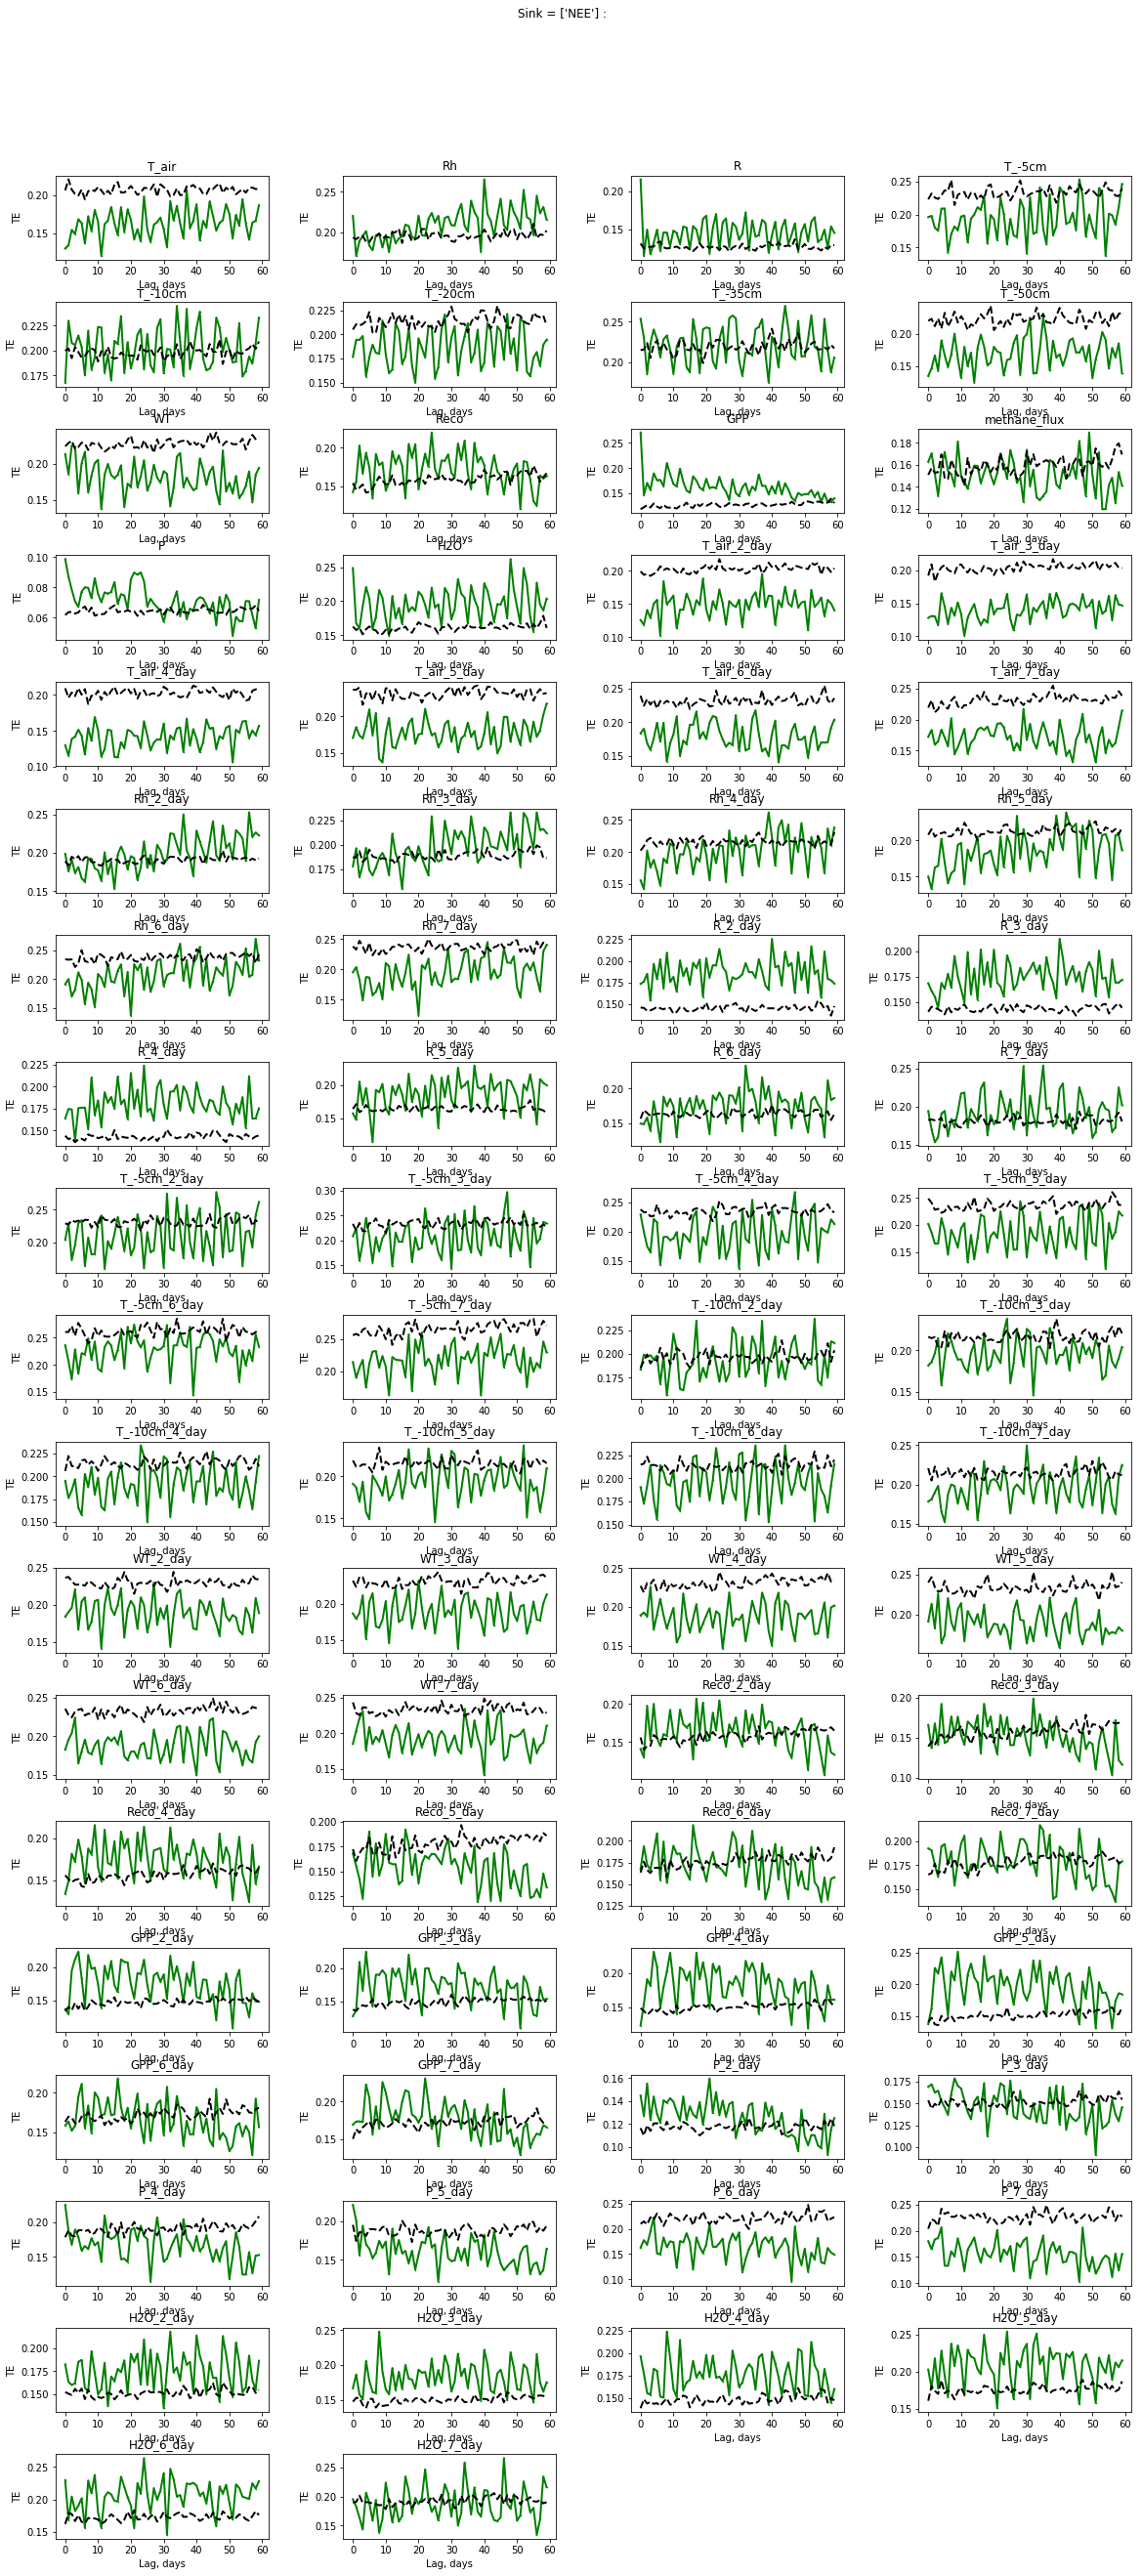

In [14]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 60

n = Tcube_store.shape[1]
plt.figure(figsize=[18,40])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
ACLabels = [] #Initialize an empty list that will contain the source variables for each row of AboveCritic
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    
    ACLabels.append(LabelC[SourN[i]])
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title(ACLabels[i])
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

Text(0.5,0,'TE at Lag (days)')

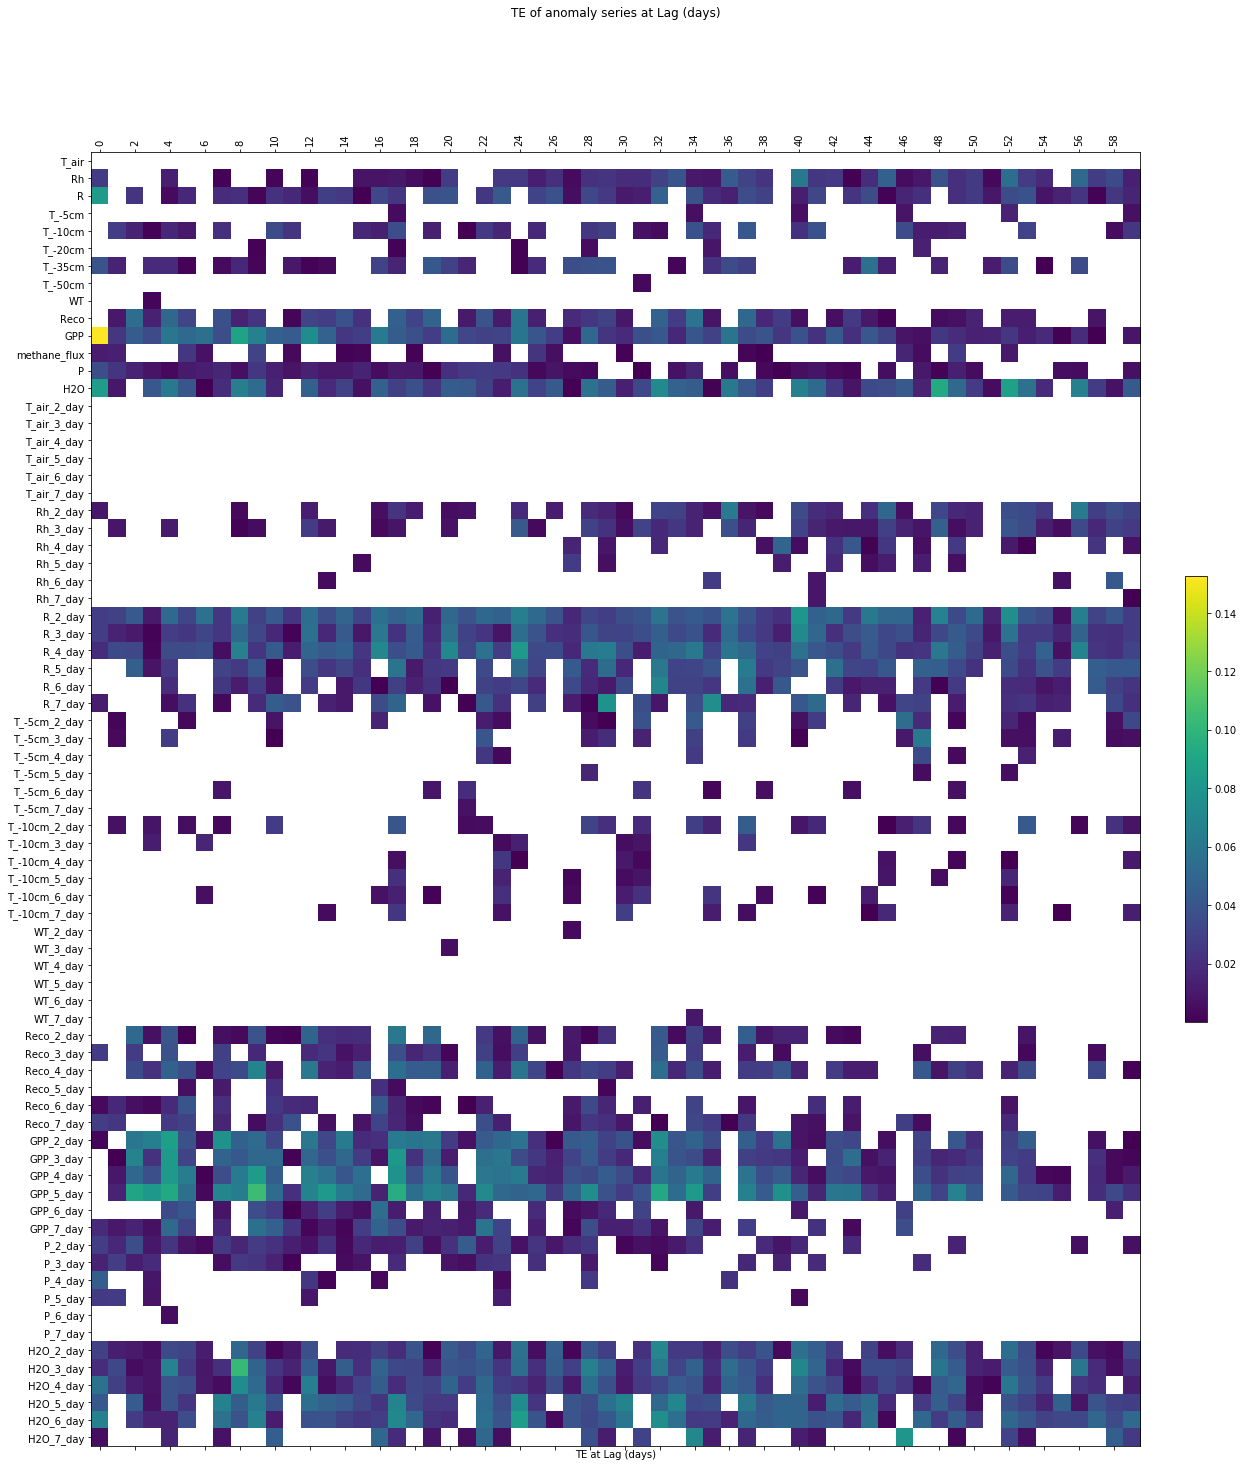

In [15]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[SourN]
minV = np.nanmin(AboveCritic)
maxV = np.nanmax(AboveCritic)

fig = plt.figure(1,figsize = (20,50)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='viridis', aspect=1) #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,2)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(ticksX)
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of anomaly series at Lag (days)',y=1.1)
plt.xlabel('TE at Lag (days)')

In [ ]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[20,5])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr)," ")
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)